# Plots for the Teachable Robot Project

# Useful Functions

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [15, 5]
import seaborn as sbn
import matplotlib as mpl

In [7]:
cd ..

/home/olivia/Teachable/babyai


In [8]:
data_dirs = [
    pathlib.Path('logs'),
#     pathlib.Path('meta-mb-internal/eval_runs'),
#     pathlib.Path('meta-mb-internal/old_data'),
#     pathlib.Path('meta-mb-internal/old_eval_runs'),
#     pathlib.Path('meta-mb-internal'),
]

def get_filenames(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    print("NP", name_paths)
    return name_paths

def format_plot():
    fig, ax = plt.subplots(1, 1)
    sbn.set_style('darkgrid')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='w', linewidth=1.0)
    ax.grid(b=True, which='minor', color='w', linewidth=0.5)

def plot_curriculum(data_names, x_type, use_min_len=True, y='Curriculum Percent', smooth=1,
                   level_start=0, level_end=float('inf'), title=None, error_bars=False, y_lower=0,
                   y_upper=1.01, plot_advancement=False, y_label="default", y_transform=lambda x: x, 
                    save_name=None, x_min=None, x_max=None):
    
    if not type(y) is list:
        y = [y]
    format_plot()
        
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names) * len(y))))
    plots = []
        
    for y_str in y:
        df_y_key = y_str
        df_level_key = 'Curriculum Step'
        if x_type == 'samples':
            x_label = 'Samples'
            df_x_key = 'Itr'
            title = 'Sample Efficiency' if title is None else title
        elif x_type == 'feedback':
            x_label = 'Advice Units'
            df_x_key = 'Train/NumFeedbackTotal'
            title = 'Feedback Efficiency' if title is None else title
            
        print("data names", data_names)

        for run_names, legend_name, c, marker in data_names:
            print("RUN NAMES", run_names)
            if len(y) > 1:
                legend_name = legend_name + ' - ' + y_str
            try:
                if c is None:
                    c = next(color)
                print("about to load")
                data = [d for run_name in run_names for d in load_data(run_name)]
                print("got data", len(data))
                cols = [df[df_y_key].ewm(span=smooth).mean().to_numpy() for df in data]
                
                print("LENGTHS", [len(d) for d in data])
                shared_good_indices = np.arange(len(data[0]))
                for i, run in enumerate(cols):
                    run = y_transform(run)
                    x_val = data[i][df_x_key].to_numpy()
                    non_null_indices = ~np.isnan(x_val)
                    levels = data[i][df_level_key].to_numpy()
                    above_min_level = levels >= level_start
                    below_max_level = levels <= level_end
                    in_range = np.logical_and(above_min_level, below_max_level)
                    good_indices = np.logical_and(in_range, non_null_indices)
                    good_indices = np.argwhere(good_indices)[:, 0]
                    if error_bars:
                        shared_good_indices = [x for x in shared_good_indices if x in good_indices]
                    else:
                        plt.plot(x_val[good_indices], run[good_indices], c=c)
                if plot_advancement:
                    level_advancement = data[i][df_level_key].diff().to_numpy()
                    advancement_indices = np.argwhere(level_advancement > 0)[:, 0]
                    for advancement_index in advancement_indices:
                        plt.axvline(x=advancement_index, c=c)
                if error_bars:
                    run_data = np.stack(y_transform(run[shared_good_indices]) for run in cols)
                    mean_run_data = np.mean(run_data, axis=0)
                    std_run_data = np.std(run_data, axis=0)
                    x_val = data[0][df_x_key].to_numpy()[shared_good_indices]

                    shortest_len = x_val[-1]
#                     if x_max is not None:
#                         shortest_len = x_max
                    x = np.arange(0, shortest_len, max(shortest_len // 50, 1))
                    mean_run_data = np.interp(x, x_val, mean_run_data)
                    std_run_data = np.interp(x, x_val, std_run_data)
                    x_val = x
                    plt.plot(x_val, mean_run_data, c=c, marker=marker)
                    plt.fill_between(x_val, mean_run_data - std_run_data, mean_run_data + std_run_data, color=c, alpha=0.2)
                legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
                plots.append(legend_line)
            except Exception as e:
                print(e)
#                 print("couldn't plot " + legend_name)
# peacock
    plt.ticklabel_format(scilimits=(0,0))
    plt.title(title, fontsize=20)
    if y_label == 'default':
        y_label = y_str if len(y) else ''
    plt.ylabel(y_label, fontsize=20)
    plt.ylim(y_lower, y_upper)
    plt.xlabel(x_label, fontsize=20)
#     plt.legend(handles=plots, fontsize=20)
    if x_max is not None:
        if x_min is None:
            x_min = 0
        plt.xlim(x_min, x_max)
    if save_name is not None:
        plt.savefig('figs/' + save_name, bbox_inches='tight')
    plt.show()


def load_data(name, file_name='progress.csv'):
    if type(name) is pathlib.PosixPath:
        name_paths = [name]
    else:
        name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    print("nps", len(name_paths))
    csv_datas = []
    for path in name_paths:
#         assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        try:
            csv_name = path.joinpath(file_name)
            data = pd.read_csv(csv_name)
        except Exception as e:
            print(e)
            csv_name = path.joinpath('new_progress.csv')
            data = pd.read_csv(csv_name)
            
        # Remove whitespace in col names
        data.columns = [c.strip() for c in data.columns]
        csv_datas.append(data)
    print("LL", len(csv_datas))
    return csv_datas
        
def plot_final_generalization(runs, title, metric='success_rate', all_run_names=None, all_env_names=None,
                             save_name=None):
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            success = [df[metric].to_numpy() for df in data]
            env_names = data[0]['env'].to_numpy()
            for i, env_name, in enumerate(env_names):
                if all_run_names is not None and not env_name in all_run_names:
                    continue
                if not env_name in env_dict:
                    env_dict[env_name] = ([], [], [])
                mean_list, std_list, legend_list = env_dict[env_name]
                mean_list.append(np.mean([s[i].item() for s in success]))
                std_list.append(np.std([s[i].item() for s in success]))
                legend_list.append(legend_name)
        except Exception as e:
            print("Error on ", run_names, e)
    print("ENV DICT", env_dict.keys())
    colors = ['blue', 'green', 'orange', 'purple', 'red', 'yellow', 'brown', 'pink']
    for i, (env_name, (mean_list, std_list, legend_list)) in enumerate(env_dict.items()):
        if all_env_names is not None:
            env_title = all_env_names[i]
        else:
            env_title = title
        plt.title(env_title, fontsize=20)
#         plt.title(title + ' - ' + str(env_name) + '; ' + metric, fontsize=20)
        color = 'green' if 'accuracy' in metric else None
        plt.bar(legend_list, mean_list, yerr=std_list, capsize=5, color=color)
        plt.xticks(rotation=80, fontsize=20)
        plt.ylim(0, 1)
        if save_name is not None:
            plt.savefig('figs/' + save_name + env_title + '.png', bbox_inches='tight')
        plt.show()
        

def plot_curriculum_generalization(runs, title, metric='success_rate'):
    for run_names, legend_name in runs:  # Currently plotting each one separately.
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            levels = sorted(np.unique(data[0]['policy']))
            print("LEVELS", levels)
            for level in levels:
                relevant_data = [df[df['policy'] == level] for df in data]
                x = relevant_data[0]['env']
                y_data = [df[metric].to_numpy() for df in relevant_data]
                y_mean = y_data[0]
                y_err = np.zeros_like(y_mean)
                y_mean = [np.mean([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                y_err = [np.std([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                plt.title(title + ' - ' + str(level))
                color = 'green' if 'accuracy' in metric else None
                plt.bar(x, y_mean, yerr=y_err, capsize=5, color=color)
                plt.xticks(rotation=90)
                plt.show()
        except Exception as e:
            print("Error on ", run_names, e)

        
def plot_leaderboard(methods):
    plot_values = []
    error_bars = []
    plot_names = []
    num_feedback_key = 'Train/NumFeedbackTotal'
    for run_names, legend_name, _ in methods:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name)
            if run_name in ['0577', '0578']:  # TODO: delete this later now that we've fixed how we count feedback
                pure_feedback_list = [df['Train/NumFeedbackAdvice'].to_numpy()[-2].item() for df in data]
                reward_list = [df['Train/NumFeedbackReward'].to_numpy()[-2].item() for df in data]
                path_length_list = [df['Train/PathLength'].to_numpy()[-2].item() for df in data]
                success_list = [df['Train/Success'].to_numpy()[-2].item() for df in data]
                num_feedback_list = [pure_feedback + reward_feedback / path_length * success_rate for reward_feedback, path_length, success_rate, pure_feedback in zip(reward_list, path_length_list, success_list, pure_feedback_list)]
            else:
                num_feedback_list = [df[num_feedback_key].to_numpy()[-2].item() for df in data]
            plot_values.append(np.mean(num_feedback_list))
            error_bars.append(np.std(num_feedback_list))
            plot_names.append(f'{run_name} - {legend_name}')
        except Exception as e:
            temp = 3
#             print(e)
#             print("couldn't plot " + legend_name)
    plt.bar(plot_names, plot_values, yerr=error_bars, capsize=5)
    plt.xticks(rotation=45)
    plt.show()

# NOTE: this is just here temporarily to make the csvs parsable b/c of a bug.
# The bug is fixed now, so once the current runs become unnecessary (or have all been fixed) we can delete this
def fix_csv(filename):
    data_folder = get_filenames(filename)[0]
    correct_data = []
    csv = data_folder.joinpath('progress.csv')
    new_csv = data_folder.joinpath('new_progress.csv')
    print(csv)
    with open(csv, 'r') as f:
        for line in f.readlines():
            if 'BufferSize' in line:
                correct_data = []
            correct_data.append(line)
    with open(new_csv, 'w') as f:
        f.writelines(correct_data)

def plot_finetune_generalization(runs, title, metric='success_rate', smooth=1, 
                                 x_label='Itrs',
                                 all_run_names=None, y_label='default', 
                                 y_transform=lambda x: x, y_min=0, y_max=1.01, save_name=None,
                                 x_min=None, x_max=None):
    env_names = None
    env_dict = {}
    for run_info in runs:
        c = None
        marker = None
        if len(run_info) == 5:
            run_names, legend_name, feedback_per_timestep, c, marker = run_info
            use_itrs = x_label in ['Itrs', 'Samples']
        elif len(run_info) == 4:
            run_names, legend_name, feedback_per_timestep, use_itrs = run_info
        elif len(run_info) == 3:
            run_names, legend_name, feedback_per_timestep = run_info
            use_itrs = x_label in ['Itrs', 'Samples']
        else:
            run_names, legend_name = run_info
            feedback_per_timestep = 1
            use_itrs = x_label  in ['Itrs', 'Samples']
        try:
            data = []
            env_data = {}
            for run_name in run_names:
                name_paths = get_filenames(run_name)
                assert len(name_paths) == 1, ("Didn't find exactly 1 run name", name_paths)
                name_path = name_paths[0]
                for sub_path in name_path.iterdir():
#                     print("SUB PATH", sub_path)
                    if not 'checkpoint' in sub_path.name:
                        continue
                    data = load_data(sub_path, file_name='results.csv')[0]
                    env_name = data.iloc[0]['env']
                    success = data[metric].ewm(span=smooth).mean().to_numpy() 
                    if all_run_names is not None and not env_name in all_run_names:
                        continue
                    if not env_name in env_data:
                        env_data[env_name] = ([], [])
                    feedback_list, data_list = env_data[env_name]
                    data_list.append(success)
                    # TODO: delete last case
                    if use_itrs or not 'num_feedback' in data.columns or legend_name == 'Distill from Oracle':
                        scale_factor = 1 if x_label == 'Itrs' else feedback_per_timestep
                        feedback_list.append(np.arange(len(success)).astype(np.float32) * scale_factor)
                    elif 'num_feedback' in data.columns:
                        x = data['num_feedback'].to_numpy() * feedback_per_timestep
                        
                        # TODO: remove this later!
                        if run_name in [ 'T3654', 'T3655','T3656', 'T3657', 'T3658', 'T3659', 'T3660', 'T3765', 'T3766', 'T3767', 'T3768'
]:
                            x = x - x[0]
#                         print("X", x[:5] / data['itr'].to_numpy()[:5] / 800)
                        feedback_list.append(x)
#                     print("X", feedback_list[-1][:20])
            for env_name, (env_x_list, env_y_list) in env_data.items():
                if not env_name in env_dict:
                        env_dict[env_name] = ([], [], [], [], [], [])
                policy_list, x_list, y_list, y_std_list, color_list, marker_list = env_dict[env_name]
                policy_list.append(legend_name)
                print("LENGTHS", [x[-1] for x in env_x_list])
                shortest_len = min([x[-1] for x in env_x_list])
#                 if x_max is not None:
#                     shortest_len = x_max
#                     print("setting shortest len to X_max", x_max)
                x = np.arange(0, shortest_len, max(shortest_len // 50, 1))
                run_data = np.stack([np.interp(x, run_x, run_y) for run_x, run_y in zip(env_x_list, env_y_list)])
                mean_run_data = np.mean(run_data, axis=0)
                std_run_data = np.std(run_data, axis=0)
                y_list.append(mean_run_data)
                y_std_list.append(std_run_data)
                x_list.append(x)
                color_list.append(c)
                marker_list.append(marker)
        except Exception as e:
            print("Error on ", run_names, e)
    for env_name, (policy_list, x_list, y_list, y_std_list, color_list, marker_list) in env_dict.items():
        plt.ticklabel_format(scilimits=(0,0))
        plt.title(title, fontsize=15)
        if x_max is not None:
            if x_min is None:
                x_min = 0
            plt.xlim(x_min, x_max)
#         plt.title(title + ' - ' + str(env_name), fontsize=20)
        for x_data, y_data, y_std_data, color, marker in zip(x_list, y_list, y_std_list, color_list, marker_list):
            print("plotting", color)
            plt.plot(x_data, y_transform(y_data), c=color, marker=marker)
            plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2, color=color)
#         plt.legend(policy_list, fontsize=20)
        y_label = metric if y_label == 'default' else y_label
        plt.ylabel(y_label, fontsize=15)
        plt.xlabel(x_label, fontsize=15)
        if metric in ['success_rate', 'stoch_accuracy']:
            plt.ylim(y_min, y_max)
        if save_name is not None:
            plt.savefig('figs/' + save_name, bbox_inches='tight')
        plt.show() # peacock
        
# #         plt.box(False)
#         for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
# #             print("MAX", np.max(y_transform(y_data)))
#             plt.plot(x_data, y_transform(y_data))
#             plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
#             plt.xlim(-10, 0)
#             plt.ylim(-2, -1)
#             plt.legend(policy_list, fontsize=20)
#         plt.box(False)
#         plt.axis('off')
#         if save_name is not None:
#             plt.savefig('figs/legend_' + save_name)
#         plt.show()
        
def add_line(height, text, color=None):
    plt.axhline(height, color=color)
    plt.text(0, height + .01, text)

# <font color='green'> PM-C: RL train on Training Level </font>

What we still need:
- Final hparams
- More seeds


Takeaway: using hints, we can get to high performance on the training levels more efficiently than with no hints. (However, denser hint forms are more efficient.)

## Official

CSV meta-mb-internal/data/T3605_1/progress.csv
LENGTHS [870]
CSV meta-mb-internal/data/T3606_1/progress.csv
LENGTHS [1004]
CSV meta-mb-internal/data/T3607_1/progress.csv
LENGTHS [977]
CSV meta-mb-internal/data/T3608_1/progress.csv
LENGTHS [1116]


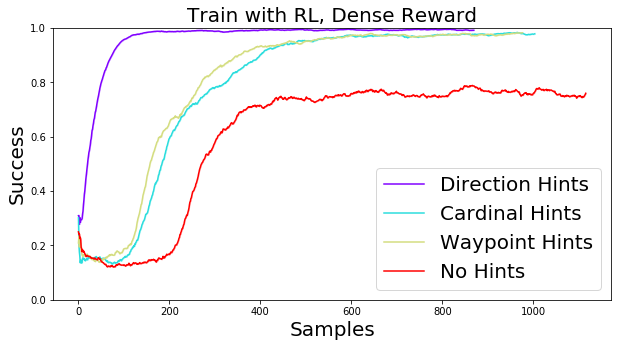

CSV meta-mb-internal/data/T3605_1/progress.csv
LENGTHS [870]
CSV meta-mb-internal/data/T3606_1/progress.csv
LENGTHS [1004]
CSV meta-mb-internal/data/T3607_1/progress.csv
LENGTHS [977]
CSV meta-mb-internal/data/T3608_1/progress.csv
LENGTHS [1116]


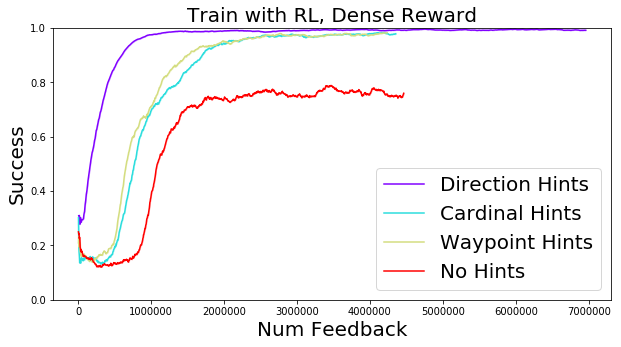

In [113]:
metrics = [
    'Train/Success',
]


# data_names = [
    
#         (['T3471'], 'Direction Hints'),
#         (['T3472'], 'Cardinal Hints'),
#         (['T3473'], 'Waypoint Hints'),
# #         (['T3473'], 'Landmark Hints'),
#         (['T3474'], 'No Hints'),
    
    
#     ]


data_names = [
    
        (['T3605'], 'Direction Hints'),
        (['T3606'], 'Cardinal Hints'),
        (['T3607'], 'Waypoint Hints'),
#         (['T3473'], 'Landmark Hints'),
        (['T3608'], 'No Hints'),
    
    
    ]


plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")

plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")




## Experimental

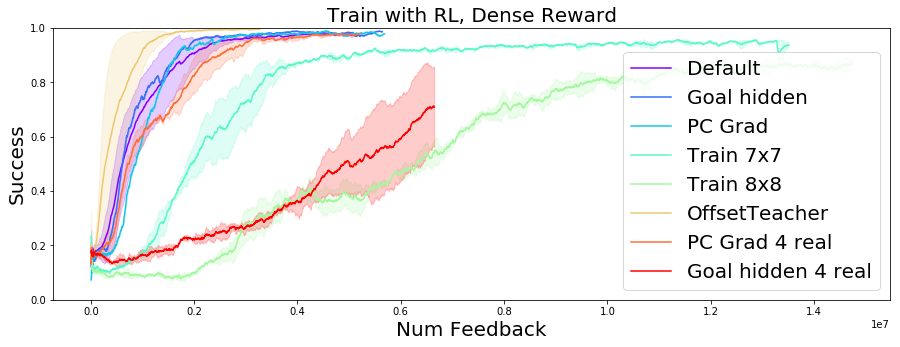

In [45]:
# All waypoint variants
metrics = [
    'Train/Success',
]

data_names = [
        (['T3675'], 'Default'),
        (['T3705_1'], 'Goal hidden'),
        (['T3705_2'], 'PC Grad'),
        (['T3707'], 'Train 7x7'),
        (['T3708'], 'Train 8x8'),
        (['T3709'], 'OffsetTeacher'),
        (['T3738'], 'PC Grad 4 real'),
        (['T3737'], 'Goal hidden 4 real'),
    ]
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")



## Final

RUN NAMES ['K000', 'K001', 'K002']
LENGTHS [1120, 1085, 1111]
setting color [0.5 0.  1.  1. ]
RUN NAMES ['K003', 'K004', 'K005']
LENGTHS [1186, 1192, 1158]
setting color [0.24901961 0.38410575 0.98063477 1.        ]
RUN NAMES ['K006', 'K007', 'K008']
LENGTHS [4186, 4239, 4173]
setting color [0.00196078 0.70928131 0.92328911 1.        ]
RUN NAMES ['K009', 'K010', 'K011']
LENGTHS [1112, 1140, 1109]
setting color [0.25294118 0.92563766 0.83018403 1.        ]
RUN NAMES ['K015', 'K016', 'K017']
LENGTHS [10470, 15831, 15694]
setting color [0.6, 0.6, 0.6, 1]
RUN NAMES ['K012', 'K013', 'K014']
LENGTHS [9752, 9550, 9960]
setting color [0.5, 0.5, 0.5, 1]
RUN NAMES ['K018', 'K019', 'K020']
LENGTHS [1043, 1009, 1044]
setting color [0.4, 0.4, 0.4, 1]
RUN NAMES ['K348', 'K349', 'K350']
LENGTHS [202, 200, 190]
setting color [0.3, 0.3, 0.3]
RUN NAMES ['K345', 'K346', 'K347']
LENGTHS [259, 251, 249]
setting color [0, 0, 0, 1]


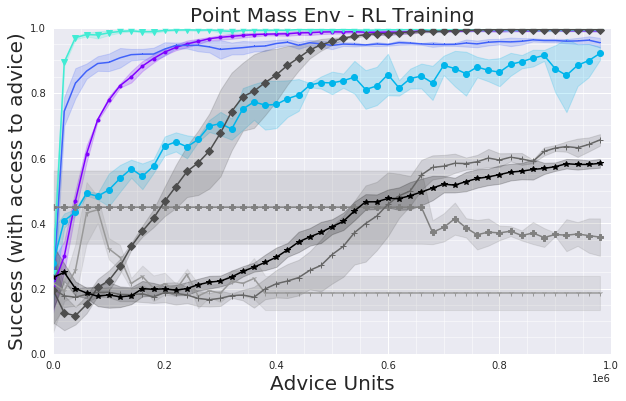

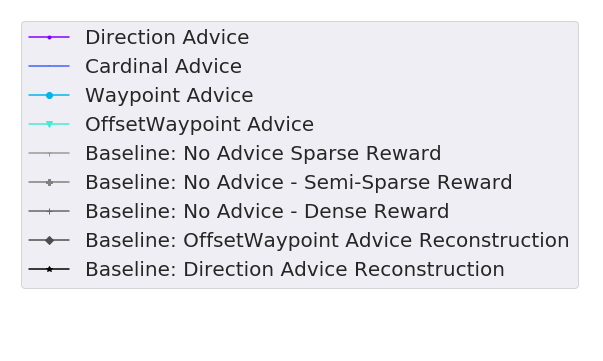

In [229]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'

data_names = [
        (['K000', 'K001', 'K002'], 'Direction Advice', None, '.'),
        (['K003', 'K004', 'K005'], 'Cardinal Advice', None, ','),
        (['K006', 'K007', 'K008'], 'Waypoint Advice', None, 'o'),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', None, 'v'),
#         (['K000', 'K001', 'K002'], 'Direction Advice', [0, 0, .5, 1], '.'),
#         (['K003', 'K004', 'K005'], 'Cardinal Advice', [0, 0, .7, 1], ','),
#         (['K006', 'K007', 'K008'], 'Waypoint Advice', [0, 0, 1, 1], 'o'),
#         (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', [0, 0, 1, 1], 'v'),
        (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward', [.6, 0.6, 0.6, 1], '1'),
        (['K012', 'K013', 'K014'], 'Baseline: No Advice - Semi-Sparse Reward', [.5, 0.5, 0.5, 1], 'P'),
        (['K018', 'K019', 'K020'], 'Baseline: No Advice - Dense Reward', [.4, 0.4, 0.4, 1], '+'),
        (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction', [.3, 0.3, 0.3], 'D'),
        (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction', [0, 0, 0, 1], '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm.png', x_min=0, x_max=1000000)

# data_names = [
#         (['K000', 'K001', 'K002'], 'Direction Advice',),
#         (['K003', 'K004', 'K005'], 'Cardinal Advice'),
#         (['K006', 'K007', 'K008'], 'Waypoint Advice'),
#         (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice'),
#         (['K012', 'K013', 'K014'], 'Baseline: No Advice - Semi-Sparse Reward'),
#         (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward'),
#         (['K018', 'K019', 'K020'], 'Baseline: No Advice - Dense Reward'),
#         (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction'),
#         (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction'),
#     ]

# plt.xlim(0, 1000000)
# plot_curriculum(data_names, x_label, 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=1, y_label="Success Rate",
#                save_name='rl_train_pm.png')


# plot_curriculum(data_names, 'samples', 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=1, y_label="Success Rate")



In [ ]:
- Make black more gray
- Add legend 

# <font color='green'>  PM-D: Train with other reward types </font>

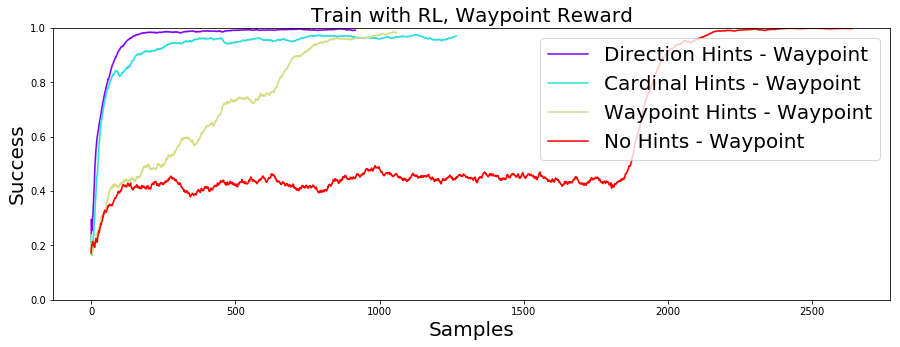

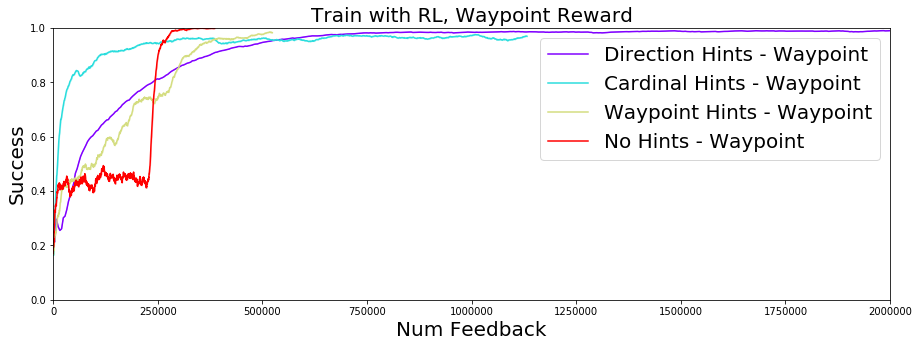

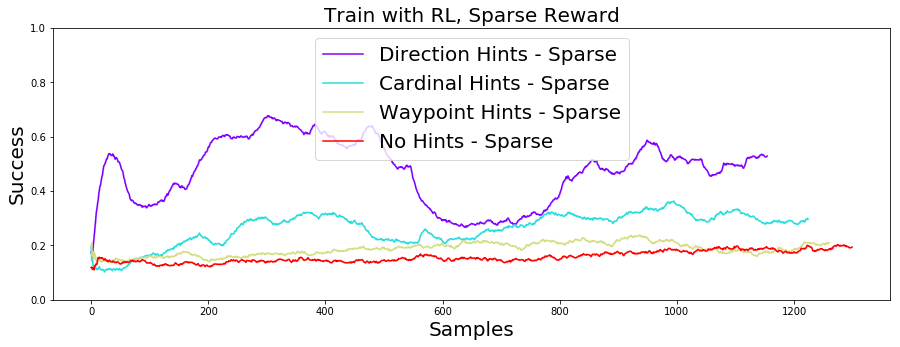

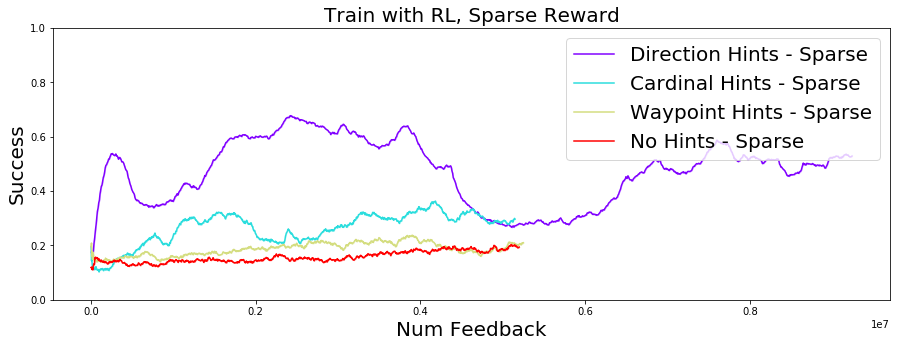

In [81]:

data_names = [
    
#         (['T3605'], 'Direction Hints - Dense'),
#         (['T3606'], 'Cardinal Hints - Dense'),
#         (['T3607'], 'Waypoint Hints - Dense'),
#         (['T3608'], 'No Hints - Dense'),

        (['T3613'], 'Direction Hints - Waypoint'),
        (['T3614'], 'Cardinal Hints - Waypoint'),
        (['T3615'], 'Waypoint Hints - Waypoint'),
        (['T3616'], 'No Hints - Waypoint'),
    
    ]

# kangaroo

plt.rcParams['figure.figsize'] = [15, 5]
plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Waypoint Reward",
               y_lower=0, y_upper=1, y_label="Success")
plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Waypoint Reward",
               y_lower=0, y_upper=1, y_label="Success")



print("=" * 500)




data_names = [
    # These are all bad!
        (['T3609'], 'Direction Hints - Sparse'),
        (['T3610'], 'Cardinal Hints - Sparse'),
        (['T3611'], 'Waypoint Hints - Sparse'),
        (['T3612'], 'No Hints - Sparse'),
    
    
    ]


plt.rcParams['figure.figsize'] = [15, 5]
plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Sparse Reward",
               y_lower=0, y_upper=1, y_label="Success")
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Sparse Reward",
               y_lower=0, y_upper=1, y_label="Success")


# <font color='green'> PM-E: Bootstrap feedback forms </font>

## Experimental

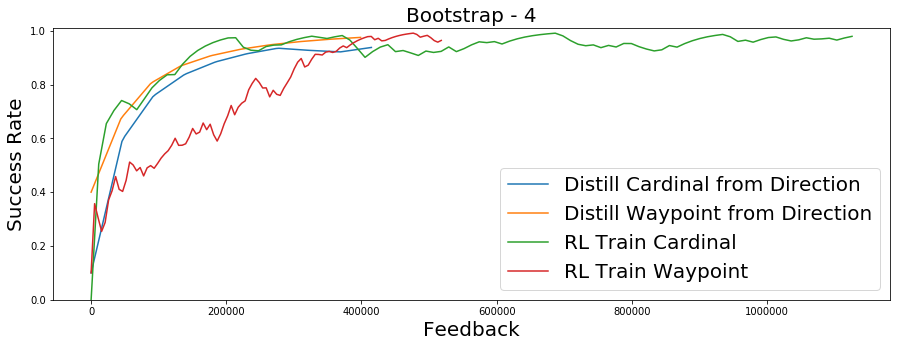

In [31]:
plt.rcParams['figure.figsize'] = [15, 5]

x_label = 'Feedback'

# L4
runs = [
    (['T3840'], 'Distill Cardinal from Direction', 1),
    (['T3841'], 'Distill Waypoint from Direction', 1),
    (['T3614'], 'RL Train Cardinal', 1),
    (['T3615'], 'RL Train Waypoint', 1),
]
# plt.xlim(0, 100000)
plot_finetune_generalization(runs, 'Bootstrap', smooth=10, x_label=x_label, y_label="Success Rate")



## Final

LENGTHS [4696291, 4564532, 4700783]
LENGTHS [1237347, 1241609, 1236065]


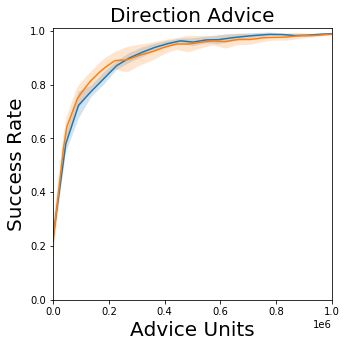

MAX 0.9999581183870637
MAX 0.9924183539510336


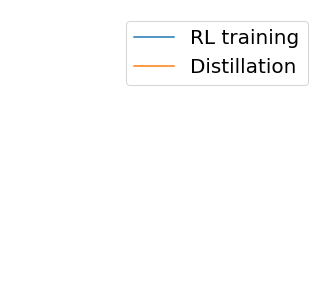

LENGTHS [1078277, 1117491, 992818]
LENGTHS [275090, 269042, 295891]


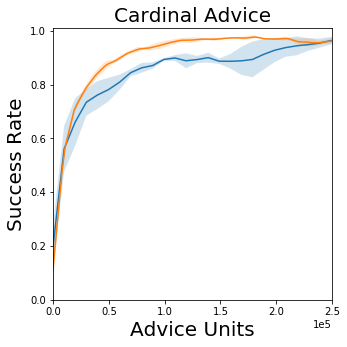

MAX 0.9761527948805188
MAX 0.9765148717552862


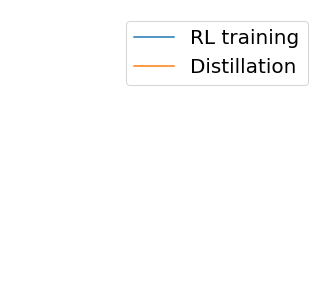

LENGTHS [2304374, 2324235, 2322814]
LENGTHS [1182558, 869910, 946990]


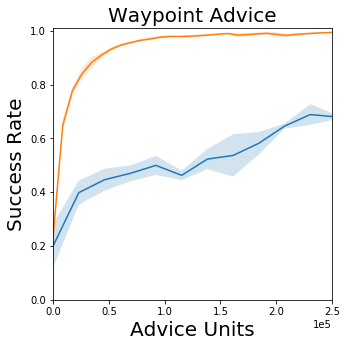

MAX 0.9976938609928546
MAX 0.9985872329027551


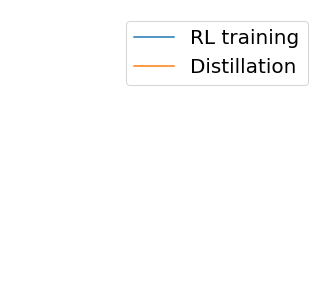

In [9]:
plt.rcParams['figure.figsize'] = [5, 5]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

runs = [
        (['K000', 'K001', 'K002'], 'RL training'),
        (['K144', 'K145', 'K146'], 'Distillation'),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction Advice', smooth=10, x_label=x_label, y_label="Success Rate")



runs = [
        (['K003', 'K004', 'K005'], 'RL training'),
        (['K147', 'K148', 'K149'], 'Distillation'),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal Advice', smooth=10, x_label=x_label, y_label="Success Rate")


runs = [
        (['K006', 'K007', 'K008'], 'RL training'),
        (['K150', 'K151', 'K152'], 'Distillation'),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint Advice', smooth=10, x_label=x_label, y_label="Success Rate")


#  <font color='green'> PM-F: 0-shot solving Held-out Levels </font>

What we still need:
- Final hparams
- More seeds

Takeaway: using hints, we can 0-shot solve new levels.

## Experiments

ENV DICT dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


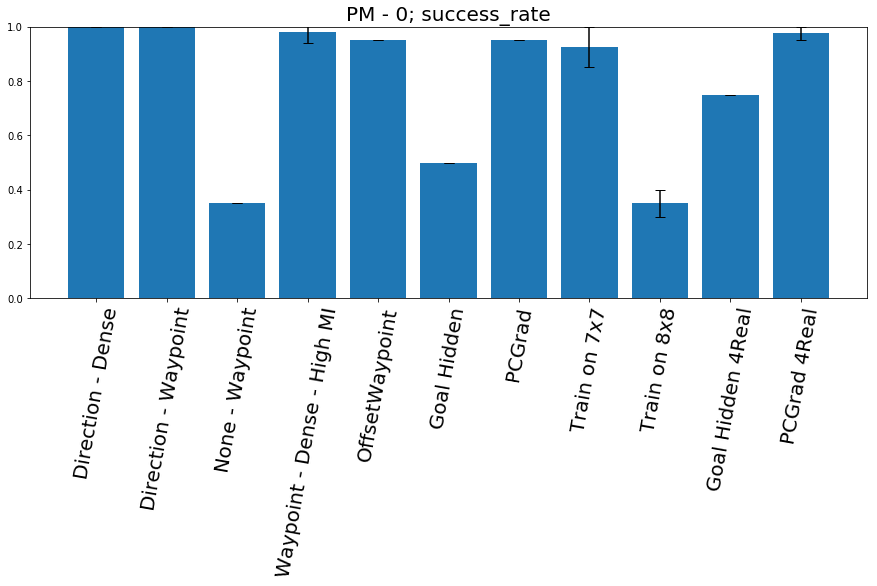

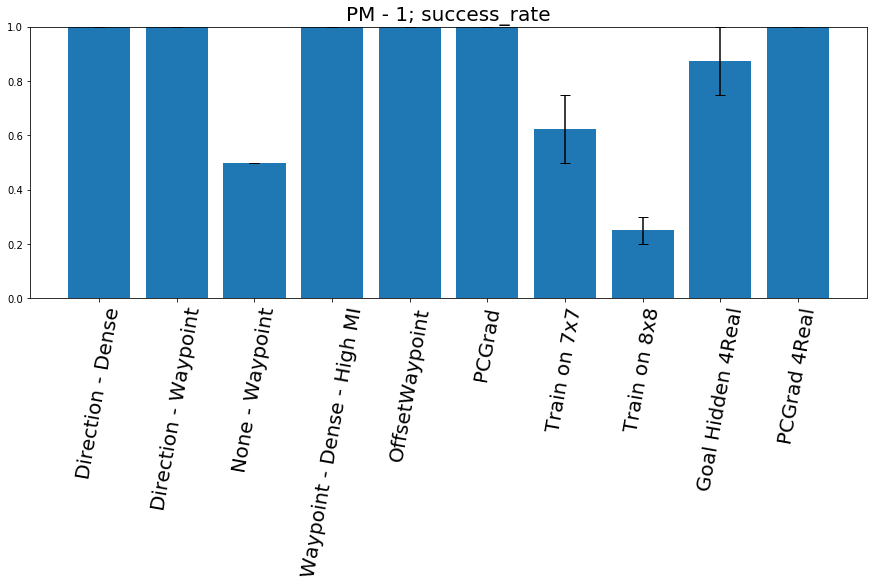

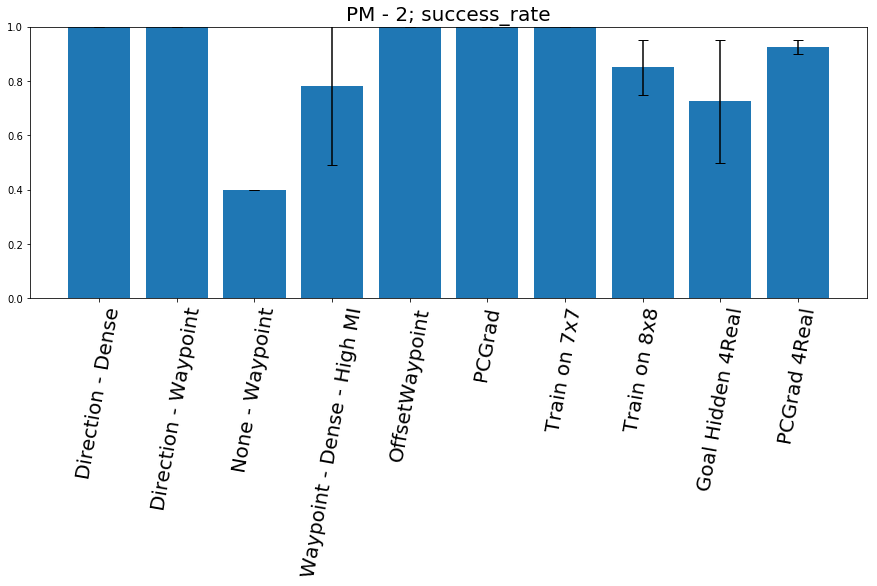

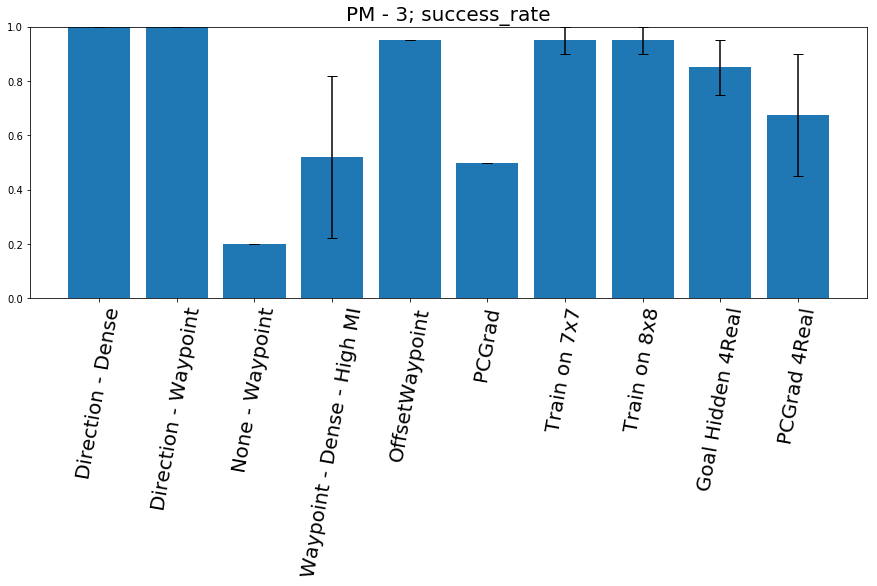

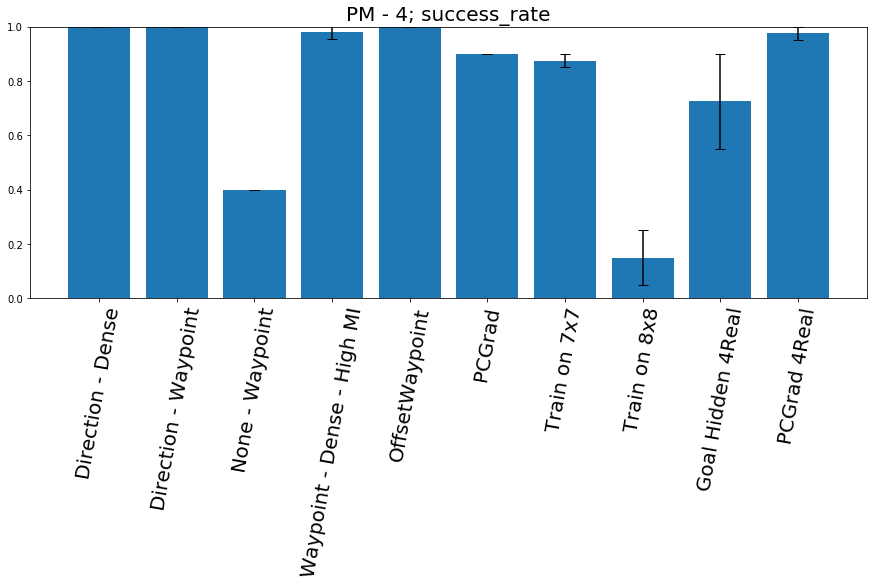

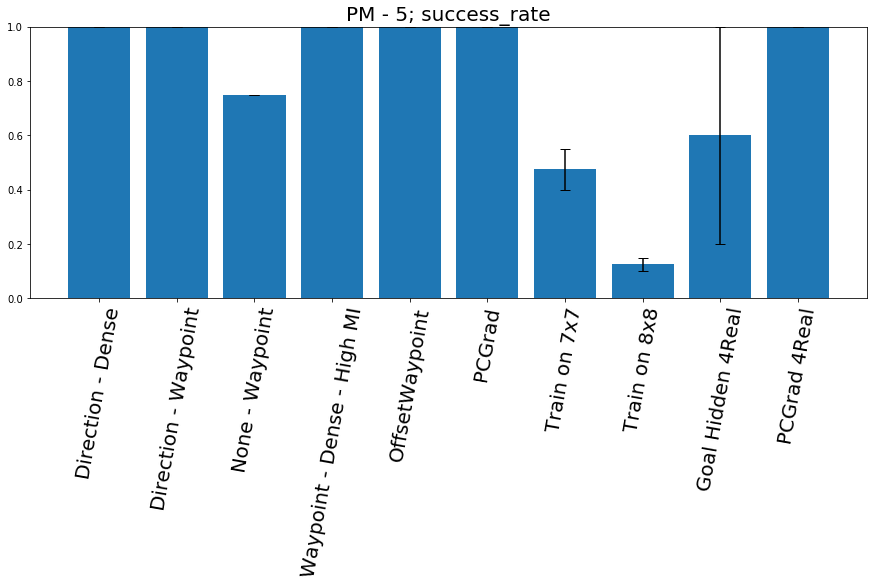

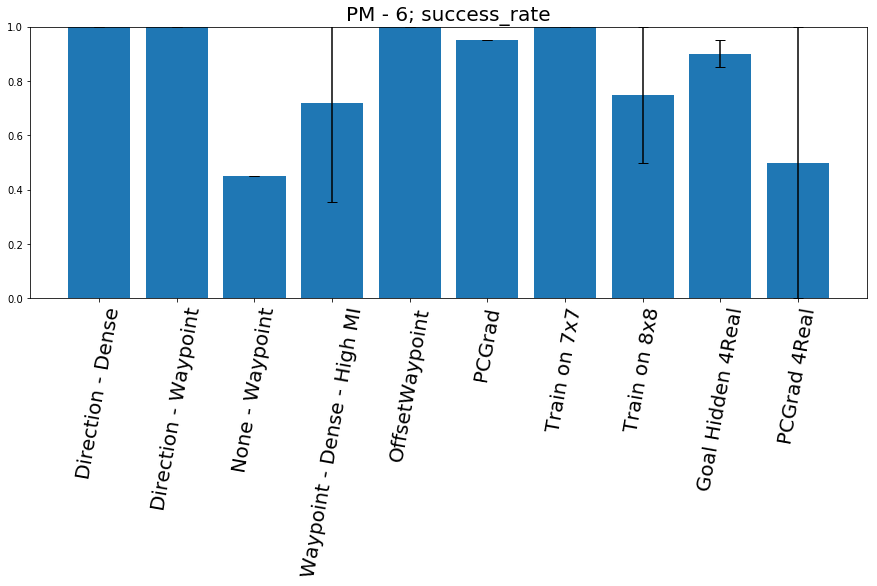

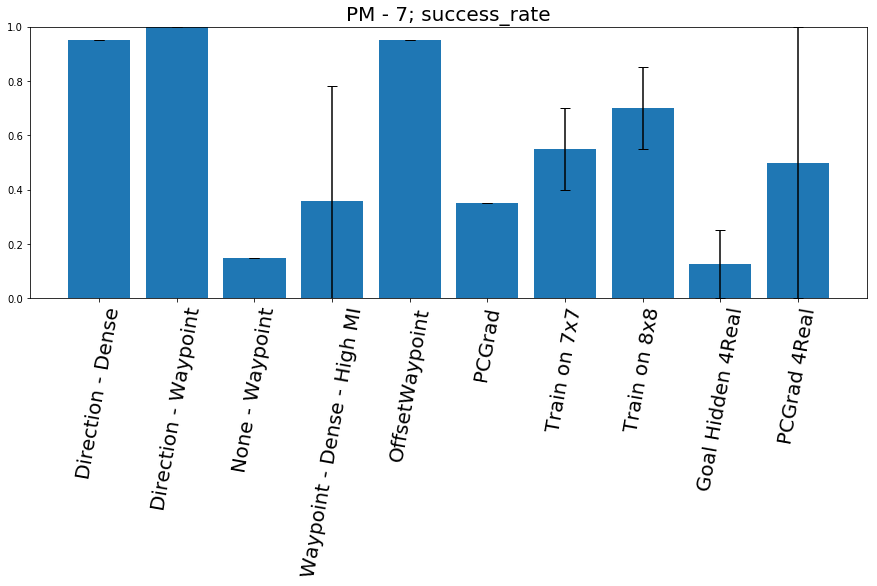

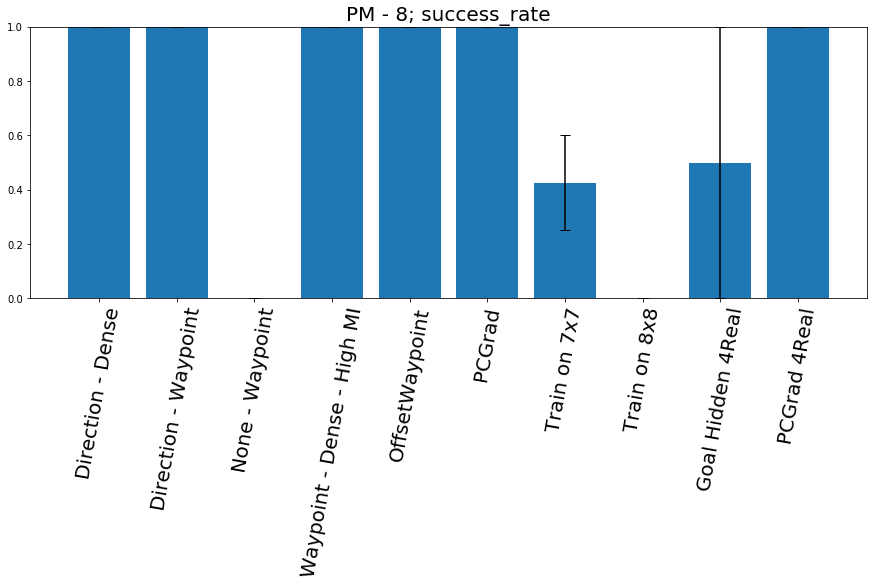

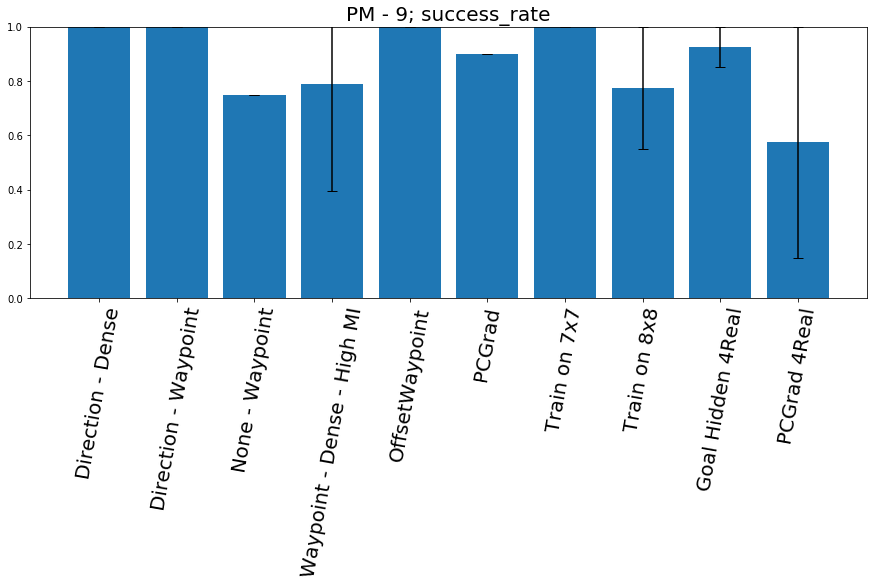

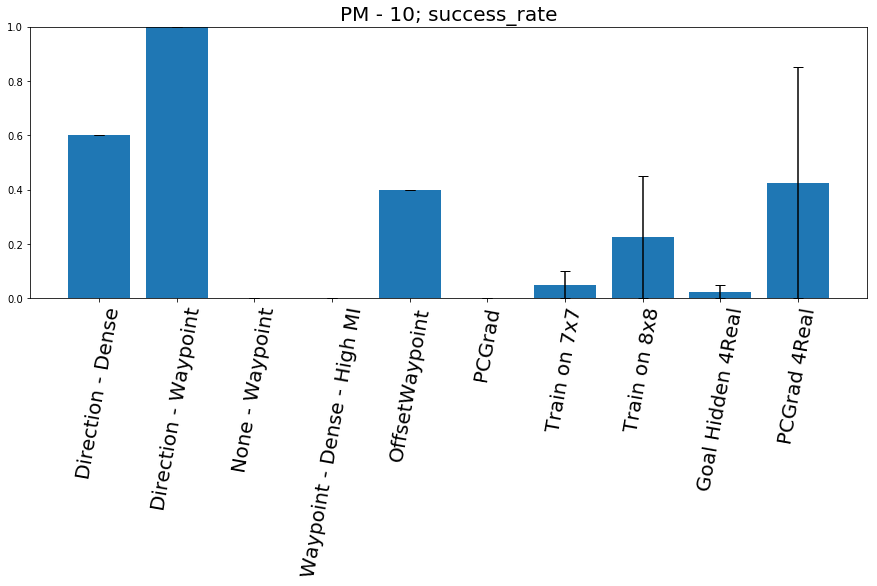

In [52]:
# Before hparam tuning
# runs = [
#     (['T3579'], 'Waypoint'),
#     (['T3580'], 'Direction'),
#     (['T3581'], 'Cardinal'),
#     (['T3582'], 'None'),
# ]
# plot_final_generalization(runs, 'PM')


# After hparam tuning
runs = [
    (['T3618'], 'Direction - Dense'),
#     (['T3619'], 'Cardinal - Dense'),
#     (['T3620'], 'Waypoint - Dense'),
#     (['T3621'], 'None - Dense'),
    
    (['T3622'], 'Direction - Waypoint'),
#     (['T3623'], 'Cardinal - Waypoint'),
#     (['T3624'], 'Waypoint - Waypoint'),
    (['C3625'], 'None - Waypoint'),
    
    
    
#     (['T3620'], 'Waypoint - Dense'),
#     (['T3624'], 'Waypoint - Waypoint'),
#     (['T3679'], 'Waypoint - Dense (continued)'),
#     (['T3680'], 'Waypoint - Waypoint (continued)'),
#     (['T3681' 'T3682'], 'Waypoint - Dense (low maze mag)'),
#     (['T3683', 'T3684'], 'Waypoint - Waypoint (low maze mag)'),
    
    
#     (['T3695'], 'Waypoint - Dens - High E'),
#     (['T3696'], 'Waypoint - Waypoint - High E'),
    (['T3697', 'T3732', 'T3733', 'T3734', 'T3735'], 'Waypoint - Dense - High MI'),
#     (['T3698'], 'Waypoint - Waypoint- High MI'),
#     (['T3699'], 'Waypoint - Dense - Small model'),
#     (['T3700'], 'Waypoint - Waypoint - Small model'),
    
#     (['T3701' 'T3702'], 'Waypoint - Dense (old hparams)'),
#     (['T3703', 'T3704'], 'Waypoint - Waypoint (old hparams)'),
    
    
    # Finetuned runs
#     (['T3685', 'T3686'], 'Waypoint - Dense - L3'),
#     (['T3687', 'T3688'], 'Waypoint - Waypoint - L3'),
#     (['T3689', 'T3690'], 'Waypoint - Dense - L6'),
#     (['T3691', 'T3692'], 'Waypoint - Waypoint - L6'),
    
    # More Waypoint variants
    (['T3727'], 'OffsetWaypoint'),
    (['T3728'], 'Goal Hidden'),
    (['T3729'], 'PCGrad'),
    (['T3745', 'T3746'], 'Train on 7x7'),
    (['T3747', 'T3748'], 'Train on 8x8'),
    (['T3749', 'T3750'], 'Goal Hidden 4Real'),
    (['T3751', 'T3752'], 'PCGrad 4Real'),
    
    
    
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, 'PM')

In [ ]:
self.train_levels = [
                PointMassEnv(f'maze2d-open-{reward_env_name}-v0', reward_type=reward_type, **kwargs),  # 0
                PointMassEnv(f'maze2d-umaze-{reward_env_name}-v1', reward_type=reward_type, **kwargs),  # 1
                PointMassEnv(f'maze2d-medium-{reward_env_name}-v1', reward_type=reward_type, **kwargs),  # 2
            ]
            self.held_out_levels = [
                PointMassEnv(f'maze2d-large-{reward_env_name}-v1', reward_type=reward_type, **kwargs),  # 3
                PointMassEnv('maze2d-randommaze-v0', reward_type=reward_type, **kwargs),  # 4
                PointMassEnv(f'maze2d-umaze-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,   # 5
                             **kwargs),
                PointMassEnv(f'maze2d-medium-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 6
                             **kwargs),
                PointMassEnv(f'maze2d-large-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 7
                             **kwargs),
                PointMassEnv(f'maze2d-umaze-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 8
                             reset_start=False, **kwargs),
                PointMassEnv(f'maze2d-medium-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 9
                             reset_start=False, **kwargs),
                PointMassEnv(f'maze2d-large-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 10
                             reset_start=False, **kwargs),
            ]

## Final

ENV DICT dict_keys([2, 3, 13, 14])


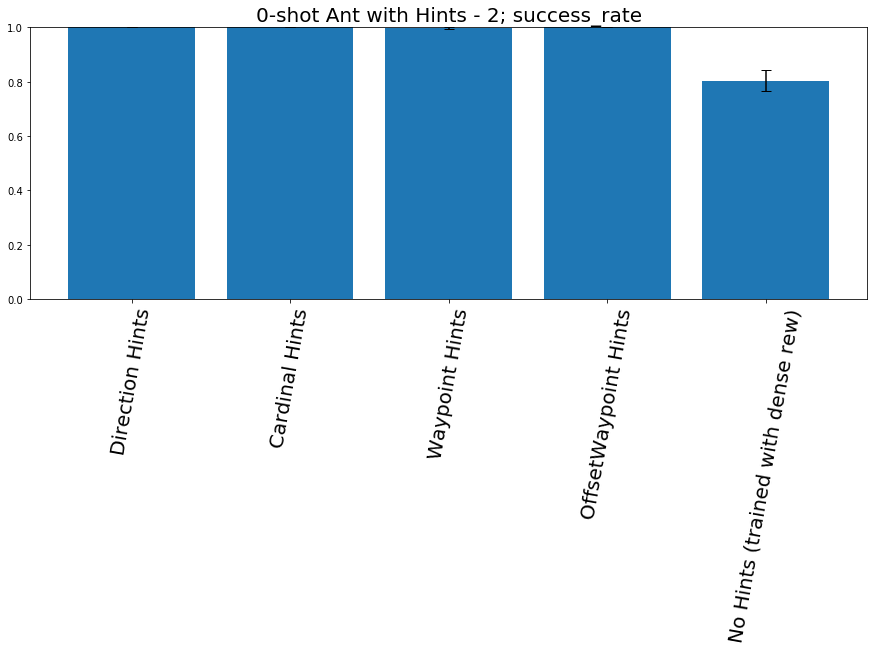

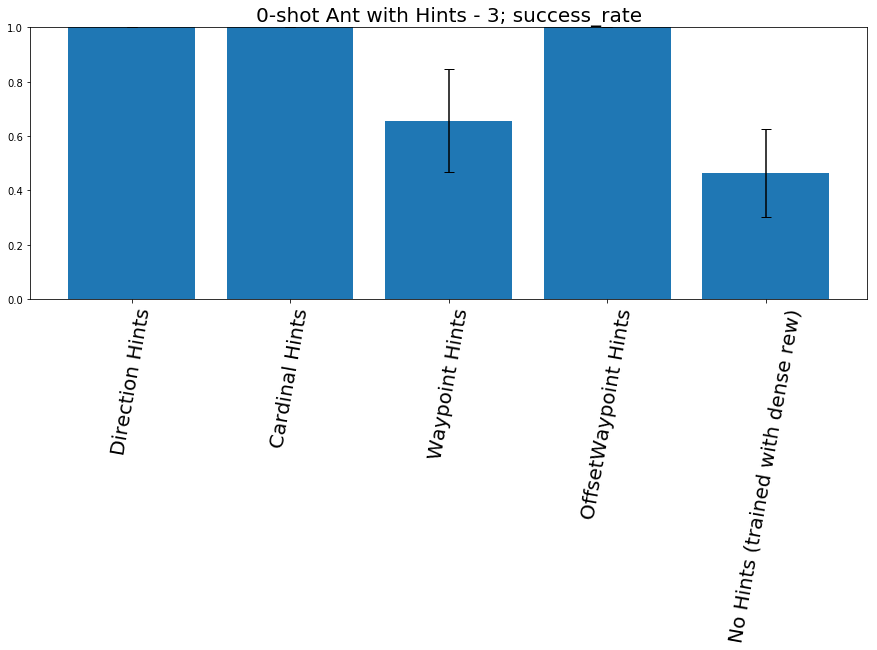

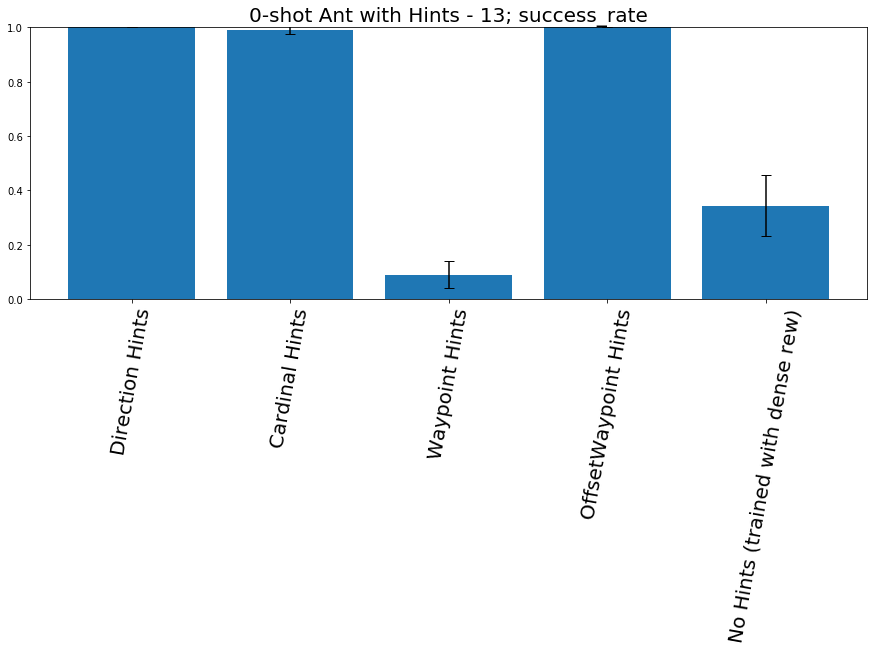

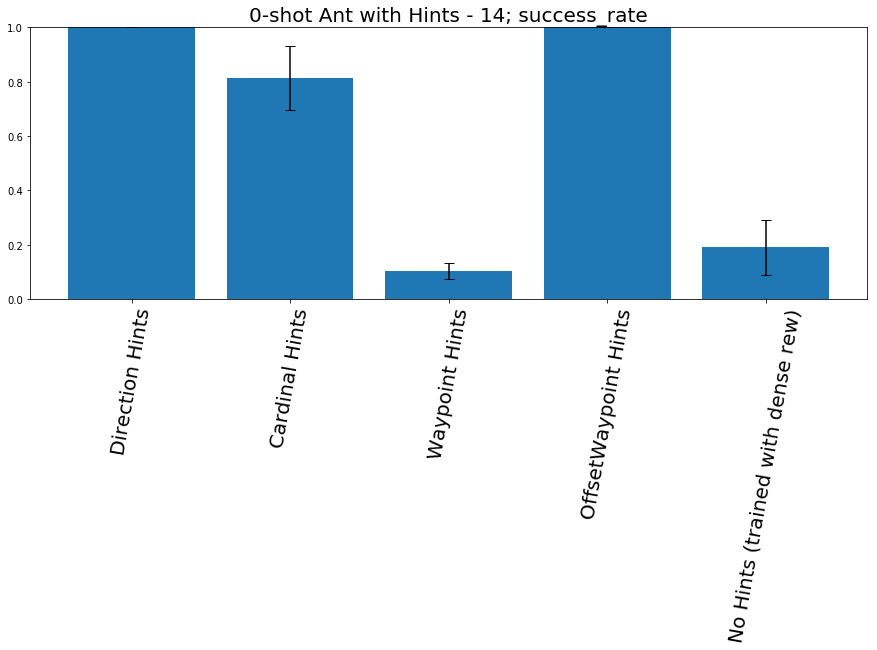

In [7]:
runs = [
    (['K024', 'K025', 'K026'], 'Direction Hints'),
    (['K027', 'K028', 'K029'], 'Cardinal Hints'),
    (['K030', 'K031', 'K032'], 'Waypoint Hints'),
    (['K033', 'K034', 'K035'], 'OffsetWaypoint Hints'),
#     (['K036', 'K037', 'K038'], 'No Hints (trained with waypoint rew)'),
#     (['K039', 'K040', 'K041'], 'No Hints (trained with sparse rew)'),
    (['K042', 'K043', 'K044'], 'No Hints (trained with dense rew)'),
    
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Ant with Hints')

# <font color='green'> PM-G: Distilling on held-out levels </font>

## Old

CSV meta-mb-internal/eval_runs/T3537/PolicyT3462_1-3_checkpoint0/results.csv
CSV meta-mb-internal/old_data/T3528_1/PolicyT3528-3_checkpoint1/results.csv


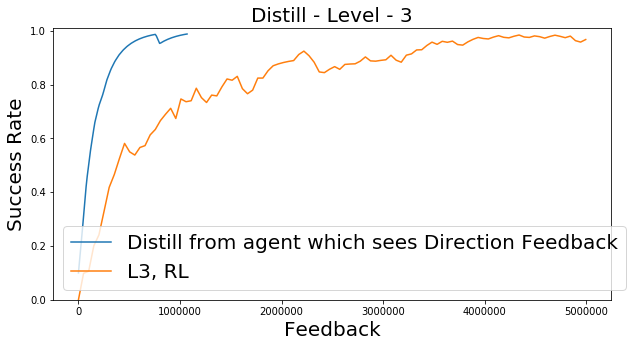

CSV meta-mb-internal/eval_runs/T3537/PolicyT3462_1-3_checkpoint0/results.csv
CSV meta-mb-internal/old_data/T3528_1/PolicyT3528-3_checkpoint1/results.csv


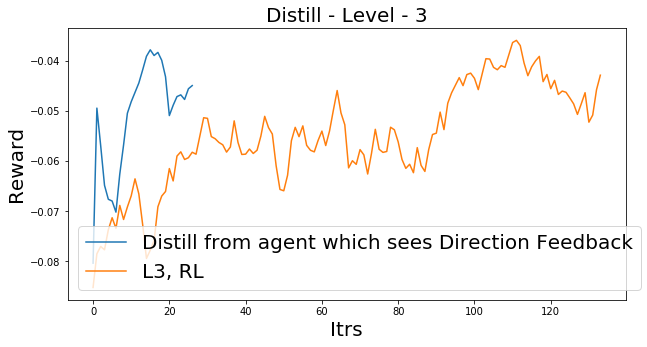

CSV meta-mb-internal/eval_runs/T3535/PolicyT3462_1-7_checkpoint0/results.csv
CSV meta-mb-internal/eval_runs/T3536/PolicyT3462_1-10_checkpoint0/results.csv
CSV meta-mb-internal/old_data/T3529_1/PolicyT3529-7_checkpoint1/results.csv
CSV meta-mb-internal/old_data/T3530_1/PolicyT3530-10_checkpoint1/results.csv


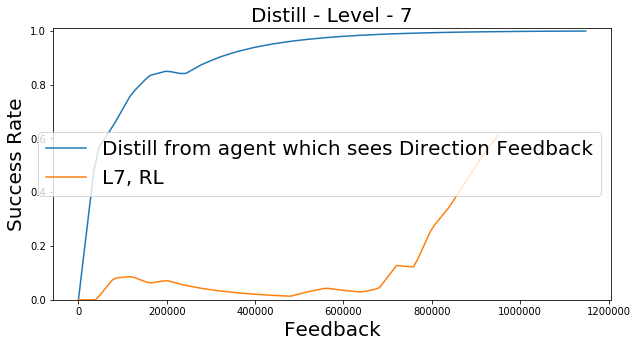

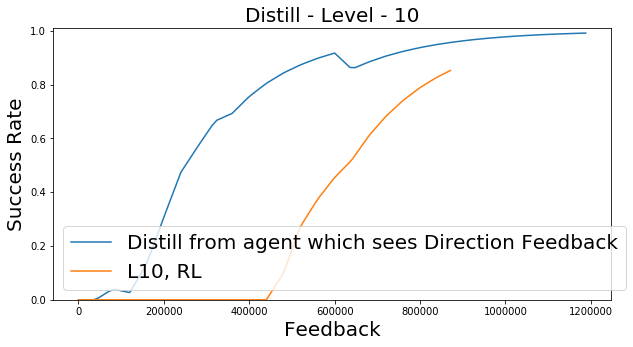

CSV meta-mb-internal/eval_runs/T3535/PolicyT3462_1-7_checkpoint0/results.csv
CSV meta-mb-internal/eval_runs/T3536/PolicyT3462_1-10_checkpoint0/results.csv
CSV meta-mb-internal/old_data/T3529_1/PolicyT3529-7_checkpoint1/results.csv
CSV meta-mb-internal/old_data/T3530_1/PolicyT3530-10_checkpoint1/results.csv


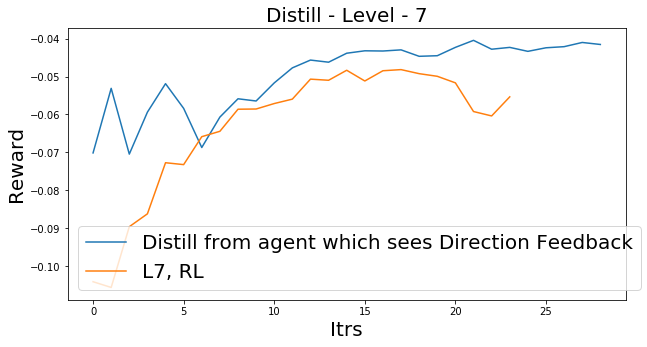

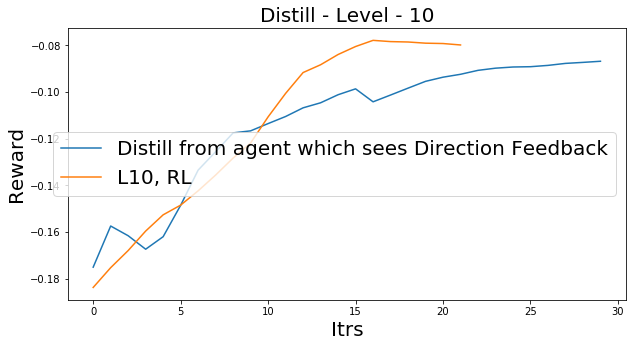

In [109]:
num_envs = 20
frames_per_proc = 200
itr_skip = 10
scale = num_envs * frames_per_proc * itr_skip

runs = [
    (['T3537'], 'Distill from agent which sees Direction Feedback', 1),
    (['T3528'], 'L3, RL', 1),
    
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', 
                             y_label="Success Rate")
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Itrs', 
                             y_label="Reward", metric='reward')



# CURRENT #KANGAROO
num_envs = 20
frames_per_proc = 200
itr_skip = 10
scale = num_envs * frames_per_proc * itr_skip

runs = [
    (['T3535'], 'Distill from agent which sees Direction Feedback', 1),
    (['T3536'], 'Distill from agent which sees Direction Feedback', 1),
    
    (['T3529'], 'L7, RL', 1),
    (['T3530'], 'L10, RL', 1),
    
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', 
                             y_label="Success Rate")
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Itrs', 
                             y_label="Reward", metric='reward')

# plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=10, x_label='Itrs', 
#                              y_label="Success Rate")

## Current

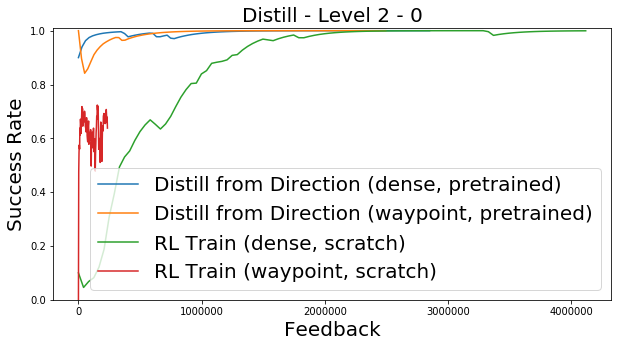

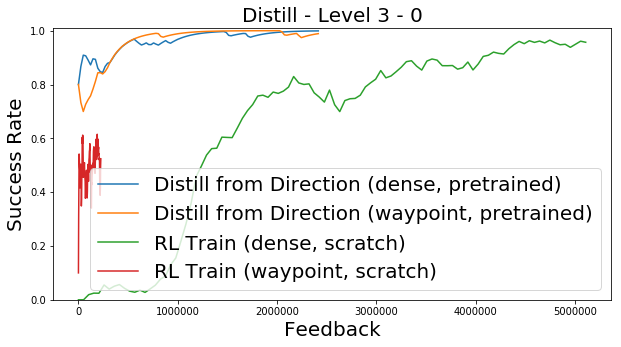

Error on  ['T3643'] single positional indexer is out-of-bounds


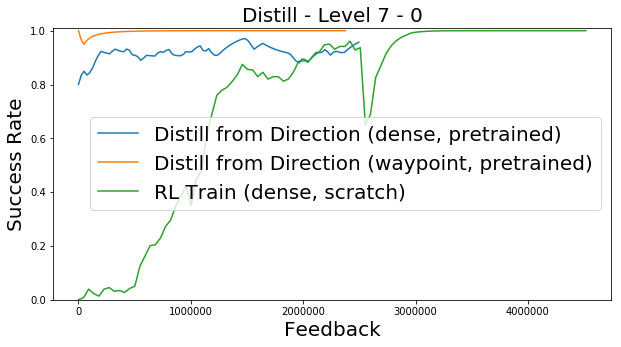

Error on  ['T3644'] single positional indexer is out-of-bounds


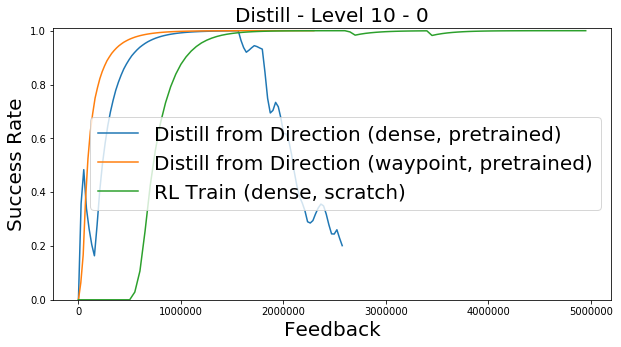

In [168]:
plt.rcParams['figure.figsize'] = [10, 5]

runs = [
    (['T3626'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3630'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3637'], 'RL Train (dense, scratch)', 1),
    (['T3641'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 2', smooth=10, x_label='Feedback', y_label="Success Rate")

runs = [
    (['T3627'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3631'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3638'], 'RL Train (dense, scratch)', 1),
    (['T3642'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 3', smooth=10, x_label='Feedback', y_label="Success Rate")

runs = [
    (['T3628'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3632'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3639'], 'RL Train (dense, scratch)', 1),
    (['T3643'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 7', smooth=10, x_label='Feedback', y_label="Success Rate")

runs = [
    (['T3629'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3633'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3640'], 'RL Train (dense, scratch)', 1),
    (['T3644'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 10', smooth=10, x_label='Feedback', y_label="Success Rate")


## Experimental

LENGTHS [456000]
LENGTHS [99421]
LENGTHS [65324]
LENGTHS [2120000]


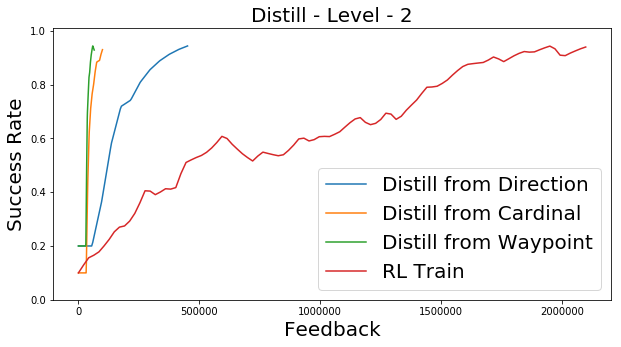

LENGTHS [430144]
LENGTHS [151982]
LENGTHS [150394]
LENGTHS [213923]


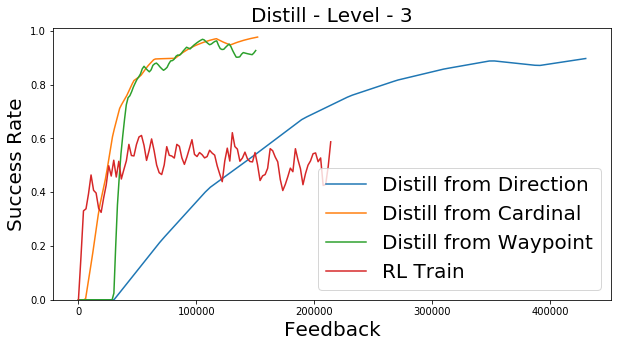

In [85]:
plt.rcParams['figure.figsize'] = [10, 5]

x_label = 'Feedback'

# L2
runs = [
    (['T3811'], 'Distill from Direction', 1),
    (['T3812'], 'Distill from Cardinal', 1),
    (['T3813'], 'Distill from Waypoint', 1),
    (['T3814'], 'RL Train', 1),
]
# plt.xlim(0, 100000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")



# L3
runs = [
    (['T3757'], 'Distill from Direction', 1),
    (['T3761'], 'Distill from Cardinal', 1),
#     (['T3842'], 'Distill from Cardinal (Dir finetune) (sparse, scratch)', 1),
#     (['T3713'], 'Distill from Waypoint (dense, scratch)', 1),
    (['T3714'], 'Distill from Waypoint', 1),
#     (['T3843'], 'Distill from Waypoint, finetune Dir', 1),
#     (['T3715'], 'Distill from Waypoint, finetune Dir', 1),
#     (['T3638'], 'RL Train (dense, scratch)', 1),
#     (['T3642'], 'RL Train (sparse, scratch)', 1),
    (['T3773'], 'RL Train', 1),
#     (['T3765'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3654'], 'RL Train (dense, pretrained)', 1),
#     (['T3658'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3779'], 'Distill from oracle (waypoint hints, scratch)', 1),
]

# runs = [
#     (['T3757'], 'Distill from Direction Hints', 1),
#     (['T3761'], 'Distill from Cardinal Hints', 1),
# #     (['T3713'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3714'], 'Distill from Waypoint Hints', 1),
# #     (['T3715'], 'Distill from Waypoint, finetune Dir', 1),
#     (['T3638'], 'RL Train, no hints (dense reward)', 1),
#     (['T3642'], 'RL Train, no hints (sparse reward)', 1),
# #     (['T3765'], 'RL Train (waypoint, pretrained)', 1),
# #     (['T3654'], 'RL Train (dense, pretrained)', 1),
# #     (['T3658'], 'RL Train (waypoint, pretrained)', 1),
# ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label=x_label, y_label="Success Rate")

# # L6
# runs = [
#     (['T3758'], 'Distill from Direction (sparse, scratch)', 1),
#     (['T3762'], 'Distill from Cardinal (sparse, scratch)', 1),
# #     (['T3802'], 'Distill from Cardinal rsample', 1),
# #     (['T3803'], 'Distill from Cardinal log_prob', 1),
# #     (['T3716'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3717'], 'Distill from Waypoint, finetune RL', 1),
# #     (['T3718'], 'Distill from Waypoint, finetune Dir', 1),
# #     (['T3625'], 'RL Train (dense, scratch)', 1),
#     (['T3774'], 'RL Train (sparse, scratch)', 1),
#     (['T3780'], 'Distill from oracle (waypoint hints, scratch)', 1),
# ]
# # plt.xlim(0, 100000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")

# # L7
# runs = [
#     (['T3759'], 'Distill from Direction (sparse, scratch)', 1),
#     (['T3763'], 'Distill from Cardinal (sparse, scratch)', 1),
# #     (['T3804'], 'Distill from Cardinal rsample', 1),
# #     (['T3805'], 'Distill from Cardinal log_prob', 1),
# #     (['T3719'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3720'], 'Distill from Waypoint, finetune RL', 1),
# #     (['T3721'], 'Distill from Waypoint, finetune Dir', 1),
# #     (['T3639'], 'RL Train (dense, scratch)', 1),
# #     (['T3655'], 'RL Train (dense, pretrained)', 1),
# #     (['T3659'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3775'], 'RL Train (sparse, scratch)', 1),
#     (['T3781'], 'Distill from oracle (waypoint hints, scratch)', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")

# # L10

# runs = [
#     (['T3760'], 'Distill from Direction (sparse, scratch)', 1),
#     (['T3764'], 'Distill from Cardinal (sparse, scratch)', 1),
# #     (['T3722'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3723'], 'Distill from Waypoint, finetune RL', 1),
# #     (['T3724'], 'Distill from Waypoint, finetune Dir', 1),
# #     (['T3640'], 'RL Train (dense, scratch)', 1),
# #     (['T3656'], 'RL Train (dense, pretrained)', 1),
# #     (['T3660'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3776'], 'RL Train (sparse, scratch)', 1),
#     (['T3782'], 'Distill from oracle (waypoint hints, scratch)', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")


In [137]:
# L3
runs = [
    (['K072_200'], '200', 1),
    (['K072_100'], '100', 1),
    (['K072_50'], '50', 1),
    (['K072_25'], '25', 1),
    (['K072_10b'], '10', 1),
]
# plt.xlim(0, 300000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=0.6, y_max=1)

plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
                             x_label='Itrs', y_label="Success Rate",
                            y_min=0.6, y_max=1)

runs = [
    (['K054_200'], '200', 1),
    (['K054_100'], '100', 1),
    (['K054_50'], '50', 1),
    (['K054_25'], '25', 1),
    (['K054_10b'], '10', 1),
]
# plt.xlim(0, 300000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=2, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=0.6, y_max=1)

plot_finetune_generalization(runs, 'Distill - Level', smooth=2, 
                             x_label='Itrs', y_label="Success Rate",
                            y_min=0.6, y_max=1)



Error on  ['K072_200'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_100'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_50'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_25'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_10b'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_200'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_100'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_50'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_25'] ("Didn't find exactly 1 run name", [])
Error on  ['K072_10b'] ("Didn't find exactly 1 run name", [])
Error on  ['K054_200'] ("Didn't find exactly 1 run name", [])
Error on  ['K054_100'] ("Didn't find exactly 1 run name", [])
Error on  ['K054_50'] ("Didn't find exactly 1 run name", [])
Error on  ['K054_25'] ("Didn't find exactly 1 run name", [])
Error on  ['K054_10b'] ("Didn't find exactly 1 run name", [])
Error on  ['K054_200'] ("Didn't find exactly 1 run name", [])
Error on  ['K0

## Final

ValueError: too many values to unpack (expected 2)

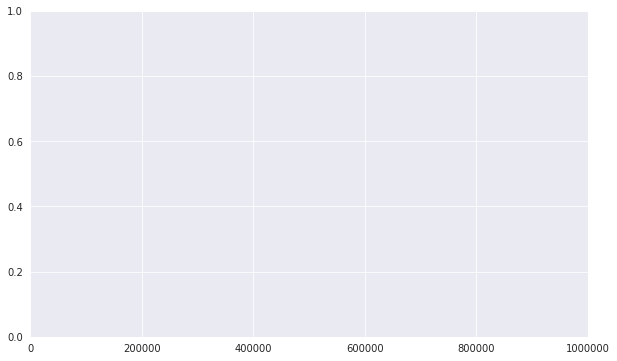

In [308]:
plt.rcParams['figure.figsize'] = [10, 6]
# L2 - from scratch
# runs = [
#     (['Q045', 'Q046', 'Q047'], 'Distill from Direction', 1),
#     (['Q048', 'Q049', 'Q050'], 'Distill from Cardinal', 1),
#     (['Q054', 'Q055', 'Q056'], 'Distill from OffsetWaypoint', 1),
# ]
# # plt.xlim(0, 100000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Feedback', y_label="Success Rate",
#                             y_min=0)

# # L2
# runs = [
#     (['K045', 'K046', 'K047'], 'Distill - Direction Advice', 1),
#     (['K048', 'K049', 'K050'], 'Distill - Cardinal Advice', 1),
#     (['K051', 'K052', 'K053'], 'Distill - Waypoint Advice', 1),
#     (['K054', 'K055', 'K056'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K066', 'K067', 'K068'], 'Distill - Demonstrations', 1),
# #     (['T3916'], 'RL Finetune (waypoint reward from scratch)', 1),
# #     (['K060', 'K061', 'K062'], 'RL Finetune (sparse reward)', 1),
#     (['K063', 'K064', 'K065'], 'RL Finetune - Dense Reward', 1),
#     (['K057', 'K058', 'K059'], 'RL Finetune - Semi-Sparse Reward', 1),
# #     (['K351', 'K352', 'K353'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
# #     (['K354', 'K355', 'K356'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
# ]

# plot_finetune_generalization(runs, 'Test Env 1', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0.5, y_max=1, save_name='distill_pm_l2.png',
#                             x_min=0, x_max=1000000)


# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', 1, None, None),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', 1, None, None),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', 1, None, None),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', 1, None, None),
    (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, None, None),
#     (['K084', 'K085', 'K086'], 'RL Finetune (sparse reward)', 1, None, None),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', 1, None, None),
    (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, None, None),
#     (['K357', 'K358', 'K359'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K360', 'K361', 'K362'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]
plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Test Env 2', smooth=10, 
                             x_label='Advice Units', y_label="Success Rate",
                            y_min=0.4, y_max=1, save_name='distill_pm_l3.png')


# # L13
# runs = [
#     (['K093', 'K094', 'K095'], 'Distill - Direction Advice', 1),
#     (['K096', 'K097', 'K098'], 'Distill - Cardinal Advice', 1),
#     (['K099', 'K100', 'K101'], 'Distill - Waypoint Advice', 1),
#     (['K102', 'K103', 'K104'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K114', 'K115', 'K116'], 'Distill - Demonstrations', 1),
# #     (['K105', 'K106', 'K107'], 'RL Finetune (waypoint reward)', 1),
# #     (['K108', 'K109', 'K110'], 'RL Finetune (sparse reward)', 1),
#     (['K111', 'K112', 'K113'], 'RL Finetune - Dense Reward', 1),
# #     (['K363', 'K364', 'K365'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
# #     (['K366', 'K367', 'K368'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
# ]
# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Test Env 3', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_pm_l13.png')


# # L14
# runs = [
#     (['K117', 'K118', 'K119'], 'Distill - Direction Advice', 1),
# #     (['K120', 'K121', 'K122'], 'Distill from Cardinal', 1),
#     (['K141', 'K142', 'K143'], 'Distill - Cardinal Advice', 1),
#     (['K123', 'K124', 'K125'], 'Distill - Waypoint Advice', 1),
#     (['K126', 'K127', 'K128'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K138', 'K139', 'K140'], 'Distill - Demonstrations', 1),
# #     (['K129', 'K130', 'K131'], 'RL Finetune (waypoint reward)', 1),
# #     (['K132', 'K133', 'K134'], 'RL Finetune (sparse reward)', 1),
#     (['K135', 'K136', 'K137'], 'RL Finetune - Dense Reward', 1),
# #     (['K369', 'K370', 'K371'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
# #     (['K372', 'K373', 'K374'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
# ]
# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Test Env 4', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_pm_l14.png')



# <font color='green'> ANT-C: RL train on Training Level </font>

## Official

[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3870/progress.csv'


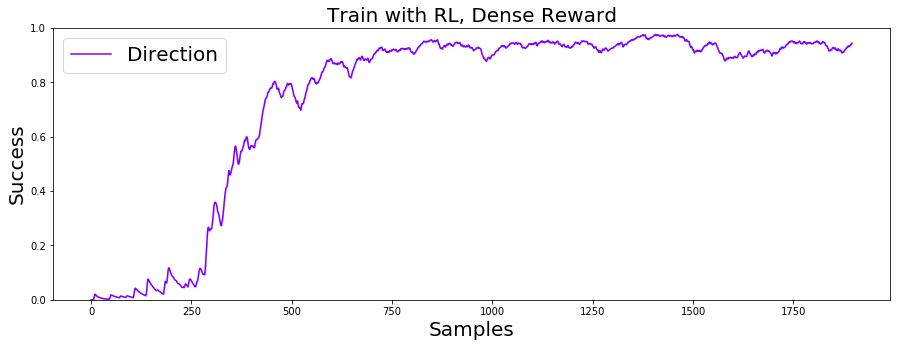

[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3870/progress.csv'


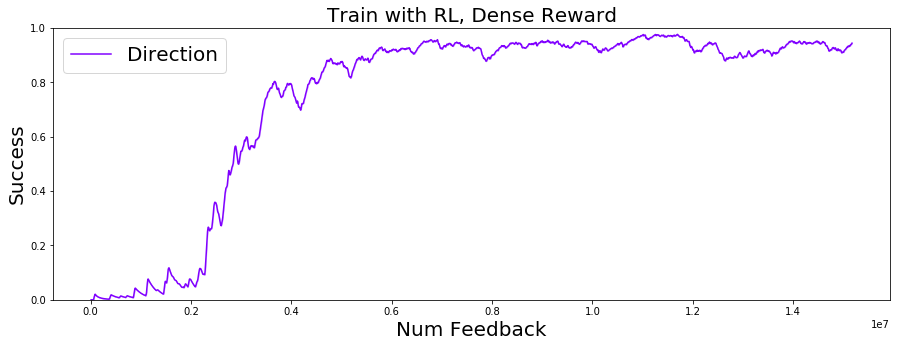

In [48]:
data_names = [
#     (['T3467'], 'Waypoint'),
#     (['T3412'], 'Direction'),
#     (['T3468'], 'Cardinal'),
#     (['T3466'], 'None'),
    (['T3860'], 'Direction'),
#     (['T3867'], 'Direction -> Cardinal'),
#     (['T3868'], 'Direction -> Waypoint'),
#     (['T3869'], 'Direction -> OffsetWaypoint'),
    (['T3870'], 'Direction -> None'),
]
metrics = [
    'Train/Success',
]


plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")

plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")







## Experimental

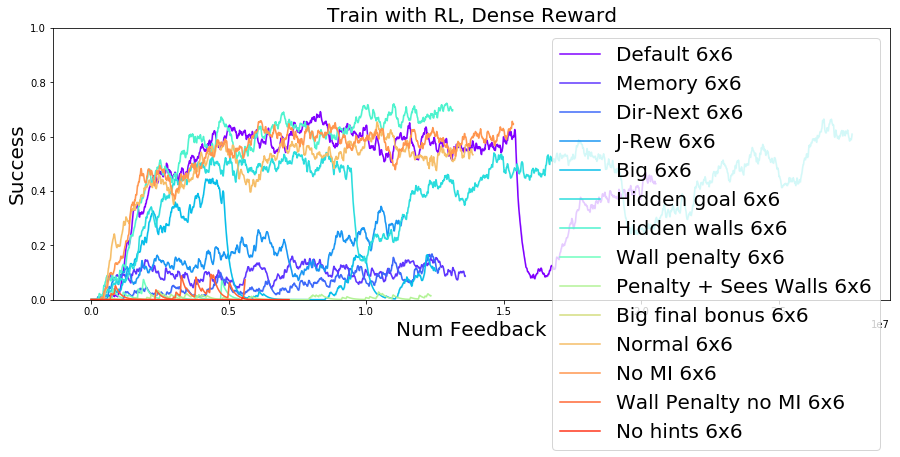

In [161]:
# All waypoint variants
metrics = [
    'Train/Success',
]

data_names = [
#         (['T3602'], 'Default 4x4'),
#         (['T3603'], 'Default 5x5'),
        (['T3604'], 'Default 6x6'),
#         (['T3710'], 'PCGrad 4x4'),
#         (['T3711'], 'PCGrad 5x5'),
#         (['T3712'], 'PCGrad 6x6'),
#         (['T3783'], 'Memory 6x6'),
#         (['T3784'], 'Dir-Next 6x6'),
#         (['T3786'], 'Big 6x6'),
#         (['T3712'], 'Wall Penalty 6x6'),
    
        (['C3783'], 'Memory 6x6'),
        (['C3784'], 'Dir-Next 6x6'),
        (['C3785'], 'J-Rew 6x6'),
        (['C3786'], 'Big 6x6'),
        (['C3787'], 'Hidden goal 6x6'),
        (['C3788'], 'Hidden walls 6x6'),  ##???
        (['C3806'], 'Wall penalty 6x6'),
        (['C3790'], 'Agent seees walls 6x6'), # Died
        (['C3791'], 'Penalty + Sees Walls 6x6'),
        (['C3792'], 'Big final bonus 6x6'),# Died
        (['C3795'], 'Normal 6x6'),
        (['C3796'], 'No MI 6x6'),
        (['C3807'], 'Wall Penalty no MI 6x6'),
        (['C3798'], 'No hints 6x6'),
        (['C3790'], 'Give pos/target 6x6'),
    ]
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")



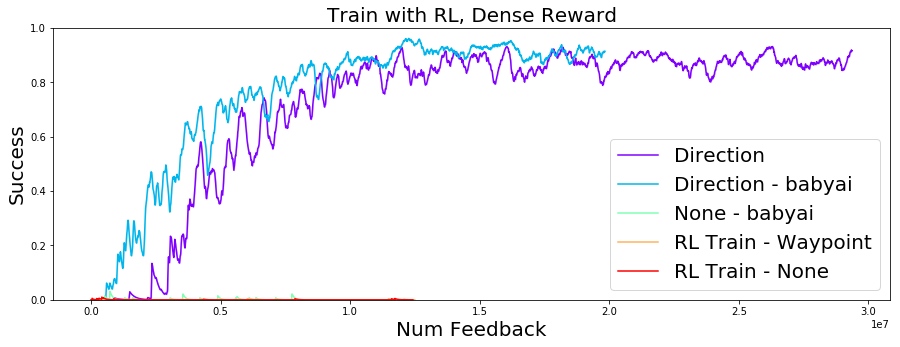

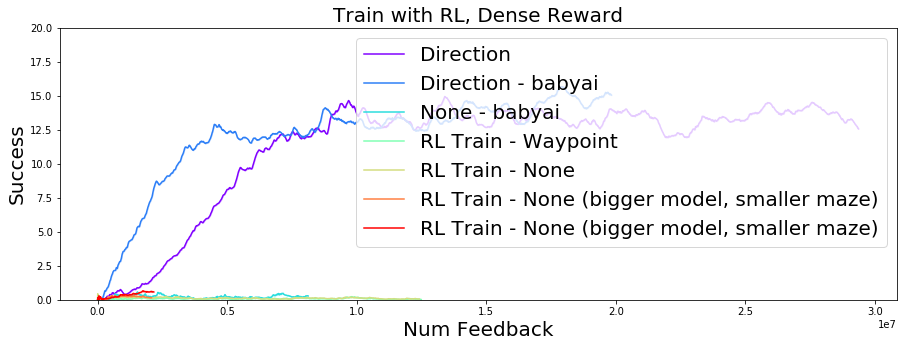

In [89]:
metrics = [
    'Train/Success',
]

data_names = [
#         (['T3860'], 'BSF'),
        (['T3863'], 'Direction'),
#         (['T3864'], 'Cardinal'),
#         (['T3865'], 'Waypoint'),
#         (['T3866'], 'OffsetWaypoint'),
        (['T3900'], 'Direction - babyai'),
        (['T3901'], 'None - babyai'),
        (['T3904'], 'RL Train - Waypoint'),
        (['T3905'], 'RL Train - None'),
    ]
# plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")


metrics = [
    'Train/Reward',
]

data_names = [
#         (['T3860'], 'BSF'),
        (['T3863'], 'Direction'),
#         (['T3864'], 'Cardinal'),
#         (['T3865'], 'Waypoint'),
#         (['T3866'], 'OffsetWaypoint'),
        (['T3900'], 'Direction - babyai'),
        (['T3901'], 'None - babyai'),
        (['T3904'], 'RL Train - Waypoint'),
        (['T3905'], 'RL Train - None'),
        (['T3909'], 'RL Train - None (bigger model, smaller maze)'),
        (['T3912'], 'RL Train - None (bigger model, smaller maze)'),
    ]
# plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=200, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=20, y_label="Success")

## Final

RUN NAMES ['K153', 'K154', 'K155']
LENGTHS [2430, 3091, 2999]
setting color [0.5 0.  1.  1. ]
RUN NAMES ['K156', 'K157', 'K158']
LENGTHS [3968, 4093, 3990]
setting color [0.17058824 0.49465584 0.9667184  1.        ]
RUN NAMES ['K159', 'K160', 'K161']
LENGTHS [3364, 2400, 2414]
setting color [0.16666667 0.8660254  0.8660254  1.        ]
RUN NAMES ['K162', 'K163', 'K164']
LENGTHS [3289, 3356, 3189]
setting color [0.50392157 0.99998103 0.70492555 1.        ]
RUN NAMES ['K165', 'K166', 'K167']
LENGTHS [4406, 2873, 2933]
setting color [0.6, 0.6, 0.6, 1]
RUN NAMES ['K375', 'K376', 'K377']
LENGTHS [1004, 1000, 876]
setting color [0, 0, 0, 1]
RUN NAMES ['K378', 'K379', 'K380']
LENGTHS [908, 898, 893]
setting color [0.3, 0.3, 0.3]


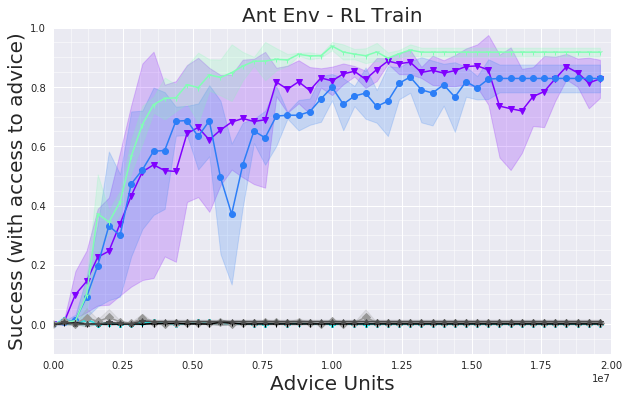

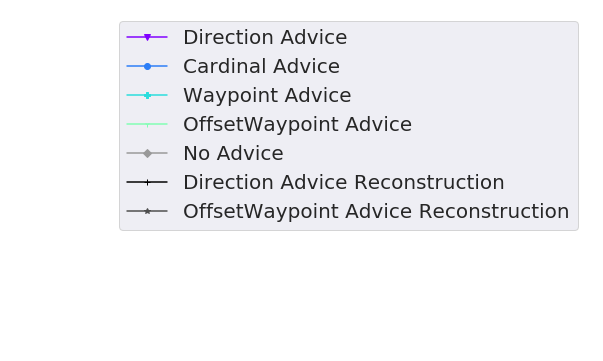

''

In [231]:
# EXPECT: converges to 85% success around 1.5k itrs
# EXPECT: done tomorrow morning or mayyyybe late tonight

plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'


data_names = [
        (['K153', 'K154', 'K155'], 'Direction Advice', None, 'v'),
        (['K156', 'K157', 'K158'], 'Cardinal Advice', None, 'o'),
        (['K159', 'K160', 'K161'], 'Waypoint Advice', None, 'P'),
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', None, '1'),
    
        (['K165', 'K166', 'K167'], 'No Advice', [.6, 0.6, 0.6, 1], 'D'),
        (['K375', 'K376', 'K377'], 'Direction Advice Reconstruction', [0, 0, 0, 1], '+'),
        (['K378', 'K379', 'K380'], 'OffsetWaypoint Advice Reconstruction', [.3, 0.3, 0.3], '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant.png', x_max=20000000)

# plot_curriculum(data_names, x_labelrsync -av -e ssh --exclude='*level*.pkl'  --exclude='*buffer.pkl' --exclude='buffer_stats.pkl' eval_runs/ olivia@pabrtxs1.ist.berkeley.edu:~/Teachable/babyai/meta-mb-internal/eval_runs
, 
#                 y=['Train/Reward'], 
#                 smooth=50, error_bars=True, 
#                 title="Train with RL",
#                y_lower=-1, y_upper=20, y_label="Reward")
# plot_curriculum(data_names, x_label, 
#                 y=['Train/DistToGoal'], 
#                 smooth=50, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=10, y_label="DistToGoal")




# <font color='green'>  ANT-E: Bootstrap feedback forms </font>

## Experimental

LENGTHS [3426193]
LENGTHS [1320000]
LENGTHS [27120000]
LENGTHS [14808029]
LENGTHS [4000000]
LENGTHS [18000000]
LENGTHS [3640000]
LENGTHS [7840000]
LENGTHS [5480000]


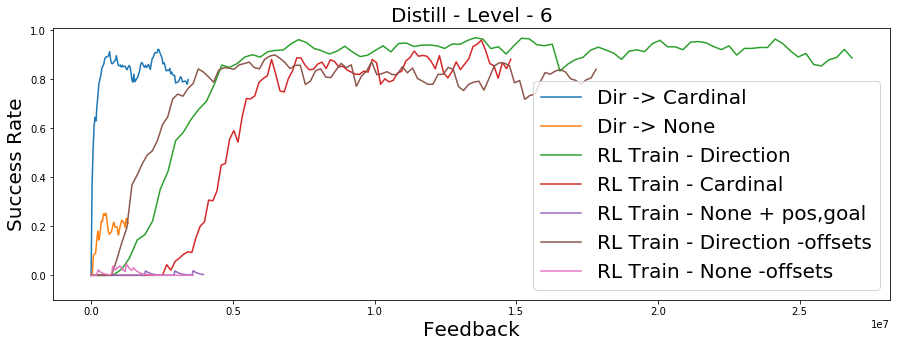

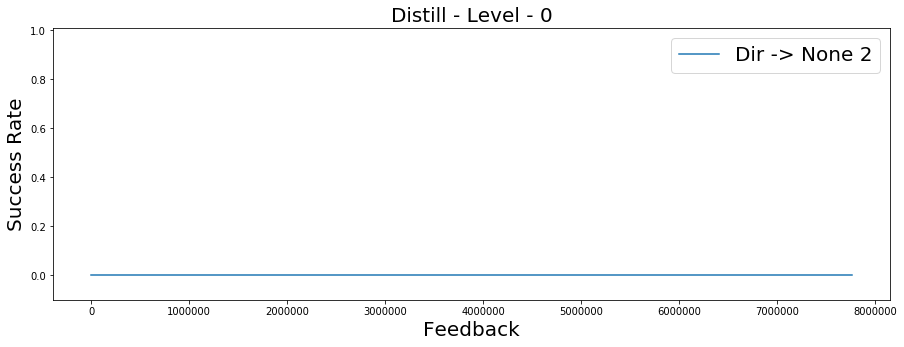

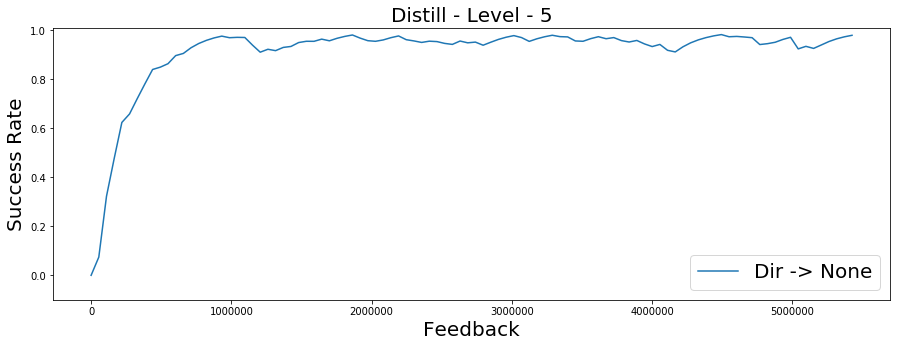

LENGTHS [3426193]
LENGTHS [1320000]
LENGTHS [27120000]
LENGTHS [14808029]
LENGTHS [4000000]
LENGTHS [18000000]
LENGTHS [3640000]
LENGTHS [7840000]
LENGTHS [5480000]


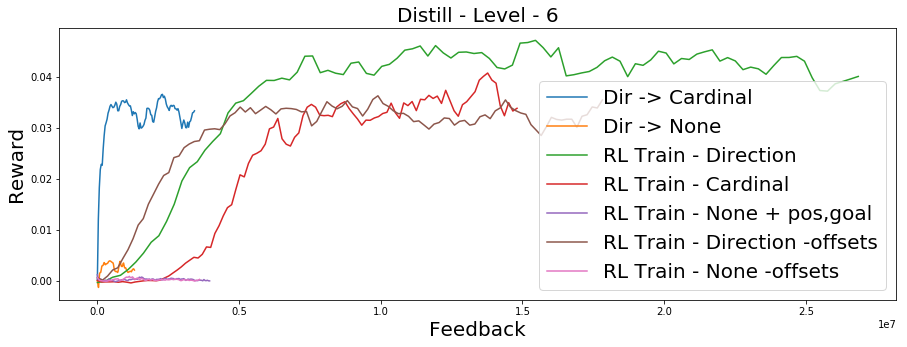

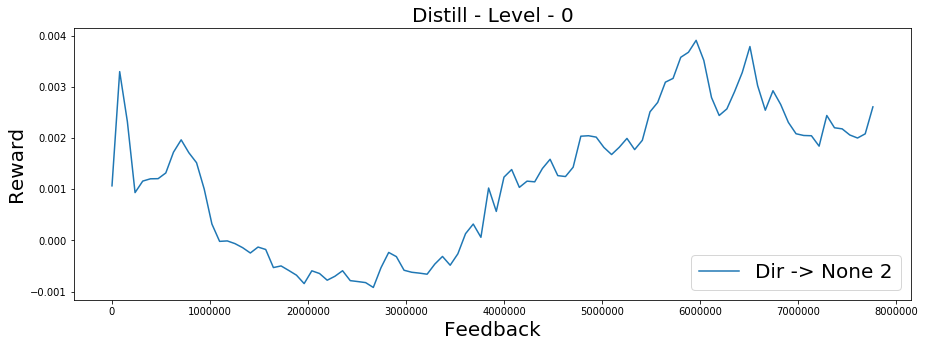

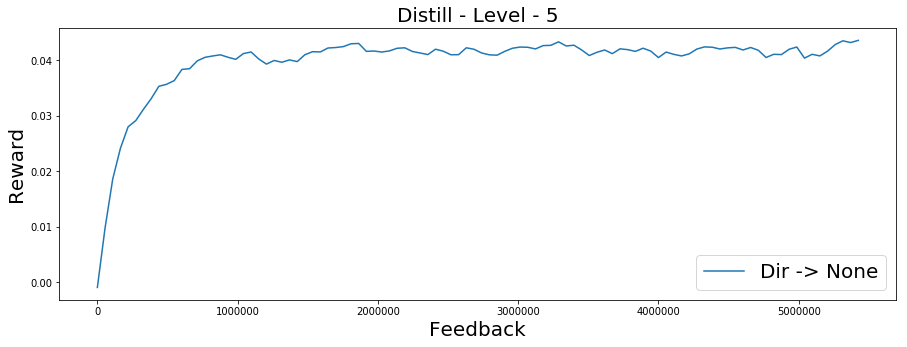

In [96]:
metric = 'reward'
# metric = 'success_rate'


runs = [
    (['T3867'], 'Dir -> Cardinal', 1),
    (['T3870'], 'Dir -> None', 1),
    (['T3860'], 'RL Train - Direction', 1),
    (['T3864'], 'RL Train - Cardinal', 1),
    (['T3897'], 'RL Train - None + pos,goal', 1),
    (['T3898'], 'RL Train - Direction -offsets', 1),
    (['T3899'], 'RL Train - None -offsets', 1),
    (['T3914'], 'Dir -> None 2', 1),
    (['T3917'], 'Dir -> None', 1),
]
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1)
# plt.ylim(-.01, .01)
plot_finetune_generalization(runs, 'Distill - Level', metric='reward', smooth=10, 
                             x_label='Feedback', y_label="Reward")


## Final

LENGTHS [19360000, 24720000, 23920000]
LENGTHS [1343634, 1345870, 1383184]


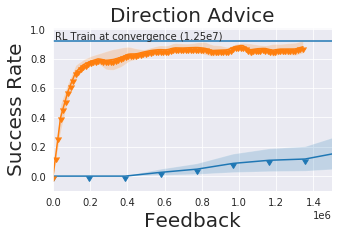

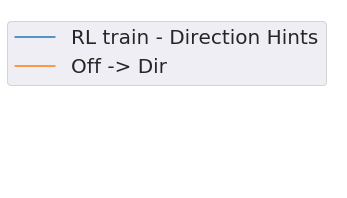

LENGTHS [15809152, 16720775, 16250226]
LENGTHS [56942, 59367, 52237]


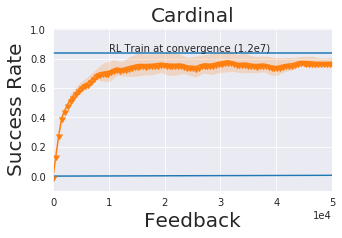

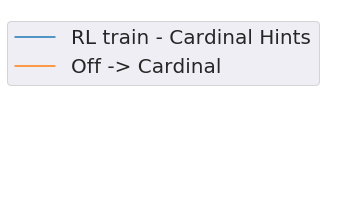

LENGTHS [13485415, 9632564, 9672602]
LENGTHS [85586, 98028, 87578]


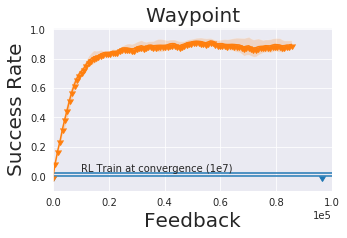

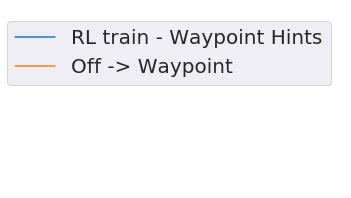

In [181]:
plt.rcParams['figure.figsize'] = [10, 3]
# metric = 'reward'
metric = 'success_rate'


runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1),
]
plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction Advice', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_direction_ant.png')


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.png')

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1),
]
plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.png')

# runs = [
#         (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
#         (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
#         (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
#         (['K168', 'K169', 'K170'], 'Off -> Dir', 1),
#         (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1),
#         (['K174', 'K175', 'K176'], 'Off -> Waypoint', 1),
# ]
# plt.xlim(0, 200000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Feedback', y_label="Success Rate",
#                             y_min=-0.1)


# <font color='green'> ANT-F: 0-shot solving Held-out Levels </font>

## Experimental

ENV DICT dict_keys([0, 1, 2, 3])


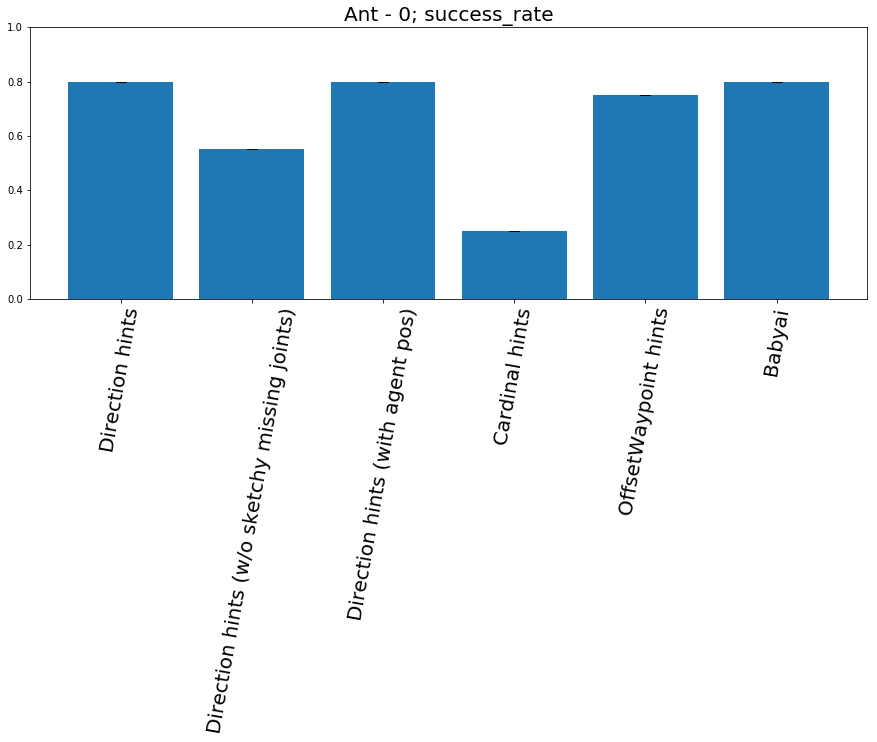

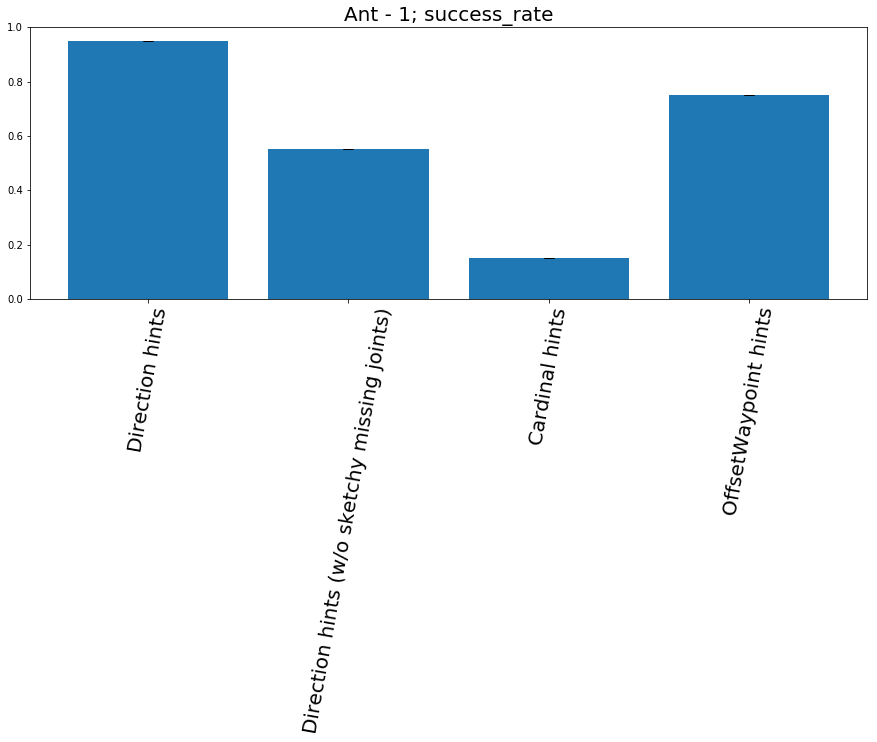

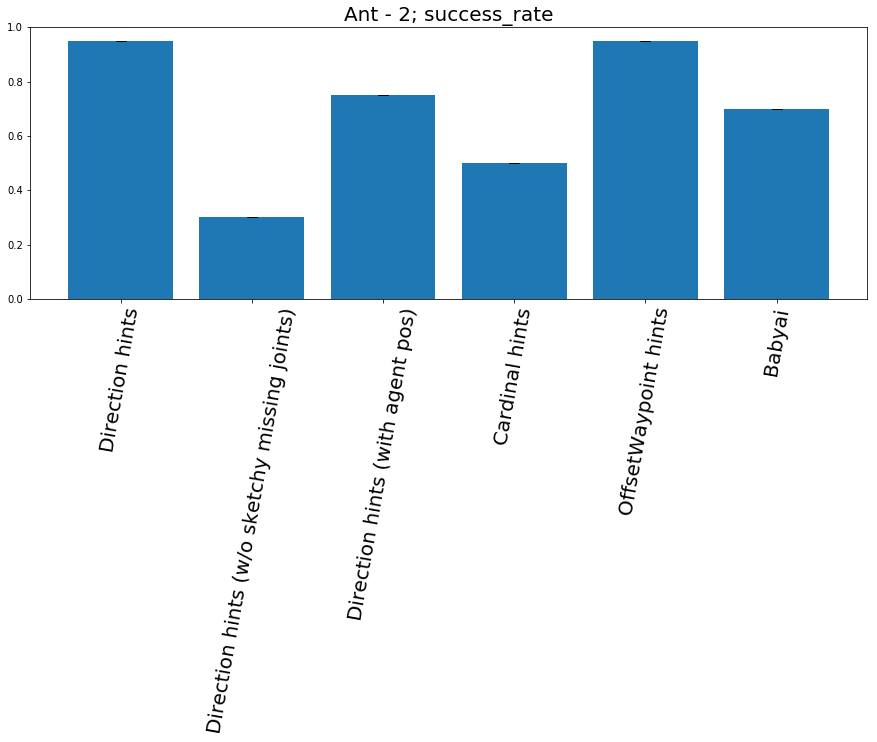

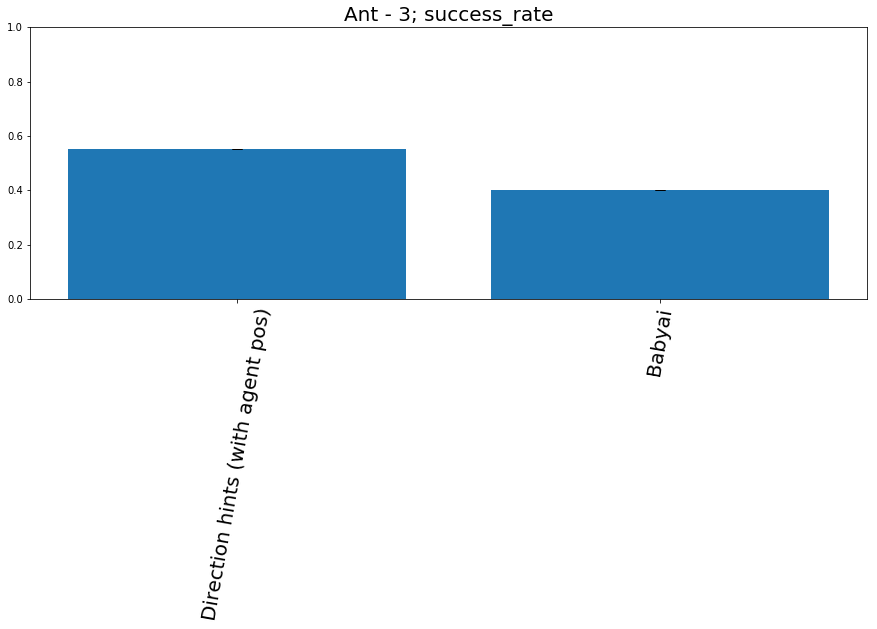

In [105]:
# runs = [
#     (['T3426'], '3420'),
#     (['T3431'], '3412'),
#     (['T3432'], '3422'),
#     (['T3439'], '3426'),
# ]
# plot_final_generalization(runs, 'Ant')


runs = [
#     (['T3634'], 'Train on easy random, Direction'),
#     (['T3635'], 'Train on medium random, Direction'),
#     (['T3636'], 'Train on hard random, Direction'),
    (['T3913'], 'Direction hints'),
    (['T3890'], 'Direction hints (w/o sketchy missing joints)'),
    (['T3893'], 'Direction hints (with agent pos)'),
    (['T3891'], 'Cardinal hints'),
    (['T3892'], 'OffsetWaypoint hints'),
    (['T3926'], 'Babyai'),
]
plot_final_generalization(runs, 'Ant')

## Final

ENV DICT dict_keys([0, 2, 3])


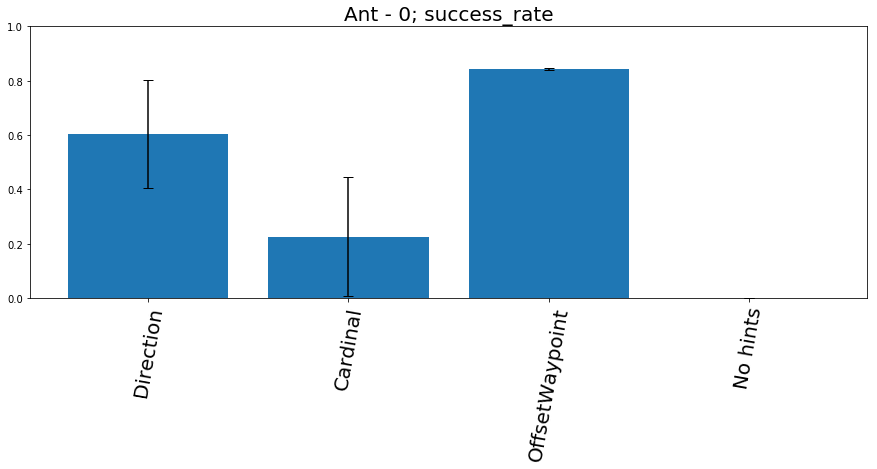

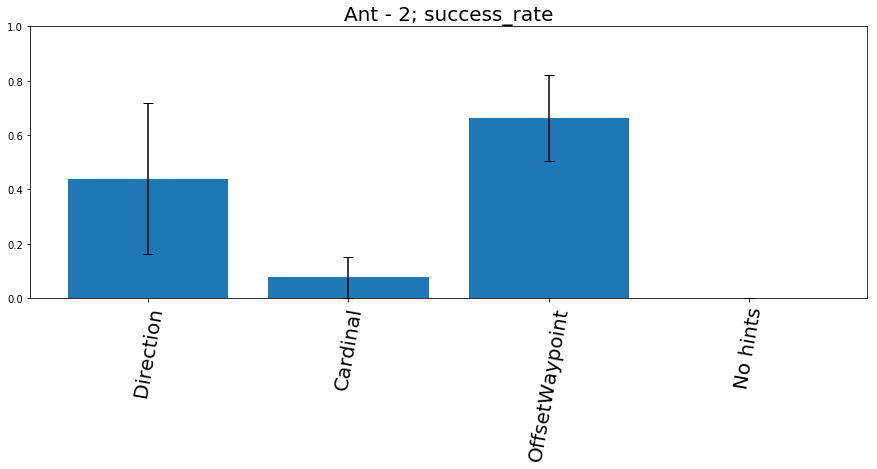

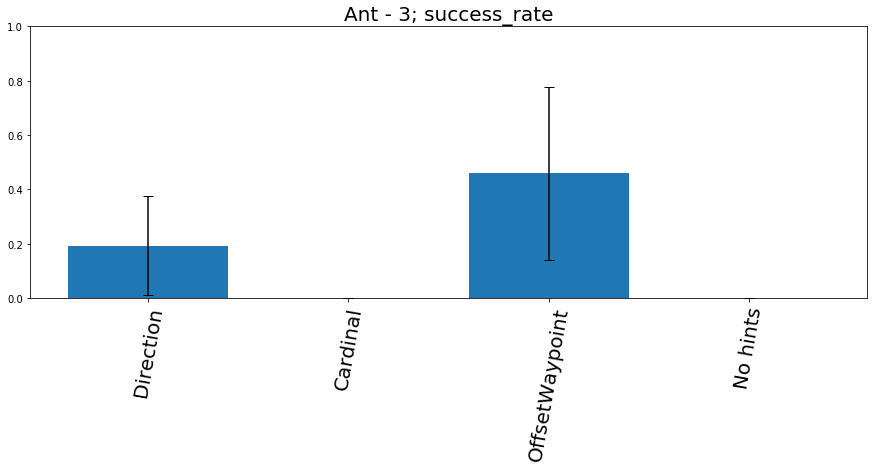

In [115]:
runs = [
    (['K192', 'K193', 'K194'], 'Direction'),
    (['K195', 'K196', 'K197'], 'Cardinal'),
    (['K198', 'K199', 'K200'], 'Waypoint'),
    (['K201', 'K202', 'K203'], 'OffsetWaypoint'),
    (['K204', 'K205', 'K206'], 'No hints'),
]
plot_final_generalization(runs, 'Ant')

# <font color='orange'>  ANT-G: Distilling on held-out levels </font>

## Experimental

LENGTHS [7800000]
LENGTHS [1280000]
LENGTHS [1217951]


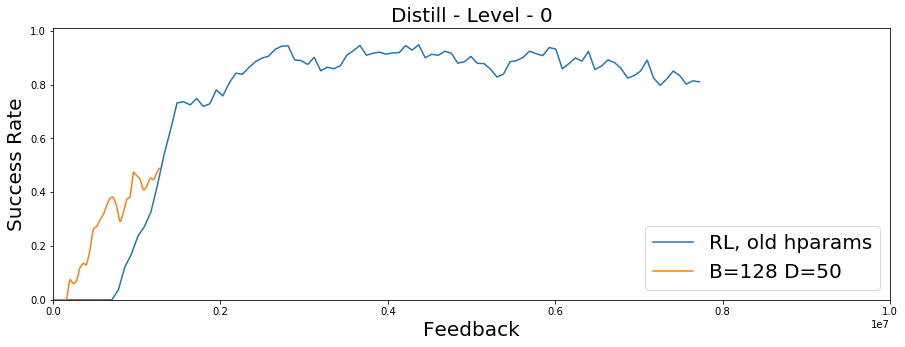

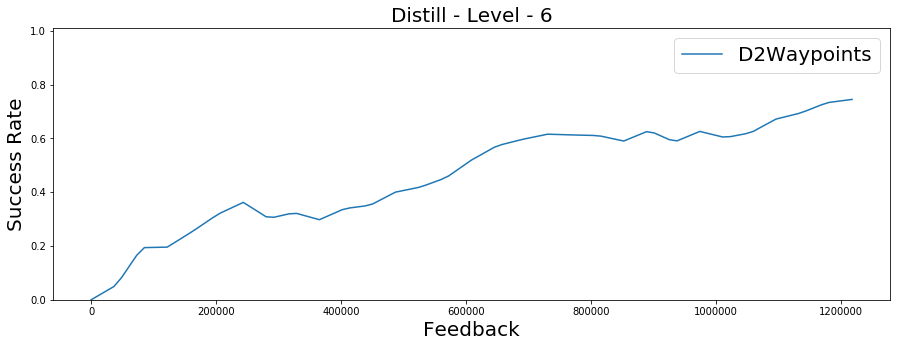

In [46]:
metric='success_rate'
label='Success Rate'

# metric = 'reward'
# label = 'Reward'

# L0
runs = [
#     (['T3871'], 'Distill from Direction', 1),
#     (['T3894'], 'Distill from Direction + goal', 1),
#     (['T3902'], 'Distill to bigger', 1),
#     (['T3914'], 'Distill to bigger, fewer itrs', 1),
#     (['T3918'], 'RL', 1),
#     (['T3927'], 'Higher LR', 1),
#     (['T3928'], 'D=10', 1),
#     (['T3929'], 'D=50', 1),
#     (['T3930'], 'B=1024', 1),
#     (['T3931'], 'Babyai', 1),
    
    
    (['T3932'], 'RL, old hparams', 1),
#     (['T3933'], 'Distill', 1),
#     (['T3934'], 'D=10', 1),
#     (['T3935'], 'D=50', 1),
#     (['T3936'], 'no ent bonus', 1),
#     (['T3937'], 'RL, repeat input', 1),
    
    
#     (['T3939'], 'B=32 D=50', 1),
#     (['T3940'], 'B=128 D=50', 1),
#     (['T3941'], 'B=128 D=50', 1),
#     (['T3942'], 'B=2048 D=50', 1),
#     (['T3943'], 'B=32 D=10', 1),
#     (['T3944'], 'B=32 D=100', 1),
#     (['T3945'], 'B=32 D=50', 1),
#     (['T3956'], 'FPP big', 1),
#     (['T3957'], 'no filter success', 1),
#     (['T3958'], 'B=32, D=50', 1),
    (['T3959'], 'B=128 D=50', 1),
#     (['T3960'], 'B=512 D=50', 1),
#     (['T3961'], 'B=2048 D=50', 1), # BSF
#     (['T3962'], 'B=128 D=10', 1),
#     (['T3963'], 'B=128 D=100', 1),
#     (['T3964'], 'B=128 D=200', 1),
#   #  (['T3965'], 'B=128 D=50 C=100k', 1), # Worse
#   #  (['T3966'], 'B=128 D=50 C=10M', 1), # Same as default
#     (['T3967'], 'B=128 D=50 M512', 1),
# #     (['T3968'], 'hide_goals branch', 1), # Worst
    (['T3970'], 'D2Waypoints', 1),
    
    
    
]
plt.xlim(0, 10000000)
plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)

# # L2
# runs = [
#     (['T3872'], 'Distill from Direction', 1),
#     (['T3895'], 'Distill from Direction + Goal', 1),
#     (['T3903'], 'Distill to bigger', 1),
#     (['T3915'], 'Distill to bigger, fewer itrs', 1),
# ]
# plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)

# # L3
# runs = [
#     (['T3873'], 'Distill from Direction', 1),
# ]
# plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)


# # L5
# runs = [
#     (['T3917'], 'Distill from Direction', 1),
#     (['T3920'], 'RL', 1),
# ]
# plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)

[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3914/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3927/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3928/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3929/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3930/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3931/progress.csv'


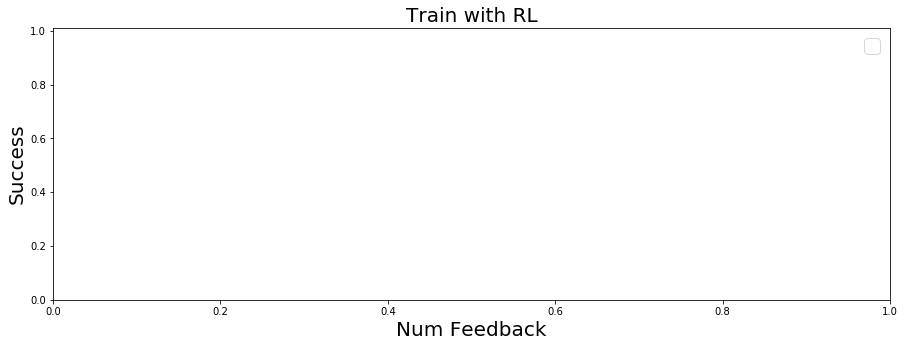

[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3914/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3927/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3928/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3929/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3930/progress.csv'
[Errno 2] No such file or directory: 'meta-mb-internal/eval_runs/T3931/progress.csv'


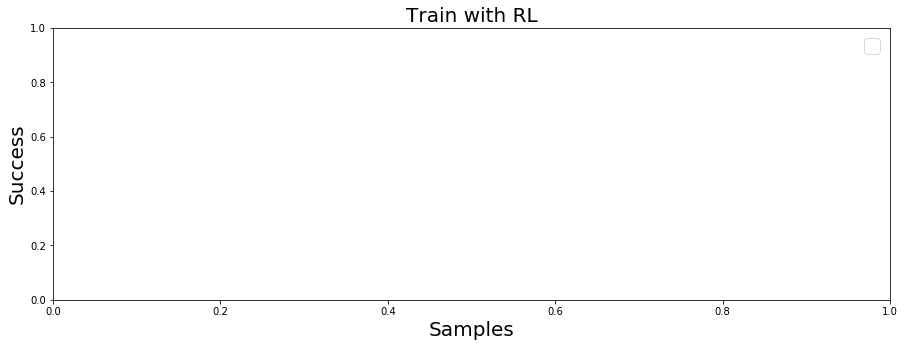

In [146]:
plt.rcParams['figure.figsize'] = [15, 5]
metrics = [
    'Distill/Loss_Val',
]
x_label = 'feedback'
data_names = [
    (['T3914'], 'Distill to bigger, fewer itrs'),
    (['T3918'], 'RL'),
    (['T3927'], 'Higher LR'),
    (['T3928'], 'D=10'),
    (['T3929'], 'D=50'),
    (['T3930'], 'B=1024'),
    (['T3931'], 'Babyai'),
]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Train with RL",
                y_label="Success")
plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Train with RL",
               y_lower=0, y_upper=1, y_label="Success")


## Final

LENGTHS [8946000, 9156000, 9450000]
LENGTHS [465062, 542242, 937022]
LENGTHS [174204, 178040, 162346]
LENGTHS [223070, 229846, 210178]
LENGTHS [6520000, 6560000, 6560000]


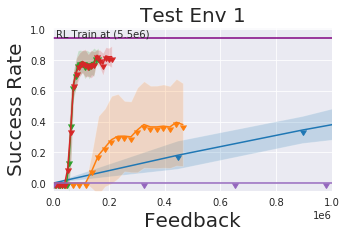

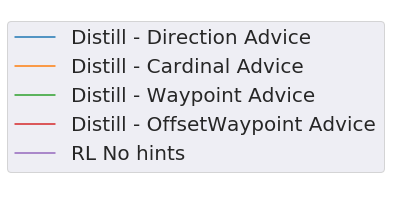

LENGTHS [4352000, 4504000, 200000]
LENGTHS [214260, 193854, 451535]
LENGTHS [92195, 85422, 113552]
LENGTHS [115812, 107893, 135026]
LENGTHS [3480000, 3560000, 3160000]


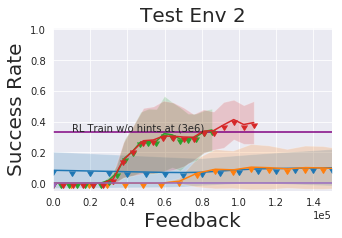

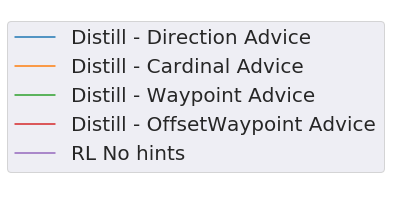

In [200]:
plt.rcParams['figure.figsize'] = [5, 3]


metric='success_rate'
label='Success Rate'

# metric = 'reward'
# label = 'Reward'

# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', 1),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', 1),
    (['K183', 'K184', 'K185'], 'Distill - Waypoint Advice', 1),
#     (['K186', 'K187', 'K188'], 'Distill OffsetWaypoint', 1),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', 1),
    (['K189', 'K190', 'K191'], 'RL No hints', 1),
]
plt.xlim(0, 1000000)
add_line(.94, 'RL Train at (5.5e6)', color='purple')
plot_finetune_generalization(runs, 'Test Env 1', metric=metric, smooth=10, x_label='Feedback', 
                             y_label=label, y_min=-.05, save_name='distill_ant_l0.png')

# L2
runs = [
#     (['K207', 'K208', 'K209'], 'Distill Direction', 1),
#     (['K208'], 'Distill Direction', 1),
#     (['K321', 'K322'], 'Distill Direction (finetune)', 1),
    (['K321', 'K322', 'K323'], 'Distill - Direction Advice', 1),
    (['K210', 'K211', 'K212'], 'Distill - Cardinal Advice', 1),
    (['K213', 'K214', 'K215'], 'Distill - Waypoint Advice', 1),
#     (['K216', 'K217', 'K218'], 'Distill OffsetWaypoint', 1),
#     (['K216', 'K217'], 'Distill OffsetWaypoint', 1),
    (['K324', 'K325', 'K326'], 'Distill - OffsetWaypoint Advice', 1),
    (['K219', 'K220', 'K221'], 'RL No hints', 1),
]
plt.xlim(0, 150000)
add_line(.33, 'RL Train w/o hints at (3e6)', color='purple')
plot_finetune_generalization(runs, 'Test Env 2', metric=metric, smooth=10, x_label='Feedback', 
                             y_label=label, y_min=-.05, save_name='distill_pm_l2.png')

# # L3
# runs = [
#     (['K222', 'K223', 'K224'], 'Distill - Direction Advice', 1),
#     (['K225', 'K226', 'K227'], 'Distill - Cardinal Advice', 1),
#     (['K228', 'K229', 'K230'], 'Distill - Waypoint Advice', 1),
# #     (['K231', 'K232', 'K233'], 'Distill OffsetWaypoint', 1),
#     (['K330', 'K331', 'K332'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K234', 'K235', 'K236'], 'RL No hints', 1),
# ]
# plt.xlim(0, 200000)
# add_line(.16, 'RL Train at (2e6)', color='purple')
# plot_finetune_generalization(runs, 'Test Env 3', metric=metric, smooth=10, 
#                              x_label='Feedback', y_label=label, y_min=-.1, y_max=.4)



# <font color='orange'> BABYAI-C: RL train on Training Level </font>

RUN NAMES ['K333_1', 'K334', 'K335']
LENGTHS [70, 60, 60]
setting color [0.5 0.  1.  1. ]
RUN NAMES ['K237', 'K238', 'K239']
LENGTHS [3211, 3184, 3293]
setting color [0.1        0.58778525 0.95105652 1.        ]
RUN NAMES ['K240', 'K241', 'K242']
LENGTHS [1760, 1660, 1480]
setting color [0.3        0.95105652 0.80901699 1.        ]
RUN NAMES ['K243', 'K244', 'K245']
LENGTHS [2850, 1650, 2317]
setting color [0.6, 0.6, 0.6, 1]
RUN NAMES ['K246', 'K247', 'K248']
LENGTHS [2580, 2451, 2590]
setting color [0, 0, 0, 1]
RUN NAMES ['K381', 'K382', 'K383']
LENGTHS [1184, 1250, 1280]
setting color [0.7        0.95105652 0.58778525 1.        ]


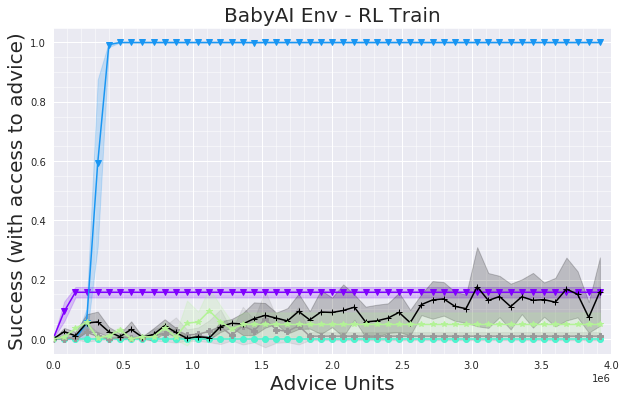

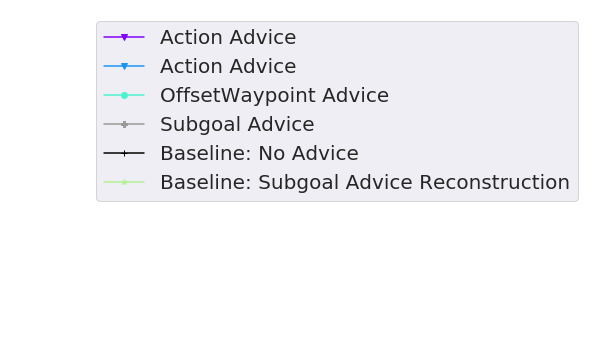

In [242]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'

runs = [
        (['K333_1', 'K334', 'K335'], 'Action Advice', None, 'v'),
#         (['K336', 'K337', 'K338'], 'Waypoint Advice', None, None),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', None, None),
#         (['K342', 'K343', 'K344'], 'Baseline: No Advice', None, None),
        (['K237', 'K238', 'K239'], 'Action Advice', None, 'v'),
        (['K240', 'K241', 'K242'], 'OffsetWaypoint Advice', None, 'o'),
        (['K243', 'K244', 'K245'], 'Subgoal Advice', [.6, 0.6, 0.6, 1], 'P'),
        (['K246', 'K247', 'K248'], 'Baseline: No Advice', [0, 0, 0, 1], '+'),
        (['K381', 'K382', 'K383'], 'Baseline: Subgoal Advice Reconstruction', None, '*'),
    ]


plot_curriculum(runs, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="BabyAI Env - RL Train",
               y_lower=-0.05, y_upper=1.05, y_label="Success (with access to advice)", 
                save_name='rl_train_babyai.png', x_max=4000000)
# plot_curriculum(runs, x_label, 
#                 y=['Train/Accuracy'], 
#                 smooth=1, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=1, y_label="Accuracy")


# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'RL Train', metric='stoch_accuracy', smooth=10, 
#                              x_label='Feedback', y_label="Success Rate",
#                             y_min=0, y_max=1)

# <font color='orange'> BABYAI-E: Bootstrap feedback forms </font>

LENGTHS [1903193, 1860869, 1615731]
LENGTHS [1698801, 1779026, 1739110]


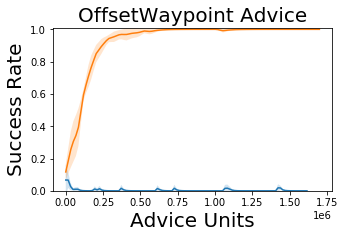

MAX 0.06666666666666667
MAX 0.9999998737270411


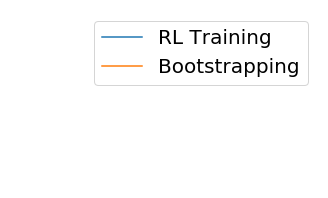

LENGTHS [3120056, 1921854, 2504870]
LENGTHS [843189, 3436731, 3523471]


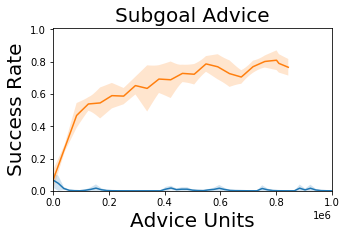

MAX 0.06666666666666667
MAX 0.8087265586129683


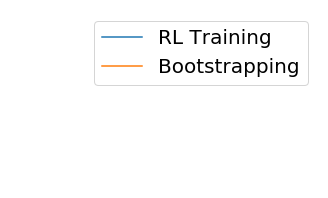

In [85]:
plt.rcParams['figure.figsize'] = [5, 3]

x_label = 'Advice Units'

runs = [
        (['K240', 'K241', 'K242'], 'RL Training'),
        (['K249b', 'K250b', 'K251b'], 'Bootstrapping'),
    ]

plot_finetune_generalization(runs, 'OffsetWaypoint Advice', smooth=3, x_label=x_label, 
                             metric='success_rate', y_label="Success Rate", 
                             save_name='bootstrap_waypoint_babyai.png')


runs = [
        (['K243', 'K244', 'K245'], 'RL Training'),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping'),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal Advice', smooth=3, x_label=x_label, metric='success_rate', 
                             y_label="Success Rate", save_name='bootstrap_subgoal_babyai.png')


plt.rcParams['figure.figsize'] = [10, 3]
# metric = 'reward'
metric = 'success_rate'


runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1),
]
plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction Advice', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_direction_ant.png')


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.png')

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1),
]
plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.png')




#  <font color='orange'> BABYAI-F: 0-shot solving Held-out Levels </font>

ENV DICT dict_keys([28, 30, 31, 33, 35, 45])


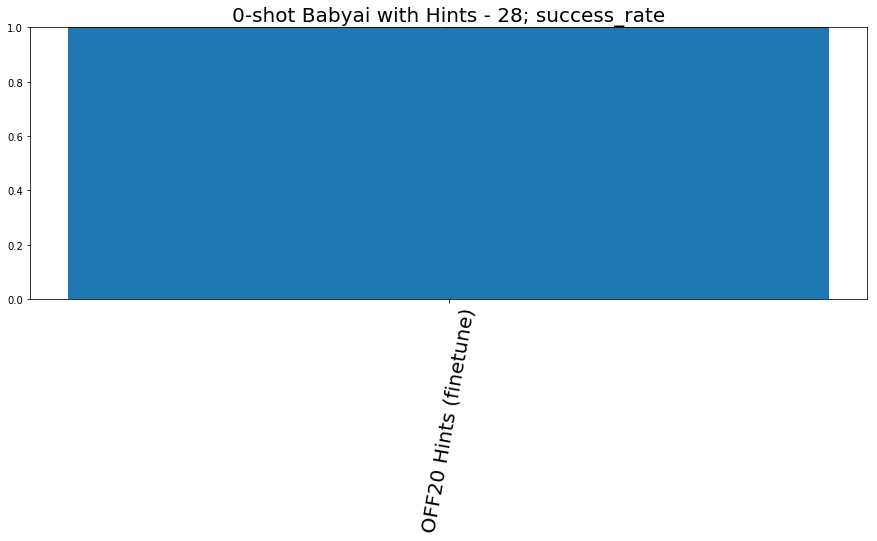

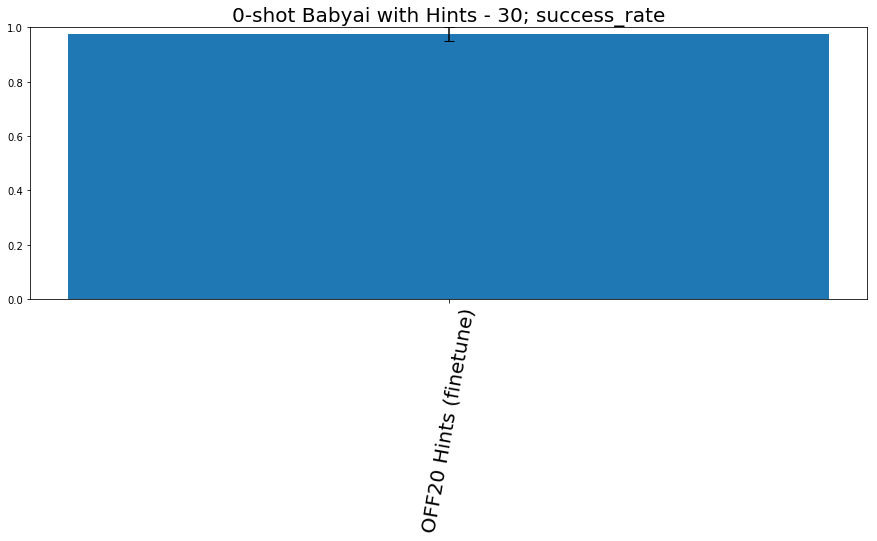

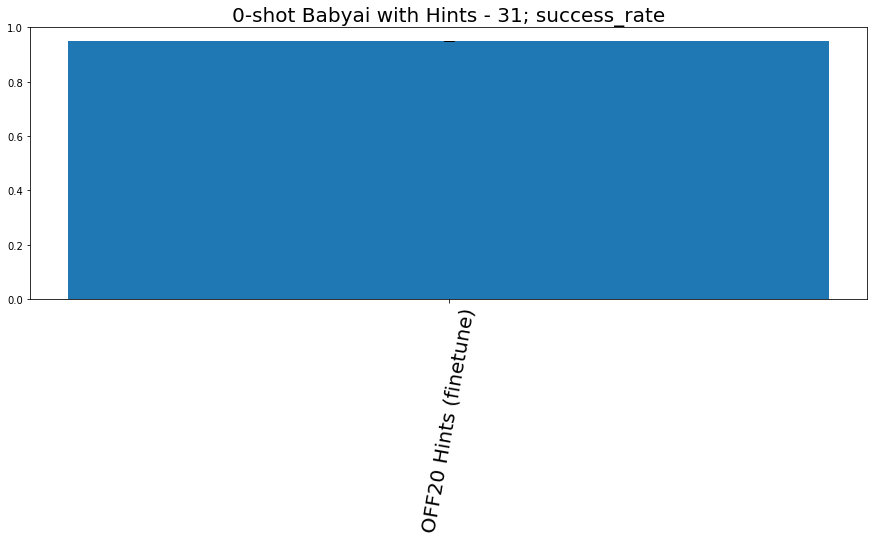

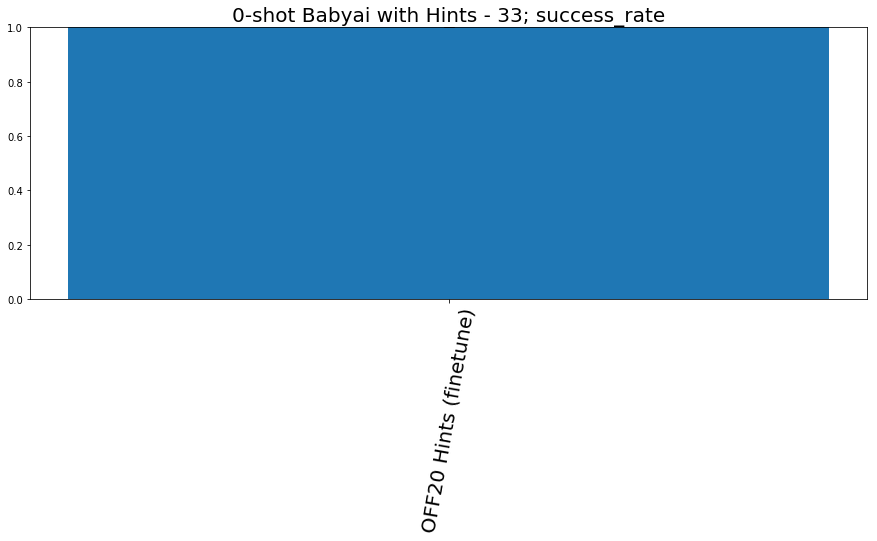

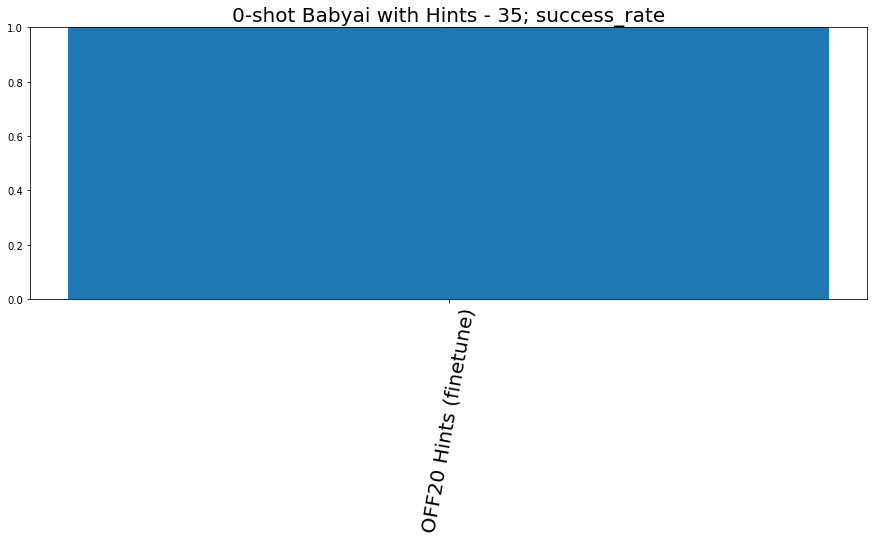

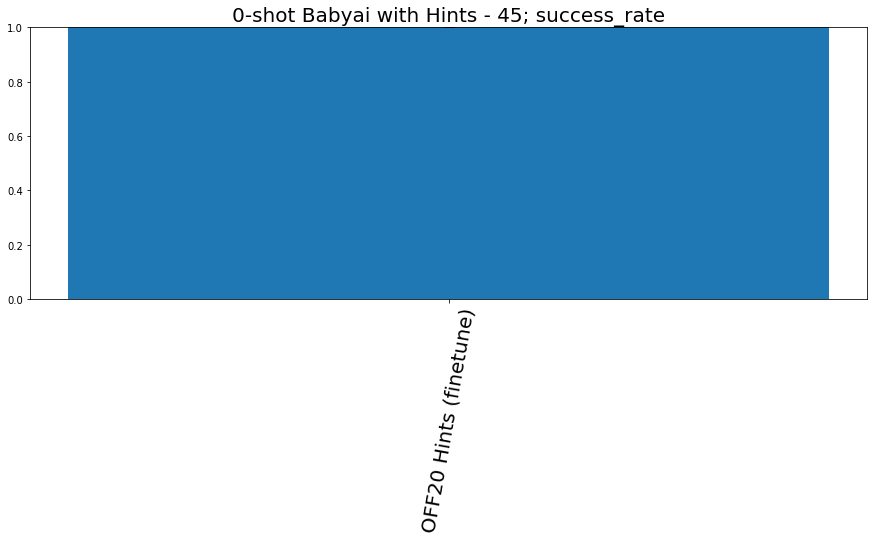

In [67]:
runs = [
#     (['K258', 'K259', 'K260'], 'PA Hints'),
#     (['K261', 'K262', 'K263'], 'OFF20 Hints'),
#     (['K264', 'K265', 'K266'], 'Subgoals Hints'),
#     (['K267', 'K268', 'K269'], 'No Hints'),
    (['K270', 'K271'], 'OFF20 Hints (finetune)'),
#     (['K273', 'K274', 'K275'], 'Subgoals Hints (finetune)'),
#     (['K276', 'K277', 'K278'], 'No Hints (finetune)'),
    
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Babyai with Hints')

# <font color='orange'> BABYAI-G: Distilling on held-out levels </font>

LENGTHS [75000, 75000, 80000]
LENGTHS [8139, 9014, 9500]
LENGTHS [9666, 7828, 11438]
LENGTHS [30000, 30000, 30000]


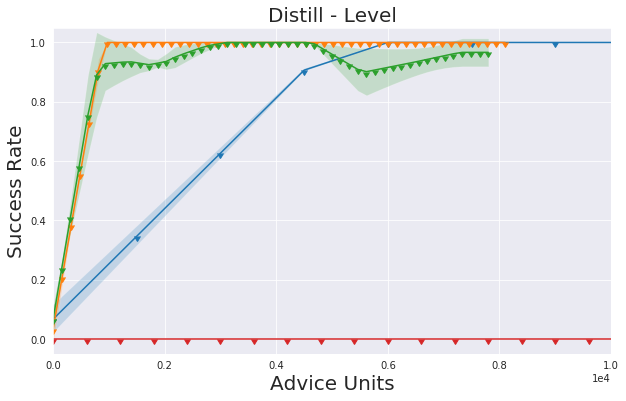

In [301]:
plt.rcParams['figure.figsize'] = [10, 6]

# # L28
# runs = [
#     (['K279', 'K280', 'K281'], 'Distill - Action Advice', 1),
#     (['K282', 'K283', 'K284'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K285', 'K286', 'K287'], 'Distill - Subgoal Advice', 1),
#     (['K288', 'K289', 'K290'], 'RL Finetune', 1),
# #     (['K384', 'K385', 'K386'], 'RL Finetune - Subgoal Advice Reconstruction', 1),
# #     ([], 'Distill from demos', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1)


# # L36
# runs = [
#     (['K393', 'K394', 'K395'], 'Distill - Action Advice', 1),
#     (['K396', 'K397', 'K398'], 'Distill - OffsetWaypoint Advice', 1),
# #     (['K399', 'K400', 'K401'], 'Distill - Subgoal Advice', 1),
# #     (['K399'], 'Distill - Subgoal Advice', 1), *******
#     (['K402', 'K403', 'K404'], 'RL Finetune', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Test Env 1', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_ant_l36.png')

# # kangaroo

# # L30
# runs = [
#     (['K291', 'K292', 'K293'], 'Distill - Action Advice', 1),
# #     (['K405', 'K406', 'K407'], 'Distill - OffsetWaypoint Advice', 1),
# #     (['K408', 'K409', 'K410'], 'Distill - Subgoal Advice', 1),
#     (['K411', 'K412', 'K413'], 'RL Finetune', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_ant_l30.png')




# # L45
# runs = [
#     (['K414', 'K415', 'K416'], 'Distill - Action Advice', 1),
#     (['K417', 'K418', 'K419'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K420', 'K421', 'K422'], 'Distill - Subgoal Advice', 1),
#     (['K423', 'K424', '425'], 'RL Finetune', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_ant_l45.png')


# # L33
# runs = [
#     (['K303', 'K304', 'K305'], 'Distill - Action Advice', 1),
#     (['K306', 'K307', 'K308'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K309', 'K310', 'K311'], 'Distill - Subgoal Advice', 1),
#     (['K312', 'K313', 'K314'], 'RL Finetune', 1),
# #     (['K390', 'K391', 'K392'], 'RL Finetune - Subgoal Advice Reconstruction', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1)



# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', 1),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', 1),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', 1),
    (['K435', 'K436', 'K437'], 'RL Finetune', 1),
]
plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=1, 
                             x_label='Advice Units', y_label="Success Rate",
                            y_min=-.05, y_max=1.05, save_name='distill_ant_l30.png')




RUN NAMES ['K012']
LENGTHS [9752]
RUN NAMES ['K013']
LENGTHS [9550]
RUN NAMES ['K014']
LENGTHS [9960]


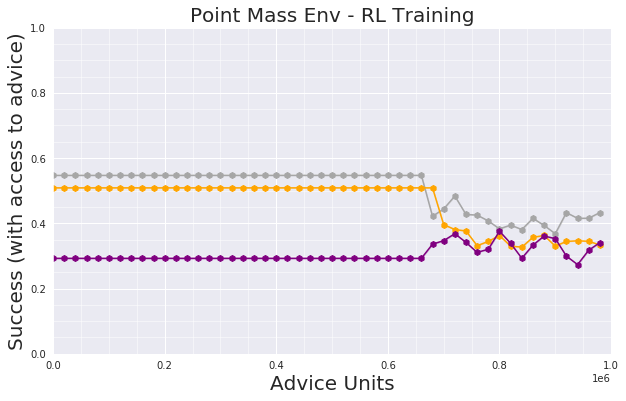

In [278]:
data_names = [
        (['K012'], 'a', gray2, 'h'),
        ([ 'K013'], 'a', 'orange', 'h'),
        ([ 'K014'], 'a', 'purple', 'h'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm.png', x_min=0, x_max=1000000)

# FIRST PLOT

paths [PosixPath('meta-mb-internal/data/K012_1')]
file name results.csv
LENGTHS [1537.0]
plotting None


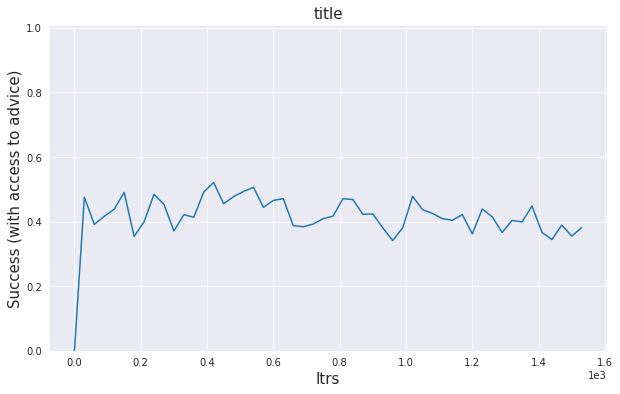

In [398]:
data_names = [
        (['K012'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
#         (['K013'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
#         (['K014'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
#         (['B012'], 'Baseline: No Advice - Semi-Sparse Reward', 'red', 'h'),
#         (['B013'], 'Baseline: No Advice - Semi-Sparse Reward', 'red', 'h'),
#         (['B014'], 'Baseline: No Advice - Semi-Sparse Reward', 'red', 'h'),
    ]

plot_finetune_generalization(data_names, 'title', 
                smooth=20,
                y_label="Success (with access to advice)",
                save_name=None)


# runs, 'Direction (PM)', smooth=10, x_label=inside_x_label, 
#                              y_label=outside_y_label, x_max=1000000, save_name='bootstrap_direction_pm.png')


# plot_curriculum(data_names, x_label, 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="Point Mass Env - RL Training",
#                y_lower=0, y_upper=1, y_label="Success (with access to advice)",
#                save_name='rl_train_pm.png', x_min=0, x_max=1000000)


RUN NAMES ['K153', 'K154', 'K155']
paths [PosixPath('meta-mb-internal/data/K153_1')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K154_2')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K155_3')]
file name progress.csv
LENGTHS [2430, 3091, 2999]


/home/olivia/miniconda3/envs/babyai/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


filling red
RUN NAMES ['K156', 'K157', 'K158']
paths [PosixPath('meta-mb-internal/data/K156_1')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K157_2')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K158_3')]
file name progress.csv
LENGTHS [3968, 4093, 3990]
filling green
RUN NAMES ['K159', 'K160', 'K161']
paths [PosixPath('meta-mb-internal/data/K159_1')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K160_2')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K161_3')]
file name progress.csv
LENGTHS [3364, 2400, 2414]
filling blue
RUN NAMES ['K162', 'K163', 'K164']
paths [PosixPath('meta-mb-internal/data/K162_1')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K163_2')]
file name progress.csv
paths [PosixPath('meta-mb-internal/data/K164_3')]
file name progress.csv
LENGTHS [3289, 3356, 3189]
filling purple
RUN NAMES ['K165', 'K166', 'K167']
paths [PosixPath('meta-mb-internal/data/K165_1')]
file name progress

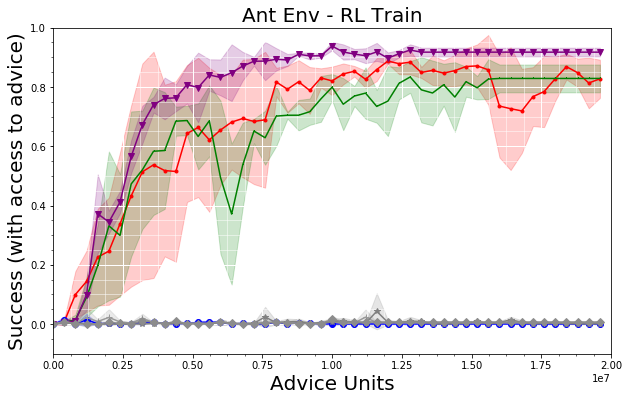

NameError: name 'inside_x_label' is not defined

In [6]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'

gray0 = [.75, 0.75, 0.75, 1]
gray1 = [.7, 0.7, 0.7, 1]
gray2 = [.65, 0.65, 0.65, 1]
gray3 = [.6, 0.6, 0.6, 1]
gray4 = [.55, 0.55, 0.55, 1]
gray5 = [.5, 0.5, 0.5, 1]

data_names = [
        (['K000', 'K001', 'K002'], 'Direction Advice', 'red', '.'),
        (['K003', 'K004', 'K005'], 'Cardinal Advice', 'green', ','),
        (['K006', 'K007', 'K008'], 'Waypoint Advice', 'blue', 'o'),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K000', 'K001', 'K002'], 'Direction Advice', [0, 0, .5, 1], '.'),
#         (['K003', 'K004', 'K005'], 'Cardinal Advice', [0, 0, .7, 1], ','),
#         (['K006', 'K007', 'K008'], 'Waypoint Advice', [0, 0, 1, 1], 'o'),
#         (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', [0, 0, 1, 1], 'v'),
        (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward', gray1, '1'),
        (['K012','K013'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
#         (['K012', 'K013', 'K014'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
        (['K018', 'K019', 'K020'], 'Baseline: No Advice', gray3, '+'),
        (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction', gray4, 'D'),
        (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction', gray5, '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm.png', x_min=0, x_max=1000000)

data_names = [
        (['K153', 'K154', 'K155'], 'Direction Advice', 'red', '.'),
        (['K156', 'K157', 'K158'], 'Cardinal Advice', 'green', ','),
        (['K159', 'K160', 'K161'], 'Waypoint Advice', 'blue', 'o'),
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', 'purple', 'v'),
    
        (['K165', 'K166', 'K167'], 'No Advice', gray3, '+'),
        (['K375', 'K376', 'K377'], 'Direction Advice Reconstruction', gray5, '*'),
        (['K378', 'K379', 'K380'], 'OffsetWaypoint Advice Reconstruction', gray4, 'D'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant.png', x_max=20000000)

# plot_finetune_generalization(data_names, x_label=inside_x_label,
#                              smooth=40, 
#                              title="Ant Env - RL Train",
#                              y_label=outside_y_label, 
#                              save_name='temp.png', x_max=20000000)


# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),
#         (['K342', 'K343', 'K344'], 'Baseline: No Advice', gray3, '+'),
#         (['K381', 'K382', 'K383'], 'Baseline: Subgoal Advice Reconstruction', gray0, 'x'),
#     ]


# plot_curriculum(runs, x_label, 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="BabyAI Env - RL Train",
#                y_lower=-0.05, y_upper=1.05, y_label="Success (with access to advice)", 
#                 save_name='rl_train_babyai.png', x_max=4000000)


# # LEGEND
# legend = [
#     ('Ours: Direction Advice', '.', 'red'),
#     ('Ours: Cardinal Advice', ',', 'green'),
#     ('Ours: Waypoint Advice', 'o', 'blue'),
#     ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
#     ('Ours: Action Advice', 's', 'orange'),
#     ('Ours: Subgoal Advice', 'P', 'brown'),
#     ("Baseline: Imitation Learning", '2', gray3),
#     ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
#     ("Baseline: No Advice - Sparse Reward [Hui et al. '20]", '1', gray1),
#     ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
    
#     ("Baseline: OffsetWaypoint Advice Reconstruction [Zhu et al. '20]", 'D', gray4),
#     ("Baseline: Direction Advice Reconstruction [Zhu et al. '20]", '*', gray5),
#     ("Baseline: Subgoal Advice Reconstruction Advice [Zhu et al. '20]", 'x', gray0),

# ]

# lines = []
# for legend_name, marker, c in legend:
#     legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
#     lines.append(legend_line)
    
# plt.box(False)
# plt.axis('off')
# plt.legend(handles=lines, fontsize=20, ncol=3)
# plt.savefig('figs/rl_train_legend.png', bbox_inches='tight')
# plt.show()
    

# Second PLOT

LENGTHS [4696291, 4564532, 4700783]
setting shortest len to X_max 1000000
LENGTHS [1237347, 1241609, 1236065]
setting shortest len to X_max 1000000
plotting None
plotting #ff7f0e


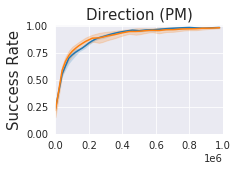

LENGTHS [1078277, 1117491, 992818]
setting shortest len to X_max 250000
LENGTHS [275090, 269042, 295891]
setting shortest len to X_max 250000
plotting None
plotting #ff7f0e


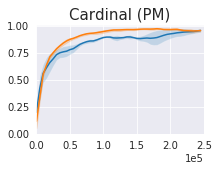

LENGTHS [2304374, 2324235, 2322814]
setting shortest len to X_max 250000
LENGTHS [1182558, 869910, 946990]
setting shortest len to X_max 250000
plotting None
plotting #ff7f0e


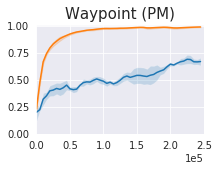

LENGTHS [19360000, 24720000, 23920000]
setting shortest len to X_max 1500000
LENGTHS [1343634, 1345870, 1383184]
setting shortest len to X_max 1500000
plotting None
plotting #ff7f0e


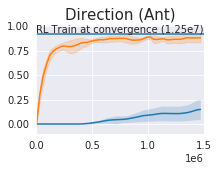

LENGTHS [15809152, 16720775, 16250226]
setting shortest len to X_max 50000
LENGTHS [56942, 59367, 52237]
setting shortest len to X_max 50000
plotting None
plotting #ff7f0e


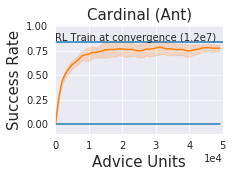

LENGTHS [13485415, 9632564, 9672602]
setting shortest len to X_max 100000
LENGTHS [85586, 98028, 87578]
setting shortest len to X_max 100000
plotting None
plotting #ff7f0e


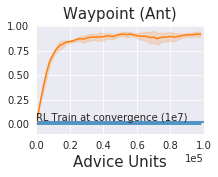

LENGTHS [1725448, 1687721, 1638585]
setting shortest len to X_max 1000000
LENGTHS [1698801, 1779026, 1739110]
setting shortest len to X_max 1000000
plotting None
plotting #ff7f0e


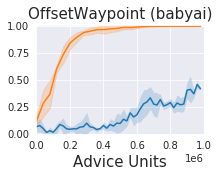

LENGTHS [4365589, 4354493, 4255389]
LENGTHS [843189, 3436731, 3523471]
plotting None
plotting #ff7f0e


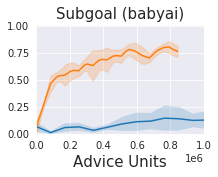

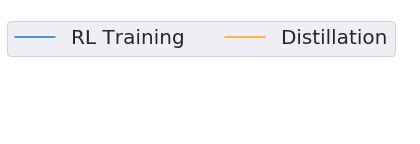

In [373]:
plt.rcParams['figure.figsize'] = [3, 2]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Advice Units"

runs = [
        (['K000', 'K001', 'K002'], 'RL training'),
        (['K144', 'K145', 'K146'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=outside_y_label, x_max=1000000, save_name='bootstrap_direction_pm.png')



runs = [
        (['K003', 'K004', 'K005'], 'RL training'),
        (['K147', 'K148', 'K149'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=250000, save_name='bootstrap_cardinal_pm.png')


runs = [
        (['K006', 'K007', 'K008'], 'RL training'),
        (['K150', 'K151', 'K152'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=250000, save_name='bootstrap_waypoint_pm.png')




runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1, '#ff7f0e', None),
]
plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
                             x_label=inside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_direction_ant.png',
                            x_max=1500000)


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1, '#ff7f0e', None),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=outside_y_label,
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.png',
                            x_max=50000)

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1, '#ff7f0e', None),
]
plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.png',
                            x_max=100000)



# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



x_label = 'Advice Units'

runs = [
        (['K336', 'K337', 'K338'], 'RL Training'),
        (['K249b', 'K250b', 'K251b'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', y_label=inside_y_label, 
                             save_name='bootstrap_waypoint_babyai.png', x_max=1000000)


runs = [
        (['K339', 'K340', 'K341'], 'RL Training'),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, save_name='bootstrap_subgoal_babyai.png')


lines = [mlines.Line2D([], [], label='RL Training'),
         mlines.Line2D([], [], c='orange', label='Distillation')]
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=2)
plt.savefig('figs/bootstrap_legend.png', bbox_inches='tight')
plt.show()

# #         plt.box(False)
#         for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
# #             print("MAX", np.max(y_transform(y_data)))
#             plt.plot(x_data, y_transform(y_data))
#             plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
#             plt.xlim(-10, 0)
#             plt.ylim(-2, -1)
#             plt.legend(policy_list, fontsize=20)
#         plt.box(False)
#         plt.axis('off')
#         if save_name is not None:
#             plt.savefig('figs/legend_' + save_name)
#         plt.show()


LENGTHS [4696291, 4564532, 4700783]
LENGTHS [1237347, 1241609, 1236065]
plotting None
plotting #ff7f0e


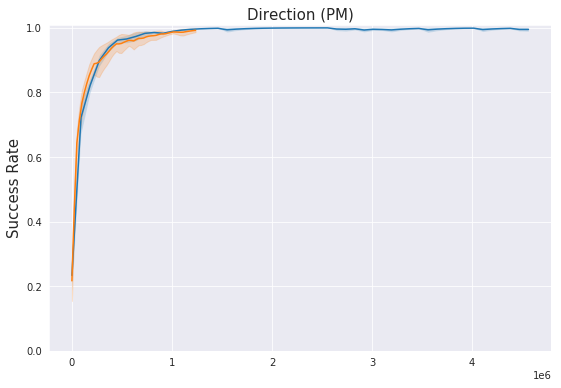

LENGTHS [1078277, 1117491, 992818]
LENGTHS [275090, 269042, 295891]
plotting None
plotting #ff7f0e


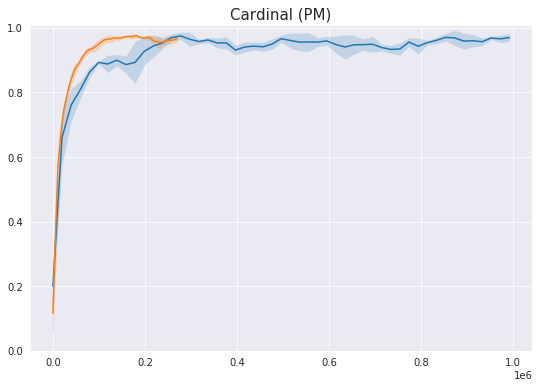

LENGTHS [2304374, 2324235, 2322814]
LENGTHS [1182558, 869910, 946990]
plotting None
plotting #ff7f0e


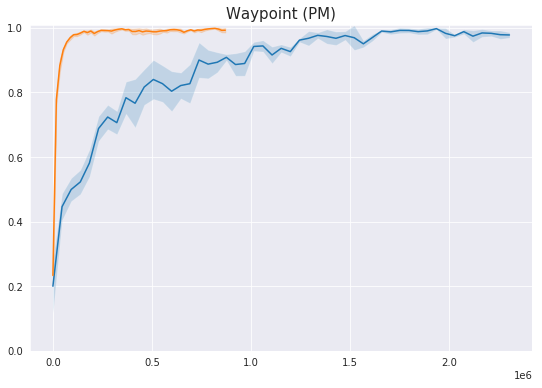

LENGTHS [19360000, 24720000, 23920000]
LENGTHS [1343634, 1345870, 1383184]
plotting None
plotting #ff7f0e


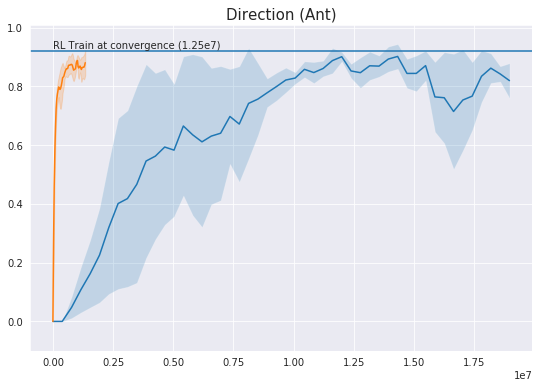

LENGTHS [15809152, 16720775, 16250226]
LENGTHS [56942, 59367, 52237]
plotting None
plotting #ff7f0e


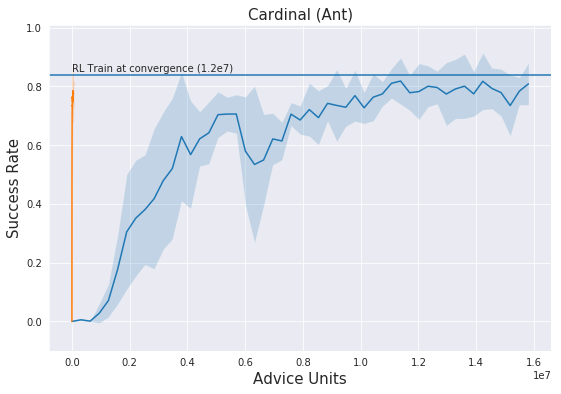

LENGTHS [13485415, 9632564, 9672602]
LENGTHS [85586, 98028, 87578]
plotting None
plotting #ff7f0e


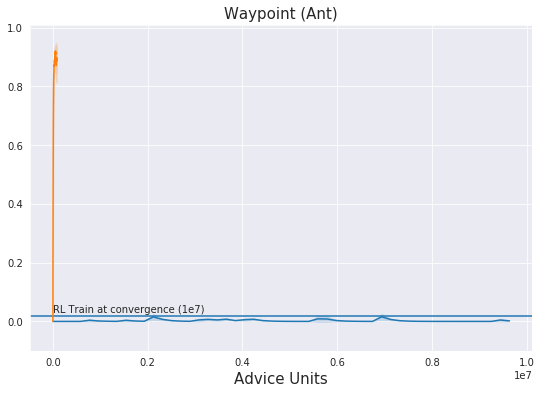

LENGTHS [1725448, 1687721, 1638585]
LENGTHS [1698801, 1779026, 1739110]
plotting None
plotting #ff7f0e


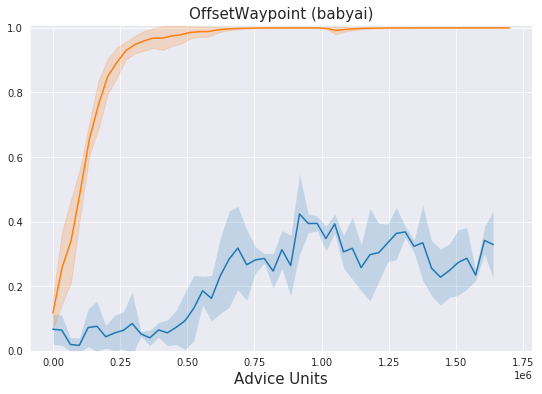

LENGTHS [4878222, 4851373, 4765754]
LENGTHS [843189, 3436731, 3523471]
plotting None
plotting #ff7f0e


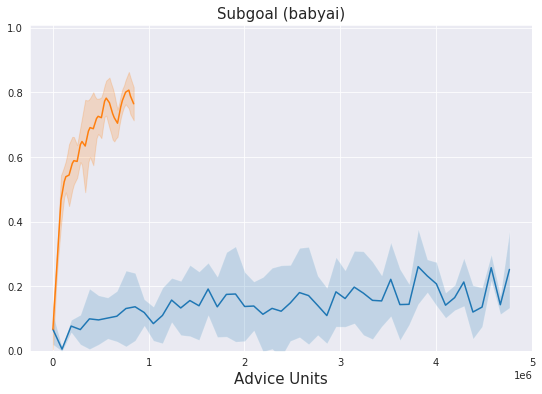

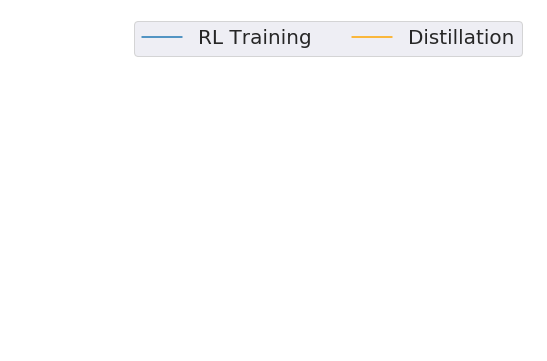

In [377]:
plt.rcParams['figure.figsize'] = [9, 6]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Advice Units"

runs = [
        (['K000', 'K001', 'K002'], 'RL training'),
        (['K144', 'K145', 'K146'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=outside_y_label, save_name='bootstrap_direction_pm.png')



runs = [
        (['K003', 'K004', 'K005'], 'RL training'),
        (['K147', 'K148', 'K149'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, save_name='bootstrap_cardinal_pm.png')


runs = [
        (['K006', 'K007', 'K008'], 'RL training'),
        (['K150', 'K151', 'K152'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, save_name='bootstrap_waypoint_pm.png')




runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1, '#ff7f0e', None),
]
# plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
                             x_label=inside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_direction_ant.png')


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1, '#ff7f0e', None),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
# plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=outside_y_label,
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.png')

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1, '#ff7f0e', None),
]
# plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.png')



# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



x_label = 'Advice Units'

runs = [
        (['K336', 'K337', 'K338'], 'RL Training'),
        (['K249b', 'K250b', 'K251b'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', y_label=inside_y_label, 
                             save_name='bootstrap_waypoint_babyai.png')


runs = [
        (['K339', 'K340', 'K341'], 'RL Training'),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, save_name='bootstrap_subgoal_babyai.png')


lines = [mlines.Line2D([], [], label='RL Training'),
         mlines.Line2D([], [], c='orange', label='Distillation')]
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=2)
plt.savefig('figs/bootstrap_legend.png', bbox_inches='tight')
plt.show()

# #         plt.box(False)
#         for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
# #             print("MAX", np.max(y_transform(y_data)))
#             plt.plot(x_data, y_transform(y_data))
#             plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
#             plt.xlim(-10, 0)
#             plt.ylim(-2, -1)
#             plt.legend(policy_list, fontsize=20)
#         plt.box(False)
#         plt.axis('off')
#         if save_name is not None:
#             plt.savefig('figs/legend_' + save_name)
#         plt.show()


# THIRD PLOT

LENGTHS [1080000, 1120000, 1080000]
LENGTHS [812204, 836186, 779879]
LENGTHS [236981, 218249, 218778]
LENGTHS [200086, 181428, 221993]
LENGTHS [1840000, 1640000, 1400000]
LENGTHS [6960000, 6200000, 5920000]
LENGTHS [667278, 650730, 671137]
plotting red
plotting green
plotting blue
plotting purple
plotting [0.6, 0.6, 0.6, 1]
plotting [0.6, 0.6, 0.6, 1]
plotting [0.65, 0.65, 0.65, 1]


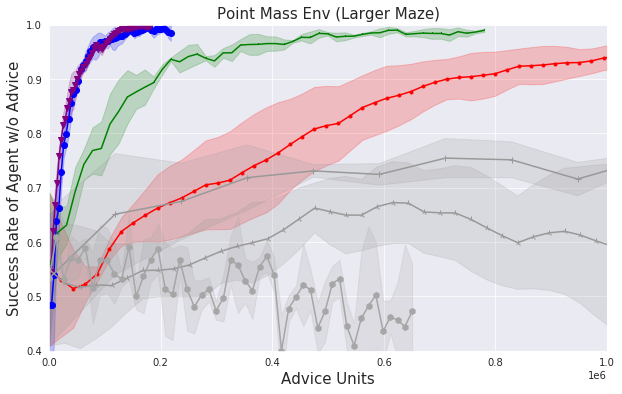

LENGTHS [9786000, 9996000, 10290000]
LENGTHS [817216, 1047082, 1278881]
LENGTHS [237907, 245840, 225448]
LENGTHS [6520000, 6560000, 6560000]
plotting red
plotting green
plotting purple
plotting [0.6, 0.6, 0.6, 1]


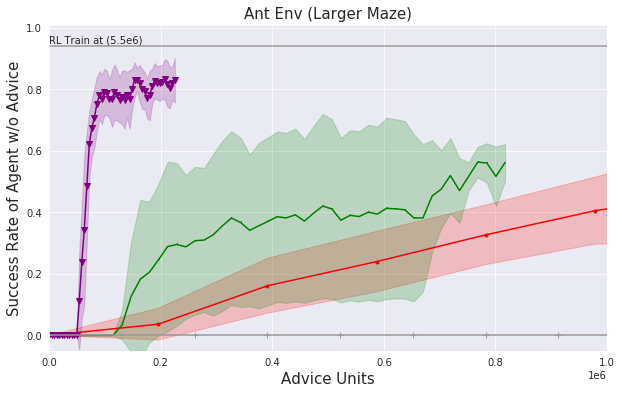

LENGTHS [75000, 75000, 80000]
LENGTHS [8139, 9014, 9500]
LENGTHS [9666, 7828, 11438]
LENGTHS [390000, 400000, 420000]
plotting orange
plotting purple
plotting brown
plotting [0.6, 0.6, 0.6, 1]


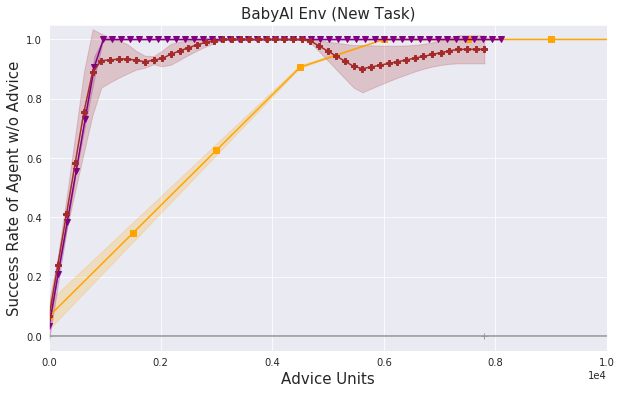

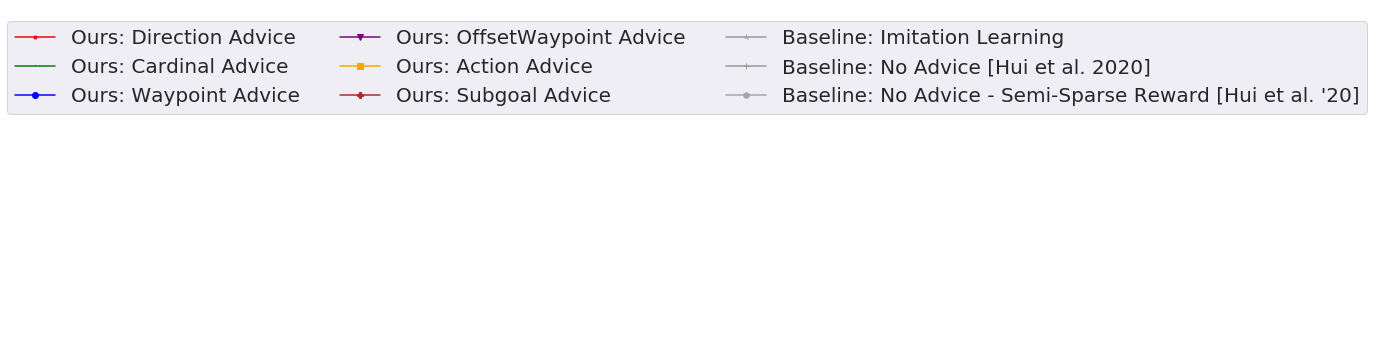

In [54]:
plt.rcParams['figure.figsize'] = [10, 6]

y_label = 'Success Rate of Agent w/o Advice'

# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, gray3, '2'),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', 1, gray3, '+'),
    (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, gray2, 'h'),
]
plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Point Mass Env (Larger Maze)', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0.4, y_max=1, save_name='distill_pm_l3.png', x_max=1000000)



# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K189', 'K190', 'K191'], 'RL No hints', 1, gray3, '+'),
]
plt.xlim(0, 1000000)
add_line(.94, 'RL Train at (5.5e6)', color=gray3)
plot_finetune_generalization(runs, 'Ant Env (Larger Maze)', metric=metric, smooth=10, x_label='Advice Units', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l0.png', x_max=1000000)




# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', 1, 'orange', 's'),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', 1, 'brown', 'P'),
    (['K435', 'K436', 'K437'], 'RL Finetune', 1, gray3, '+'),
]
plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'BabyAI Env (New Task)', smooth=1, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=-.05, y_max=1.05, save_name='distill_babyai_l30.png', x_max=10000)


# LEGEND
legend = [
    ('Ours: Direction Advice', '.', 'red'),
    ('Ours: Cardinal Advice', ',', 'green'),
    ('Ours: Waypoint Advice', 'o', 'blue'),
    ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
    ('Ours: Action Advice', 's', 'orange'),
    ('Ours: Subgoal Advice', 'P', 'brown'),
    ("Baseline: Imitation Learning", '2', gray3),
    ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
    ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/distill_legend.png', bbox_inches='tight')
plt.show()


LENGTHS [2280000, 2120000, 2280000]
LENGTHS [710703, 686464, 649023]
LENGTHS [216888, 203312, 232522]
LENGTHS [203511, 184565, 193021]
LENGTHS [2520000, 2520000, 2360000]
LENGTHS [11680000, 11280000, 11440000]
LENGTHS [934425, 956752, 982907]
plotting red
plotting green
plotting blue
plotting purple
plotting [0.6, 0.6, 0.6, 1]
plotting [0.6, 0.6, 0.6, 1]
plotting [0.65, 0.65, 0.65, 1]


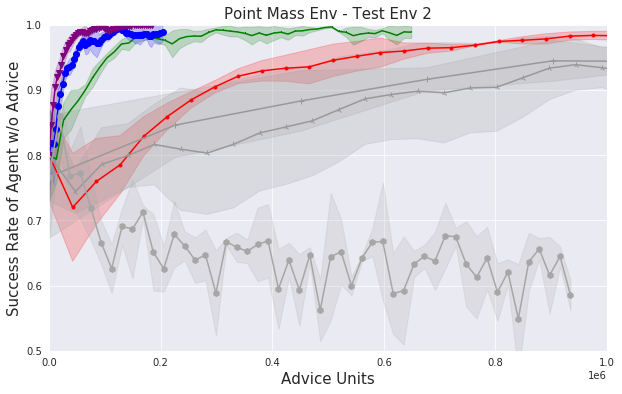

LENGTHS [2920000, 3080000, 2920000]
LENGTHS [1084825, 1070056, 1076022]
LENGTHS [339989, 331250, 280222]
LENGTHS [361864, 381245, 369744]
LENGTHS [2680000, 3240000, 3480000]
LENGTHS [1520000, 1520000, 1520000]
plotting red
plotting green
plotting blue
plotting purple
plotting [0.6, 0.6, 0.6, 1]
plotting [0.6, 0.6, 0.6, 1]


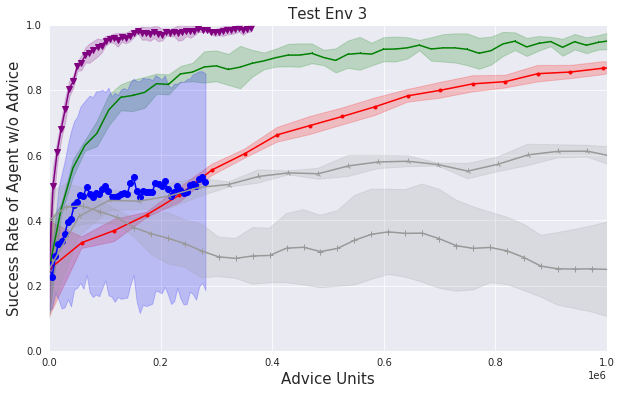

LENGTHS [2240000, 4000000, 4360000]
LENGTHS [740344, 751782, 830017]
LENGTHS [607845, 753865, 762098]
LENGTHS [684970, 968963, 913666]
LENGTHS [3000000, 2720000, 3320000]
LENGTHS [1240000, 1200000, 1240000]
plotting red
plotting green
plotting blue
plotting purple
plotting [0.6, 0.6, 0.6, 1]
plotting [0.6, 0.6, 0.6, 1]


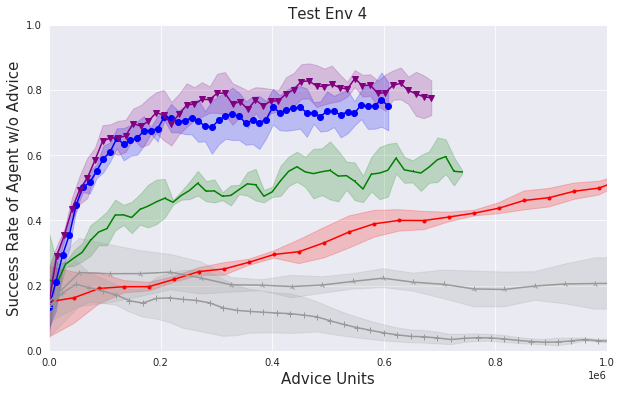

LENGTHS [4752000, 4904000, 200000]
LENGTHS [214260, 193854, 451535]
LENGTHS [123288, 115097, 141769]
LENGTHS [3480000, 3560000, 3160000]
plotting red
plotting green
plotting purple
plotting [0.6, 0.6, 0.6, 1]


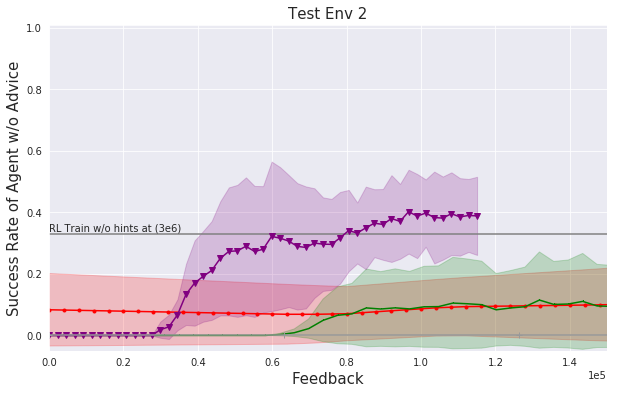

Error on  ['K222', 'K223', 'K224'] ("Didn't find exactly 1 run name", [])
LENGTHS [446889, 269989, 1199548]
LENGTHS [142605, 106434, 248499]
LENGTHS [2520000, 2560000, 2720000]
plotting green
plotting purple
plotting [0.6, 0.6, 0.6, 1]


In [59]:
# L2
runs = [
    (['K045', 'K046', 'K047'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K048', 'K049', 'K050'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K051', 'K052', 'K053'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
    (['K054', 'K055', 'K056'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K066', 'K067', 'K068'], 'Distill - Demonstrations', 1, gray3, '2'),
#     (['T3916'], 'RL Finetune (waypoint reward from scratch)', 1),
#     (['K060', 'K061', 'K062'], 'RL Finetune (sparse reward)', 1),
    (['K063', 'K064', 'K065'], 'RL Finetune - Dense Reward', 1, gray3, '+'),
    (['K057', 'K058', 'K059'], 'RL Finetune - Semi-Sparse Reward', 1, gray2, 'h'),
#     (['K351', 'K352', 'K353'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K354', 'K355', 'K356'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]

plot_finetune_generalization(runs, 'Point Mass Env - Test Env 2', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0.5, y_max=1, save_name='distill_pm_l2.png',
                            x_min=0, x_max=1000000)



# L3
# runs = [
#     (['K069', 'K070', 'K071'], 'Distill - Direction Advice', 1, 'red', '.'),
#     (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', 1, 'green', ','),
#     (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
#     (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
#     (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, gray3, '2'),
#     (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', 1, gray3, '+'),
#     (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, gray2, 'h'),
# ]
# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Point Mass Env (Larger Maze)', smooth=10, 
#                              x_label='Advice Units', y_label=y_label,
#                             y_min=0.4, y_max=1, save_name='distill_pm_l3.png', x_max=1000000)

# L13
runs = [
    (['K093', 'K094', 'K095'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K096', 'K097', 'K098'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K099', 'K100', 'K101'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
    (['K102', 'K103', 'K104'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K114', 'K115', 'K116'], 'Distill - Demonstrations', 1, gray3, '2'),
#     (['K105', 'K106', 'K107'], 'RL Finetune (waypoint reward)', 1),
#     (['K108', 'K109', 'K110'], 'RL Finetune (sparse reward)', 1),
    (['K111', 'K112', 'K113'], 'RL Finetune - Dense Reward', 1, gray3, '+'),
#     (['K363', 'K364', 'K365'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K366', 'K367', 'K368'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Test Env 3', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0, y_max=1, save_name='distill_pm_l13.png', x_max=1000000)


# L14
runs = [
    (['K117', 'K118', 'K119'], 'Distill - Direction Advice', 1, 'red', '.'),
#     (['K120', 'K121', 'K122'], 'Distill from Cardinal', 1),
    (['K141', 'K142', 'K143'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K123', 'K124', 'K125'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
    (['K126', 'K127', 'K128'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K138', 'K139', 'K140'], 'Distill - Demonstrations', 1, gray3, '2'),
#     (['K129', 'K130', 'K131'], 'RL Finetune (waypoint reward)', 1),
#     (['K132', 'K133', 'K134'], 'RL Finetune (sparse reward)', 1),
    (['K135', 'K136', 'K137'], 'RL Finetune - Dense Reward', 1, gray3, '+'),
#     (['K369', 'K370', 'K371'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K372', 'K373', 'K374'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Test Env 4', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0, y_max=1, save_name='distill_pm_l14.png', x_max=1000000)




# L2
runs = [
#     (['K207', 'K208', 'K209'], 'Distill Direction', 1),
#     (['K208'], 'Distill Direction', 1),
#     (['K321', 'K322'], 'Distill Direction (finetune)', 1),
    (['K321', 'K322', 'K323'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K210', 'K211', 'K212'], 'Distill - Cardinal Advice', 1, 'green', ','),
#     (['K213', 'K214', 'K215'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
#     (['K216', 'K217', 'K218'], 'Distill OffsetWaypoint', 1),
#     (['K216', 'K217'], 'Distill OffsetWaypoint', 1),
    (['K324', 'K325', 'K326'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K219', 'K220', 'K221'], 'RL No hints', 1, gray3, '+'),
]
# plt.xlim(0, 150000)
add_line(.33, 'RL Train w/o hints at (3e6)', color='gray')
plot_finetune_generalization(runs, 'Test Env 2', metric=metric, smooth=10, x_label='Feedback', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l2.png', x_max=150000)

# L3
runs = [
    (['K222', 'K223', 'K224'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K225', 'K226', 'K227'], 'Distill - Cardinal Advice', 1, 'green', ','),
#     (['K228', 'K229', 'K230'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
#     (['K231', 'K232', 'K233'], 'Distill OffsetWaypoint', 1),
    (['K330', 'K331', 'K332'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K234', 'K235', 'K236'], 'RL No hints', 1, gray3, '+'),
]
# plt.xlim(0, 200000)
add_line(.16, 'RL Train at (2e6)', color='gray')
plot_finetune_generalization(runs, 'Test Env 3', metric=metric, smooth=10, 
                             x_label='Feedback', y_label=y_label, y_min=-.1, y_max=.4, 
                             save_name='distill_ant_l3.png', x_max=200000)


LENGTHS [1080000, 1120000, 1080000]
LENGTHS [812204, 836186, 779879]
LENGTHS [236981, 218249, 218778]
LENGTHS [200086, 181428, 221993]
LENGTHS [6960000, 6200000, 5920000]
plotting red
plotting green
plotting blue
plotting purple
plotting [0.6, 0.6, 0.6, 1]


LENGTHS [9786000, 9996000, 10290000]
LENGTHS [574017, 697280, 1043719]
LENGTHS [237907, 245840, 225448]
LENGTHS [6520000, 6560000, 6560000]
plotting red
plotting green
plotting purple
plotting [0.6, 0.6, 0.6, 1]


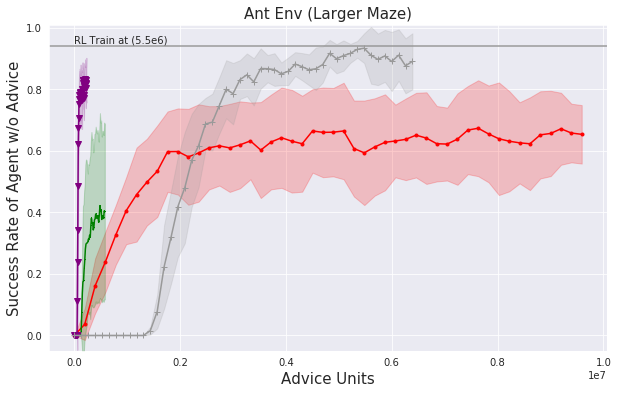

LENGTHS [75000, 75000, 80000]
LENGTHS [8139, 9014, 9500]
LENGTHS [9666, 7828, 11438]
LENGTHS [390000, 400000, 420000]
plotting orange
plotting purple
plotting brown
plotting [0.6, 0.6, 0.6, 1]


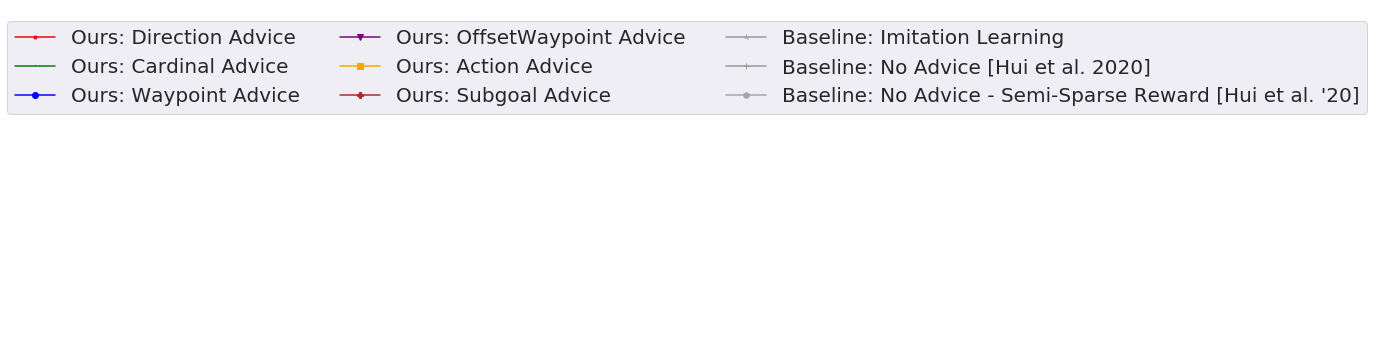

In [378]:
plt.rcParams['figure.figsize'] = [10, 6]

y_label = 'Success Rate of Agent w/o Advice'

# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
#     (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, gray3, '2'),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', 1, gray3, '+'),
#     (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, gray2, 'h'),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Point Mass Env (Larger Maze)', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0.4, y_max=1, save_name='distill_pm_l3.png')



# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K189', 'K190', 'K191'], 'RL No hints', 1, gray3, '+'),
]
# plt.xlim(0, 1000000)
add_line(.94, 'RL Train at (5.5e6)', color=gray3)
plot_finetune_generalization(runs, 'Ant Env (Larger Maze)', metric=metric, smooth=10, x_label='Advice Units', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l0.png')




# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', 1, 'orange', 's'),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', 1, 'brown', 'P'),
    (['K435', 'K436', 'K437'], 'RL Finetune', 1, gray3, '+'),
]
# plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'BabyAI Env (New Task)', smooth=1, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=-.05, y_max=1.05, save_name='distill_babyai_l30.png')


# LEGEND
legend = [
    ('Ours: Direction Advice', '.', 'red'),
    ('Ours: Cardinal Advice', ',', 'green'),
    ('Ours: Waypoint Advice', 'o', 'blue'),
    ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
    ('Ours: Action Advice', 's', 'orange'),
    ('Ours: Subgoal Advice', 'P', 'brown'),
    ("Baseline: Imitation Learning", '2', gray3),
    ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
    ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/distill_legend.png', bbox_inches='tight')
plt.show()


# Sample Plots

RUN NAMES ['K000', 'K001', 'K002']
LENGTHS [1120, 1085, 1111]
RUN NAMES ['K003', 'K004', 'K005']
LENGTHS [1186, 1192, 1158]
RUN NAMES ['K006', 'K007', 'K008']
LENGTHS [4186, 4239, 4173]
RUN NAMES ['K009', 'K010', 'K011']
LENGTHS [1112, 1140, 1109]
RUN NAMES ['K015', 'K016', 'K017']
LENGTHS [10470, 16399, 16253]
RUN NAMES ['K018', 'K019', 'K020']
LENGTHS [1043, 1009, 1044]
RUN NAMES ['K348', 'K349', 'K350']
LENGTHS [202, 200, 190]
RUN NAMES ['K345', 'K346', 'K347']
LENGTHS [259, 251, 249]


RUN NAMES ['K153', 'K154', 'K155']
LENGTHS [2430, 3091, 2999]
RUN NAMES ['K156', 'K157', 'K158']
LENGTHS [3968, 4093, 3990]
RUN NAMES ['K159', 'K160', 'K161']
LENGTHS [3364, 2400, 2414]
RUN NAMES ['K162', 'K163', 'K164']
LENGTHS [3289, 3356, 3189]
RUN NAMES ['K165', 'K166', 'K167']
LENGTHS [4406, 2873, 2933]
RUN NAMES ['K375', 'K376', 'K377']
LENGTHS [2631, 2610, 2478]
RUN NAMES ['K378', 'K379', 'K380']
LENGTHS [2564, 2540, 2530]


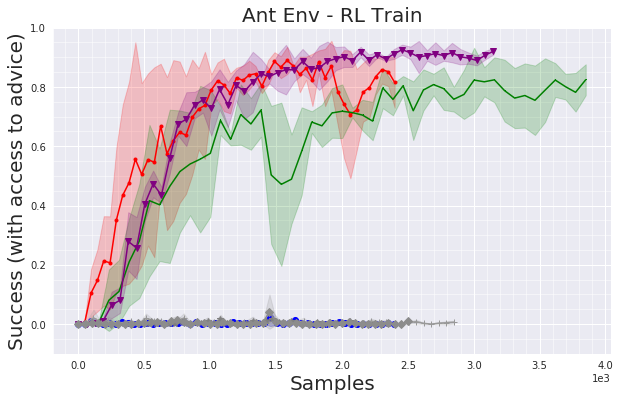

RUN NAMES ['K333_1', 'K334', 'K335']
LENGTHS [6005, 5980, 6169]
RUN NAMES ['K336', 'K337', 'K338']
LENGTHS [1702, 1670, 1617]
RUN NAMES ['K339', 'K340', 'K341']
LENGTHS [16030, 15844, 16018]
RUN NAMES ['K342', 'K343', 'K344']
LENGTHS [13828, 13250, 14390]
RUN NAMES ['K381', 'K382', 'K383']
LENGTHS [3380, 3330, 3430]


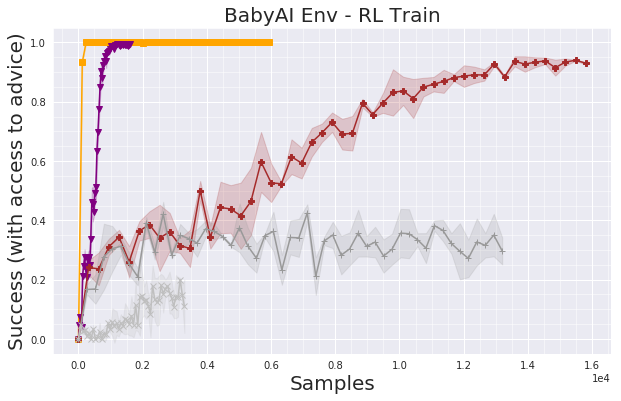

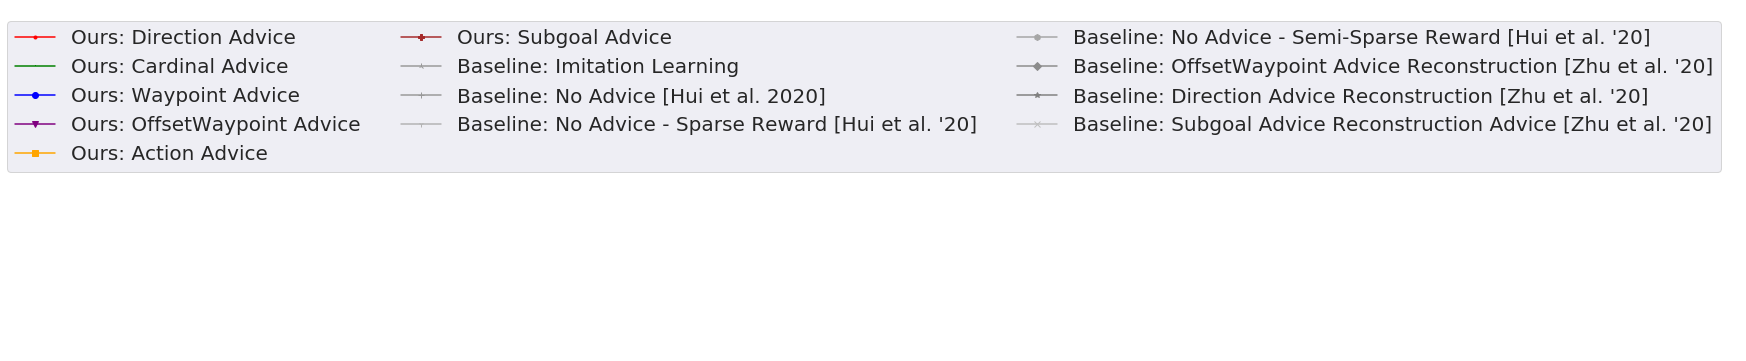

In [51]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'samples'

metrics = [
    'Train/Success',
]

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Samples"



gray0 = [.75, 0.75, 0.75, 1]
gray1 = [.7, 0.7, 0.7, 1]
gray2 = [.65, 0.65, 0.65, 1]
gray3 = [.6, 0.6, 0.6, 1]
gray4 = [.55, 0.55, 0.55, 1]
gray5 = [.5, 0.5, 0.5, 1]

data_names = [
        (['K000', 'K001', 'K002'], 'Direction Advice', 'red', '.'),
        (['K003', 'K004', 'K005'], 'Cardinal Advice', 'green', ','),
        (['K006', 'K007', 'K008'], 'Waypoint Advice', 'blue', 'o'),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K000', 'K001', 'K002'], 'Direction Advice', [0, 0, .5, 1], '.'),
#         (['K003', 'K004', 'K005'], 'Cardinal Advice', [0, 0, .7, 1], ','),
#         (['K006', 'K007', 'K008'], 'Waypoint Advice', [0, 0, 1, 1], 'o'),
#         (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', [0, 0, 1, 1], 'v'),
        (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward', gray1, '1'),
#         (['K012', 'K013', 'K014'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
        (['K018', 'K019', 'K020'], 'Baseline: No Advice', gray3, '+'),
        (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction', gray4, 'D'),
        (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction', gray5, '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm_samples.png', x_min=0, x_max=5000)

data_names = [
        (['K153', 'K154', 'K155'], 'Direction Advice', 'red', '.'),
        (['K156', 'K157', 'K158'], 'Cardinal Advice', 'green', ','),
        (['K159', 'K160', 'K161'], 'Waypoint Advice', 'blue', 'o'),
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', 'purple', 'v'),
    
        (['K165', 'K166', 'K167'], 'No Advice', gray3, '+'),
        (['K375', 'K376', 'K377'], 'Direction Advice Reconstruction', gray5, '*'),
        (['K378', 'K379', 'K380'], 'OffsetWaypoint Advice Reconstruction', gray4, 'D'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant_samples.png', x_max=None)


runs = [
        (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
        (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
        (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),
        (['K342', 'K343', 'K344'], 'Baseline: No Advice', gray3, '+'),
        (['K381', 'K382', 'K383'], 'Baseline: Subgoal Advice Reconstruction', gray0, 'x'),
    ]


plot_curriculum(runs, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="BabyAI Env - RL Train",
               y_lower=-0.05, y_upper=1.05, y_label="Success (with access to advice)", 
                save_name='rl_train_babyai_samples.png', x_max=None)


# LEGEND
legend = [
    ('Ours: Direction Advice', '.', 'red'),
    ('Ours: Cardinal Advice', ',', 'green'),
    ('Ours: Waypoint Advice', 'o', 'blue'),
    ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
    ('Ours: Action Advice', 's', 'orange'),
    ('Ours: Subgoal Advice', 'P', 'brown'),
    ("Baseline: Imitation Learning", '2', gray3),
    ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
    ("Baseline: No Advice - Sparse Reward [Hui et al. '20]", '1', gray1),
    ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
    
    ("Baseline: OffsetWaypoint Advice Reconstruction [Zhu et al. '20]", 'D', gray4),
    ("Baseline: Direction Advice Reconstruction [Zhu et al. '20]", '*', gray5),
    ("Baseline: Subgoal Advice Reconstruction Advice [Zhu et al. '20]", 'x', gray0),

]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/rl_train_legend.png', bbox_inches='tight')
plt.show()
    

LENGTHS [18785164000, 18258128000, 18803132000]
LENGTHS [4949388000, 4966436000, 4944260000]
plotting None
plotting #ff7f0e


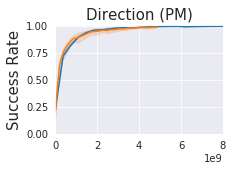

LENGTHS [4313108000, 4469964000, 3971272000]
LENGTHS [1100360000, 1076168000, 1183564000]
plotting None
plotting #ff7f0e


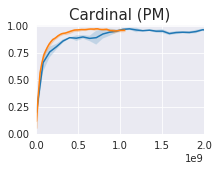

LENGTHS [9217496000, 9296940000, 9291256000]
LENGTHS [4730232000, 3479640000, 3787960000]
plotting None
plotting #ff7f0e


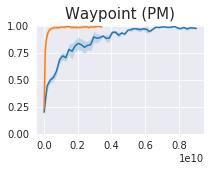

LENGTHS [77440000000, 98880000000, 95680000000]
LENGTHS [5374536000, 5383480000, 5532736000]
plotting None
plotting #ff7f0e


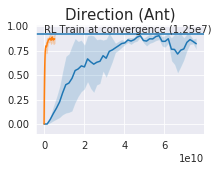

LENGTHS [1584000.0, 1636000.0, 1596000.0]
LENGTHS [160000.0, 160000.0, 160000.0]
plotting None
plotting #ff7f0e


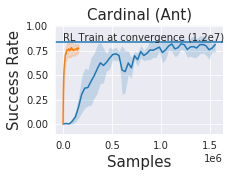

LENGTHS [1344000.0, 960000.0, 964000.0]
LENGTHS [236000.0, 252000.0, 256000.0]
plotting None
plotting #ff7f0e


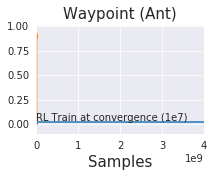

LENGTHS [680000.0, 664000.0, 644000.0]
LENGTHS [168000.0, 176000.0, 172000.0]
plotting None
plotting #ff7f0e


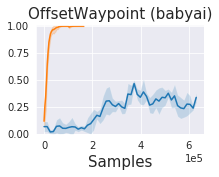

LENGTHS [6408000.0, 6336000.0, 6404000.0]
LENGTHS [80000.0, 320000.0, 328000.0]
plotting None
plotting #ff7f0e


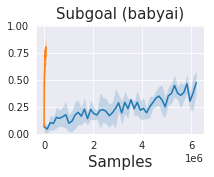

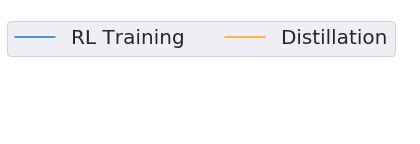

In [52]:
plt.rcParams['figure.figsize'] = [3, 2]
metrics = [
    'Train/Success',
]
x_label = 'Samples'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Samples"

frames_per_proc = 200
num_envs = 20
samples_per_itr = frames_per_proc * num_envs


runs = [
        (['K000', 'K001', 'K002'], 'RL training', samples_per_itr),
        (['K144', 'K145', 'K146'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=outside_y_label, x_max=2e6 * samples_per_itr, save_name='bootstrap_direction_pm_samples.png')



runs = [
        (['K003', 'K004', 'K005'], 'RL training', samples_per_itr),
        (['K147', 'K148', 'K149'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=0.5e6 * samples_per_itr, save_name='bootstrap_cardinal_pm_samples.png')


runs = [
        (['K006', 'K007', 'K008'], 'RL training', samples_per_itr),
        (['K150', 'K151', 'K152'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=None, save_name='bootstrap_waypoint_pm_samples.png')




runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints', samples_per_itr),
        (['K168', 'K169', 'K170'], 'Off -> Dir', samples_per_itr, '#ff7f0e', None),
]
# plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
                             x_label=inside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_direction_ant_samples.png',
                            x_max=None)


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints', samples_per_itr),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', samples_per_itr, '#ff7f0e', None),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
# plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=outside_y_label,
                            y_min=-0.1, save_name='bootstrap_cardinal_ant_samples.png',
                            x_max=None)

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints', samples_per_itr),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', samples_per_itr, '#ff7f0e', None),
]
# plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_waypoint_ant_samples.png',
                            x_max=1e6 * samples_per_itr)



# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



x_label = 'Advice Units'

runs = [
        (['K336', 'K337', 'K338'], 'RL Training', samples_per_itr),
        (['K249b', 'K250b', 'K251b'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', y_label=inside_y_label, 
                             save_name='bootstrap_waypoint_babyai_samples.png', x_max=None)


runs = [
        (['K339', 'K340', 'K341'], 'RL Training', samples_per_itr),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, save_name='bootstrap_subgoal_babyai_samples.png')


lines = [mlines.Line2D([], [], label='RL Training'),
         mlines.Line2D([], [], c='orange', label='Distillation')]
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=2)
plt.savefig('figs/bootstrap_legend_samples.png', bbox_inches='tight')
plt.show()

# #         plt.box(False)
#         for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
# #             print("MAX", np.max(y_transform(y_data)))
#             plt.plot(x_data, y_transform(y_data))
#             plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
#             plt.xlim(-10, 0)
#             plt.ylim(-2, -1)
#             plt.legend(policy_list, fontsize=20)
#         plt.box(False)
#         plt.axis('off')
#         if save_name is not None:
#             plt.savefig('figs/legend_' + save_name)
#         plt.show()


LENGTHS [108000.0, 112000.0, 108000.0]
LENGTHS [456000.0, 452000.0, 452000.0]
LENGTHS [240000.0, 220000.0, 220000.0]
LENGTHS [196000.0, 192000.0, 224000.0]
LENGTHS [696000.0, 620000.0, 592000.0]
plotting red
plotting green
plotting blue
plotting purple
plotting [0.6, 0.6, 0.6, 1]


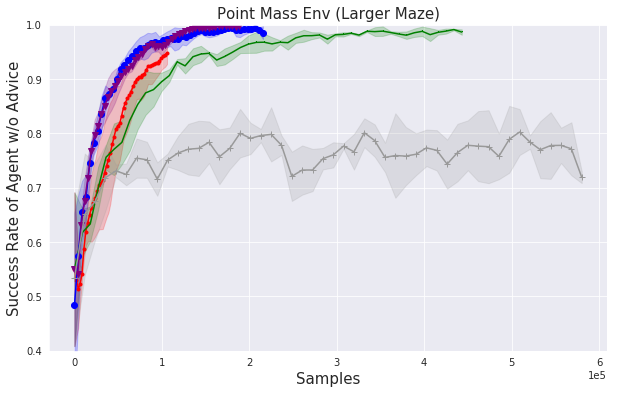

LENGTHS [1048000.0, 1076000.0, 1084000.0]
LENGTHS [1472000.0, 1472000.0, 1452000.0]
LENGTHS [1048000.0, 1084000.0, 1052000.0]
LENGTHS [652000.0, 656000.0, 656000.0]
plotting red
plotting green
plotting purple
plotting [0.6, 0.6, 0.6, 1]


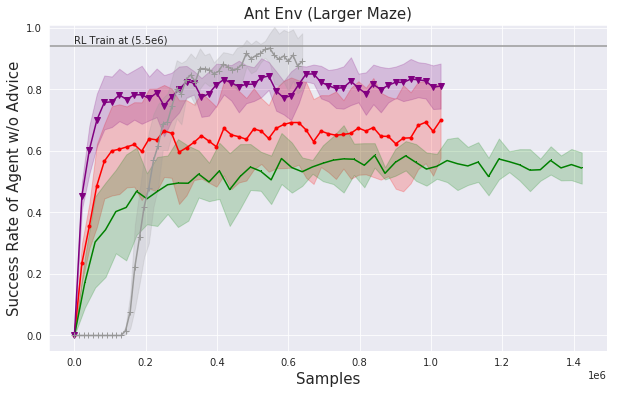

LENGTHS [60000.0, 60000.0, 64000.0]
LENGTHS [36000.0, 40000.0, 40000.0]
LENGTHS [32000.0, 44000.0, 48000.0]
LENGTHS [312000.0, 320000.0, 336000.0]
plotting orange
plotting purple
plotting brown
plotting [0.6, 0.6, 0.6, 1]


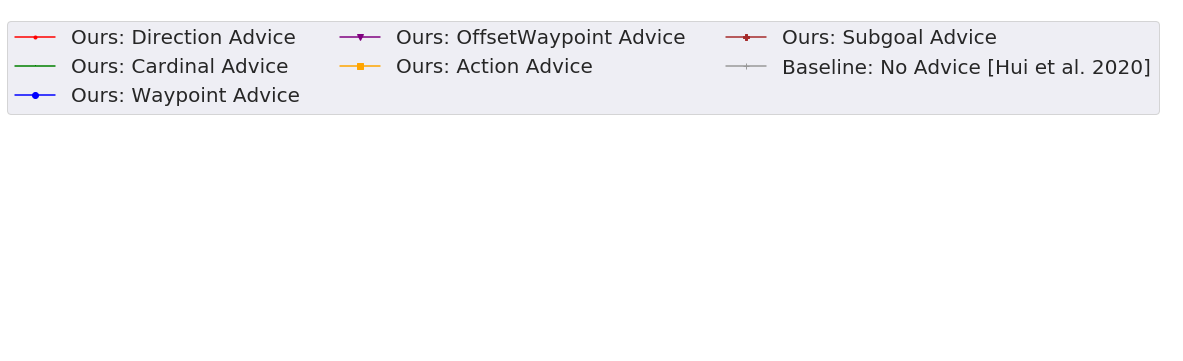

In [99]:
plt.rcParams['figure.figsize'] = [10, 6]

y_label = 'Success Rate of Agent w/o Advice'
metric = 'success_rate'

# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', samples_per_itr, 'red', '.'),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', samples_per_itr, 'green', ','),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', samples_per_itr, 'blue', 'o'),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', samples_per_itr, 'purple', 'v'),
#     (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, gray3, '2'),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', samples_per_itr, gray3, '+'),
#     (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, gray2, 'h'),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Point Mass Env (Larger Maze)', smooth=10, 
                             x_label='Samples', y_label=y_label, 
                            y_min=0.4, y_max=1, save_name='distill_pm_l3_samples.png')



# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', samples_per_itr, 'red', '.'),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', samples_per_itr, 'green', ','),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', samples_per_itr, 'purple', 'v'),
    (['K189', 'K190', 'K191'], 'RL No hints', samples_per_itr, gray3, '+'),
]
# plt.xlim(0, 1000000)
add_line(.94, 'RL Train at (5.5e6)', color=gray3)
plot_finetune_generalization(runs, 'Ant Env (Larger Maze)', metric=metric, smooth=10, x_label='Samples', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l0_samples.png')




# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', samples_per_itr, 'orange', 's'),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', samples_per_itr, 'purple', 'v'),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', samples_per_itr, 'brown', 'P'),
    (['K435', 'K436', 'K437'], 'RL Finetune', samples_per_itr, gray3, '+'),
]
# plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'BabyAI Env (New Task)', smooth=1, 
                             x_label='Samples', y_label=y_label, x_max=.5e5,
                            y_min=-.05, y_max=1.05, save_name='distill_babyai_l30_samples.png')


# LEGEND
legend = [
    ('Ours: Direction Advice', '.', 'red'),
    ('Ours: Cardinal Advice', ',', 'green'),
    ('Ours: Waypoint Advice', 'o', 'blue'),
    ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
    ('Ours: Action Advice', 's', 'orange'),
    ('Ours: Subgoal Advice', 'P', 'brown'),
#     ("Baseline: Imitation Learning", '2', gray3),
    ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
#     ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/distill_legend_samples.png', bbox_inches='tight')
plt.show()


# Supplement Figs

RUN NAMES ['K006', 'K007', 'K008']
LENGTHS [4186, 4239, 4173]
RUN NAMES ['K009', 'K010', 'K011']
LENGTHS [1112, 1140, 1109]


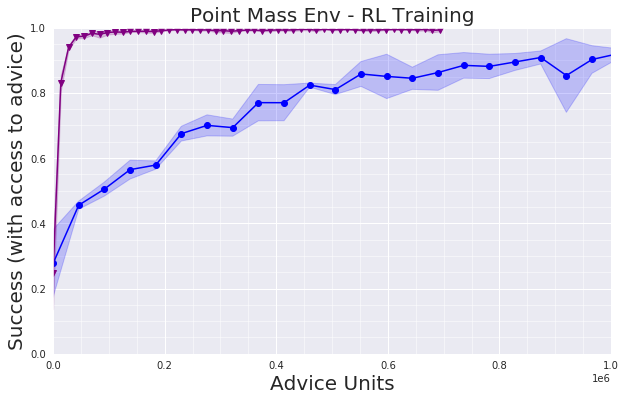

RUN NAMES ['K159', 'K160', 'K161']
LENGTHS [3364, 2400, 2414]
RUN NAMES ['K162', 'K163', 'K164']
LENGTHS [3289, 3356, 3189]


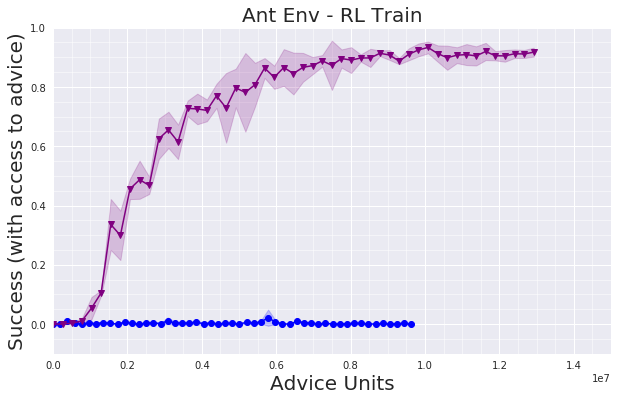

In [62]:
x_label = 'feedback'

data_names = [
        (['K006', 'K007', 'K008'], 'Waypoint Advice', 'blue', 'o'),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', 'purple', 'v'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm_waypoint.png', x_min=0, x_max=1000000)

data_names = [
        (['K159', 'K160', 'K161'], 'Waypoint Advice', 'blue', 'o'),
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', 'purple', 'v'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant_waypoint.png', x_max=15000000)


ENV DICT dict_keys([2, 3, 13, 14])


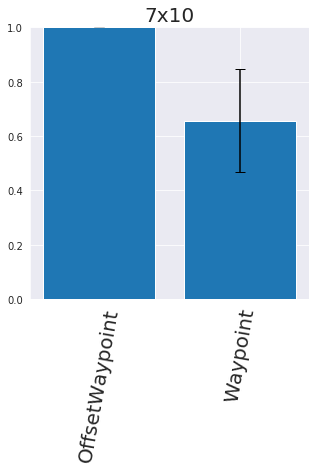

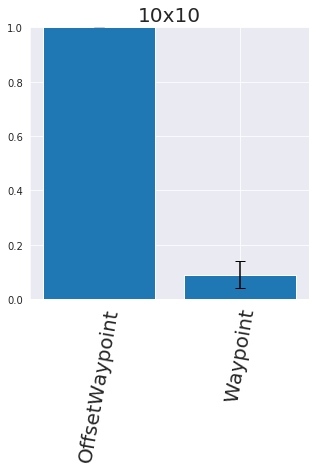

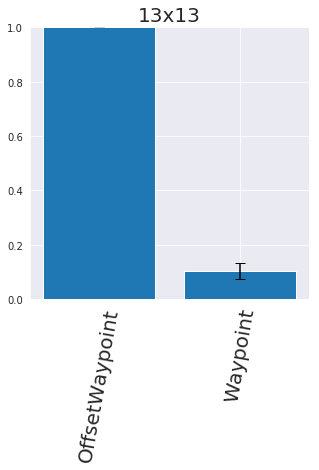

ENV DICT dict_keys([0, 2, 3])


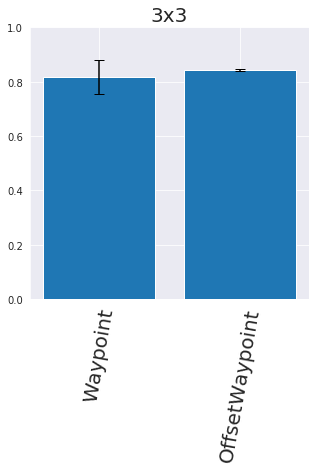

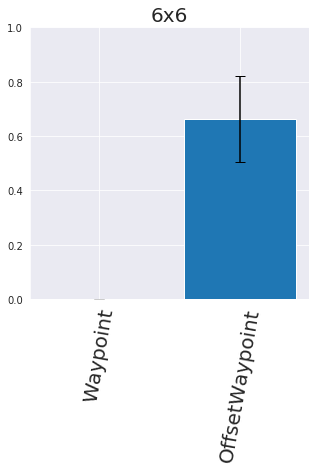

In [92]:
runs = [
    (['K033', 'K034', 'K035'], 'OffsetWaypoint'),
    (['K030', 'K031', 'K032'], 'Waypoint'),
    
]
plt.rcParams['figure.figsize'] = [5, 5]
plot_final_generalization(runs, '', all_env_names=['6x6', '7x10', '10x10', '13x13'], save_name='pm_waypoint_0shot')


runs = [
    (['K455', 'K456', 'K457'], 'Waypoint'),
    (['K201', 'K202', 'K203'], 'OffsetWaypoint'),
]
plot_final_generalization(runs, '', all_env_names=['3x3', '6x6', '7x10'], save_name='ant_waypoint_0shot')

RUN NAMES ['K438', 'K439', 'K440']
LENGTHS [2277, 2254, 2262]
RUN NAMES ['K441', 'K442', 'K443']
LENGTHS [5268, 5217, 5369]
RUN NAMES ['K444', 'K445', 'K446']
LENGTHS [4755, 4744, 4701]
RUN NAMES ['K447', 'K448', 'K449']
LENGTHS [5151, 5217, 5131]


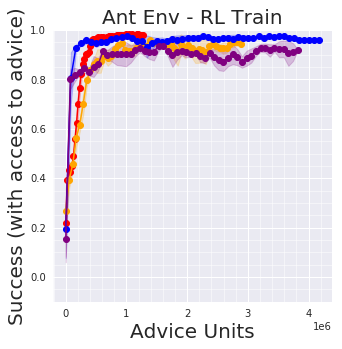

In [98]:
data_names = [
        (['K438', 'K439', 'K440'], 'Waypoint MI', 'red', 'o'),
        (['K441', 'K442', 'K443'], 'Waypoint no MI', 'orange', 'o'),
        (['K444', 'K445', 'K446'], 'Cardinal MI', 'blue', 'o'),
        (['K447', 'K448', 'K449'], 'Cardinal no MI', 'purple', 'o'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant_waypoint.png')

ENV DICT dict_keys([2, 3, 13, 14])


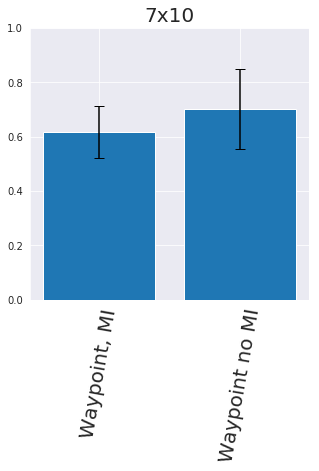

ENV DICT dict_keys([2, 3, 13, 14])


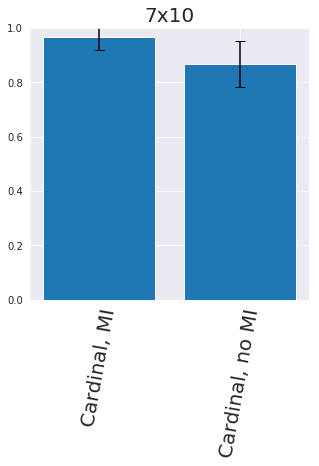

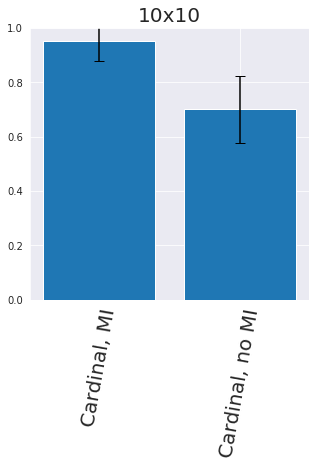

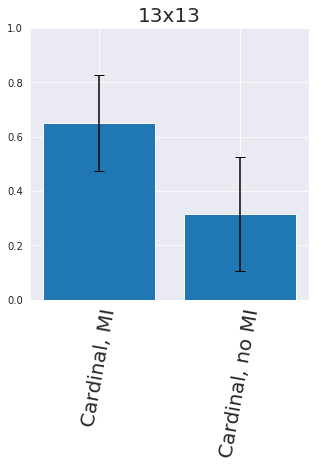

In [102]:
runs = [
#     (['K030', 'K031', 'K032'], 'Waypoint'),
    (['K458', 'K459', 'K460'], 'Waypoint, MI'),
    (['K461', 'K462', 'K463'], 'Waypoint no MI'),
    
]
plt.rcParams['figure.figsize'] = [5, 5]
plot_final_generalization(runs, '', all_env_names=['6x6', '7x10', '10x10', '13x13'], save_name='pm_waypoint_0shot_mi')
runs = [
        (['K464', 'K465', 'K466'], 'Cardinal, MI'),
        (['K467', 'K468', 'K469'], 'Cardinal, no MI'),
    ]

plot_final_generalization(runs, '', all_env_names=['6x6', '7x10', '10x10', '13x13'], save_name='pm_cardinal_0shot_mi')

data names [(['T5751'], 'FPP 20', 'red', None)]
RUN NAMES ['T5751']
about to load
NP [PosixPath('logs/TT5751')]
nps 1
LL 1
got data 1
LENGTHS [13317]
'Curriculum Step'


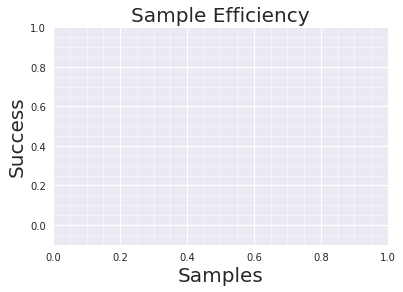

In [10]:
data_names = [
        (['T5751'], 'FPP 20', 'red', None),
    ]
x_label = 'samples'
metrics = ['Train/Success']
plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True,
               y_lower=-.1, y_upper=1, y_label="Success")